In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=40)
import sys
import math
import time

In [3]:
import pywt

In [4]:
from SLIP import Image, imread
from LogGabor import LogGabor

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
def mnist_reshape_128(x, i_offset = 0, j_offset = 0):
    assert x.shape == (28 * 28,)
    image = x.reshape(28, 28)
    image = np.append(np.zeros((128 + 2, 28)), image, axis = 0)
    image = np.append(image, np.zeros((128 + 2, 28)), axis = 0)
    image = np.append(np.zeros((288, 128 + 2)), image, axis = 1)
    image = np.append(image, np.zeros((288, 128 + 2)), axis = 1)
    return image[128 + 16 - 64 - i_offset : 128 + 16 + 64 - i_offset, 128 + 16 - 64 - j_offset : 128 + 16 + 64 - j_offset]

# Fonction calculant le nombre d'ondelettes en fonction de l'echelle ? ; shape : taille image
def calc_dim(shape, h, h_max):
    assert 0 <= h < h_max # h : echelle de composition d'ondelette
    if h == 0:
        dim_i = int(math.ceil(shape[0] * 1. // 2**(h_max - 1)))
        dim_j = int(math.ceil(shape[1] * 1. // 2**(h_max - 1)))
    else :
        dim_i = int(math.ceil(shape[0] * 1. // 2**(h_max - h)))
        dim_j = int(math.ceil(shape[1] * 1. // 2**(h_max - h)))
    return dim_i, dim_j

In [7]:
def minmax(value,   #valeur a delimiter
           border): #limite min/max a ne pas depasser 
    value = max(value, -border)
    value = min(value, border)
    return value

def normalize(array):
    normalized_array = (array - np.mean(array)) / np.std(array)
    return normalized_array

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def softmax_label_to_value(softmax_label):
    y_num = 0
    for n in softmax_label:
        if n == np.max(softmax_label): 
            value = y_num
            break
        y_num += 1
    return value  

def one_hot_label_to_value(one_hot_label):
    y_num = 0
    for n in one_hot_label:
        if n == 1: 
            value = y_num
            break
        y_num += 1
    return value  

# LogPolar transform

In [8]:
FIG_WIDTH = 12
FIGSIZE=(FIG_WIDTH, .618 * FIG_WIDTH)

In [9]:
param = {
# Image
'N_X' : 128, # size of images
'N_Y' : 128, # size of images
'do_mask'  : True, # used for instance in the Matching Pursuit algorithm self.pe.do_mask
'mask_exponent': 3., #sharpness of the mask
'use_cache' : True,
'verbose': 0,
'figpath': 'results',
'matpath': 'data_cache',
'datapath': 'database',
'figsize': 14.,
'formats': ['pdf', 'svg', 'jpg'],
'dpi': 450,
'seed': None, # a seed for the Random Number Generator (RNG) for picking images in databases, set to None or a given number to freeze the RNG
'N_image': None, # number of images to pick in a database, set to None if you want to pick all in the database
# whitening parameters:
'white_name_database' : 'kodakdb',
'white_n_learning' : 0,
'white_N' : .07,
'white_f_0' : .38, # olshausen = 0.2
'white_alpha' : 1.4,
'white_steepness' : 4.,
'white_recompute' : False,
}


In [10]:
i_offset = 10
j_offset = 10
N_X = 128
N_Y = 128

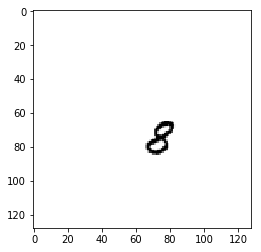

In [45]:
#im = Image(pe='https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py')
im = Image(pe=param)
#im = Image((128, 128))
mnist_sample_offset = mnist_reshape_128(mnist.train.images[5], i_offset = i_offset, j_offset = j_offset)
plt.imshow(mnist_sample_offset, cmap = 'gray_r')

In [46]:
image = mnist_sample_offset
print('Size of image', image.shape)

Size of image (128, 128)


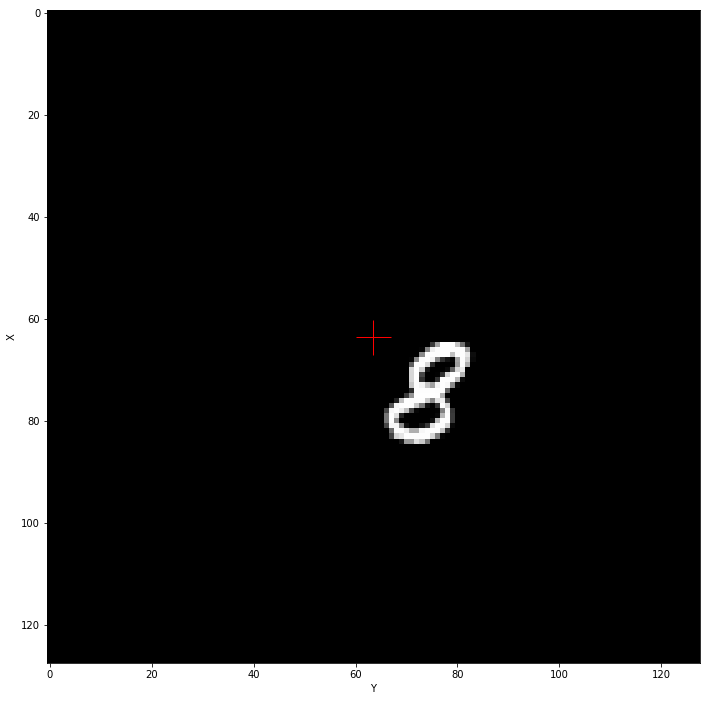

In [47]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image, cmap=plt.gray())
center = (63.5, 63.5) # X, Y
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot(center[1], center[0], 'r+', ms=35);

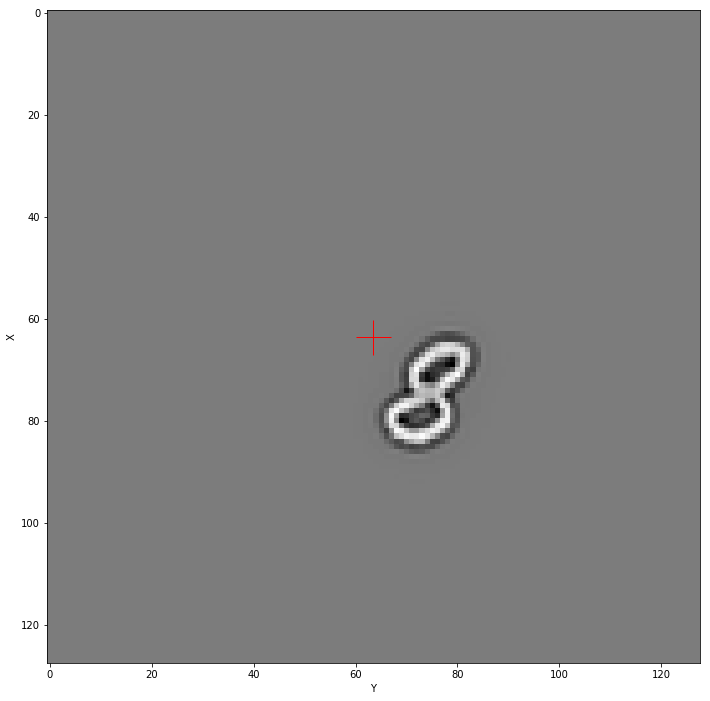

In [48]:
white = im.whitening(image)
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(white, cmap=plt.gray())
center = (63.5, 63.5) # X, Y
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot(center[1], center[0], 'r+', ms=35);

# LogGabor filter

In [11]:
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))
params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
phase = np.pi/4
edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

## Vectorizing

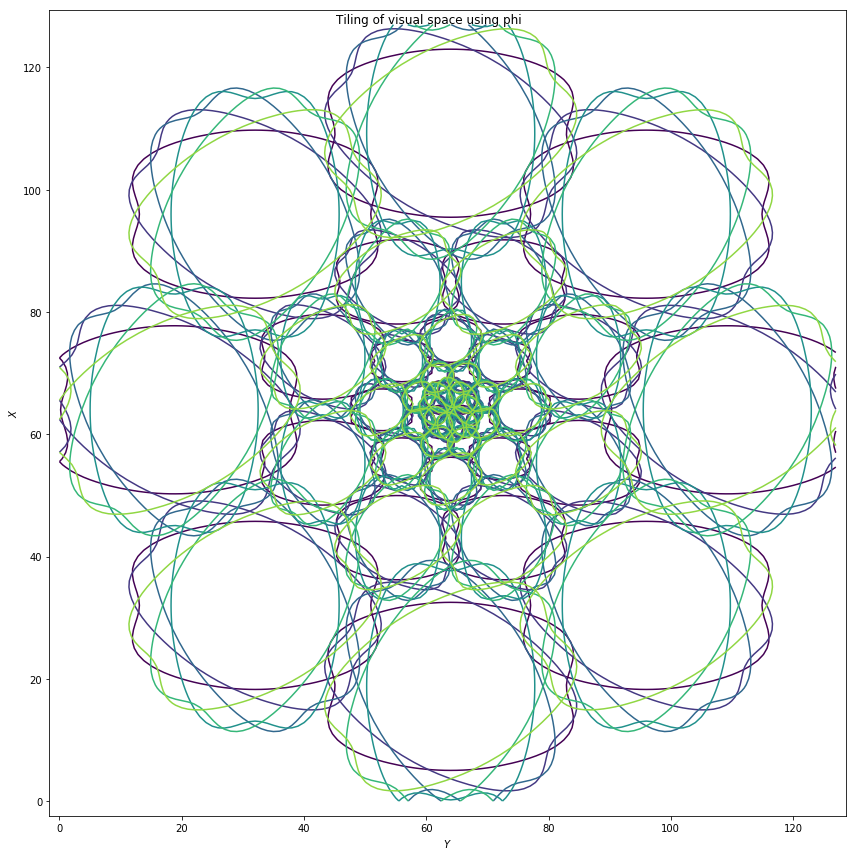

In [49]:
N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))

for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            ecc =  .5**(N_scale - i_scale)
            r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
            sf_0 = 0.5 * 0.03 / ecc
            #print('radius=', r, 'at scale', i_scale, 'with sf_0=', sf_0 , 'ecc', ecc)
            x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
            y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
            for i_phase in range(N_phase):
                params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                #print('At', i_theta, i_orient, i_scale, i_phase, 'x, y=', x, y, 'params=', params)
                phase = i_phase * np.pi/2
                phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            env = np.sqrt(phi[i_theta, i_orient, i_scale, 0, :]**2 + phi[i_theta, i_orient, i_scale, 1, :]**2).reshape((N_X, N_Y))
            ax.contour(env, levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using phi')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()
#plt.savefig('logPolar_shape.pdf')

In [12]:
# Transformation en fonction
def vectorization(N_theta,
                  N_orient,
                  N_scale,
                  N_phase,
                  N_X,
                  N_Y):
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))

    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc =  .5**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
                for i_phase in range(N_phase):
                    params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            
    return phi

In [50]:
N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
N_X, N_Y = 128, 128
vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)

array([[[[[  3.57078230e-08,   7.91535774e-07,  -7.52474000e-08, ...,
             7.29777127e-07,   1.37068341e-07,  -5.72618720e-07],
          [  6.96084624e-07,   4.63264280e-07,  -1.55741324e-07, ...,
             1.30862064e-06,   1.18025645e-07,  -8.38413886e-07]],

         [[ -7.09319960e-08,   8.92385337e-08,   8.14721466e-08, ...,
            -2.07336104e-08,   7.70514627e-08,   7.33337527e-08],
          [ -6.86092613e-09,   5.76349842e-08,  -8.61379693e-08, ...,
             3.69340082e-08,  -8.84492187e-08,   7.61246696e-08]],

         [[ -2.82947389e-08,  -2.63966209e-08,  -2.70289497e-08, ...,
            -3.59794948e-08,  -4.00599697e-08,  -4.21015279e-08],
          [ -6.49051490e-08,  -6.60466436e-08,  -6.83883434e-08, ...,
            -6.82459442e-08,  -6.72992698e-08,  -6.65156425e-08]],

         [[  1.04386118e-04,   1.07376619e-04,   1.09736113e-04, ...,
             1.21966455e-04,   1.25789991e-04,   1.28694249e-04],
          [  1.66135367e-04,   1.53732582e

## Example

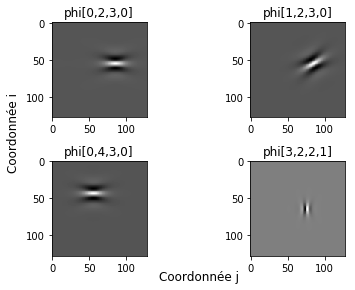

In [51]:
plt.subplot(2,2,1)
plt.title('phi[0,2,3,0]')
plt.imshow(np.reshape(phi[0,2,3,0,:],(128, 128))) # phi(N_theta, N_orient, N_scale, N_phase, ?)
plt.subplot(2,2,2)
plt.title('phi[1,2,3,0]')
plt.imshow(np.reshape(phi[1,2,3,0,:],(128, 128))) # phase inverse
plt.subplot(2,2,3)
plt.title('phi[0,4,3,0]')
plt.imshow(np.reshape(phi[0,4,3,0,:],(128,128))) # orientation modifiee
plt.subplot(2,2,4)
plt.title('phi[3,2,2,1]')
plt.imshow(np.reshape(phi[3,2,2,1,:],(128,128))) # echelle modifiee

plt.tight_layout()
plt.text(-70, 160, 'Coordonnée j', ha='center', fontsize=12)
plt.text(-320, -80, 'Coordonnée i', ha='center', fontsize=12, rotation=90)
plt.savefig('Gabor_filter.pdf')

## Encoding

In [52]:
code = phi @ image.ravel()
print('All scalar products in one shot = ', (code).shape )

All scalar products in one shot =  (6, 8, 5, 2)


In [53]:
print('Shape of phi=', phi.shape)
phi_vectorial = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
print('Shape of phi_vectorial=', phi_vectorial.shape)
print('Shape of phi=', phi_vectorial.reshape((N_theta, N_orient, N_scale, N_phase, N_X*N_Y)).shape)

Shape of phi= (6, 8, 5, 2, 16384)
Shape of phi_vectorial= (480, 16384)
Shape of phi= (6, 8, 5, 2, 16384)


In [54]:
vectorial_code = phi_vectorial @ image.ravel() # encoding x --> z 

In [55]:
print('Taille du code : ', vectorial_code.shape)

Taille du code :  (480,)


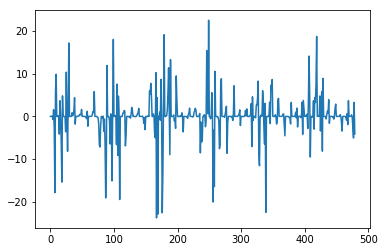

In [56]:
plt.plot(vectorial_code)

## Decoding / visualisation

In [57]:
phi_plus = np.linalg.pinv(phi_vectorial) # pseudo-inverse
image_hat = phi_plus @ vectorial_code # decoding z--> x

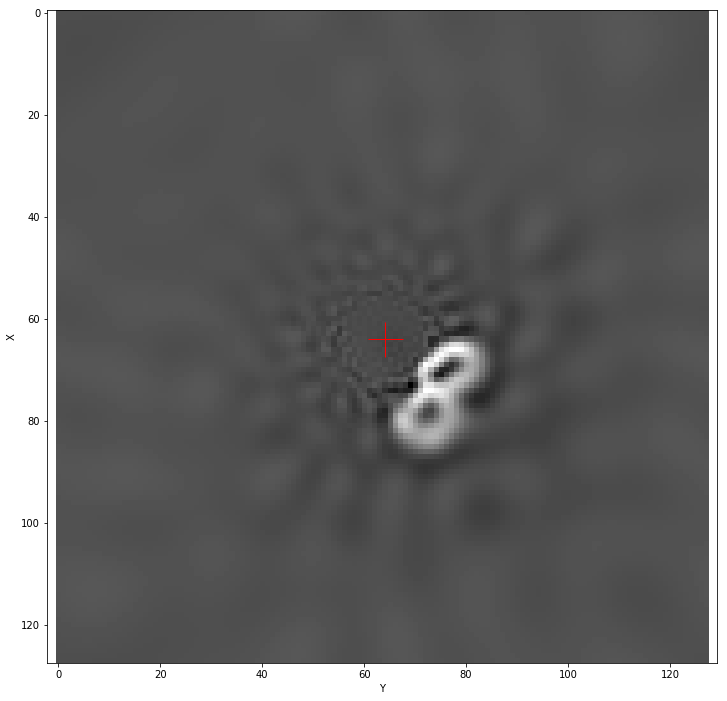

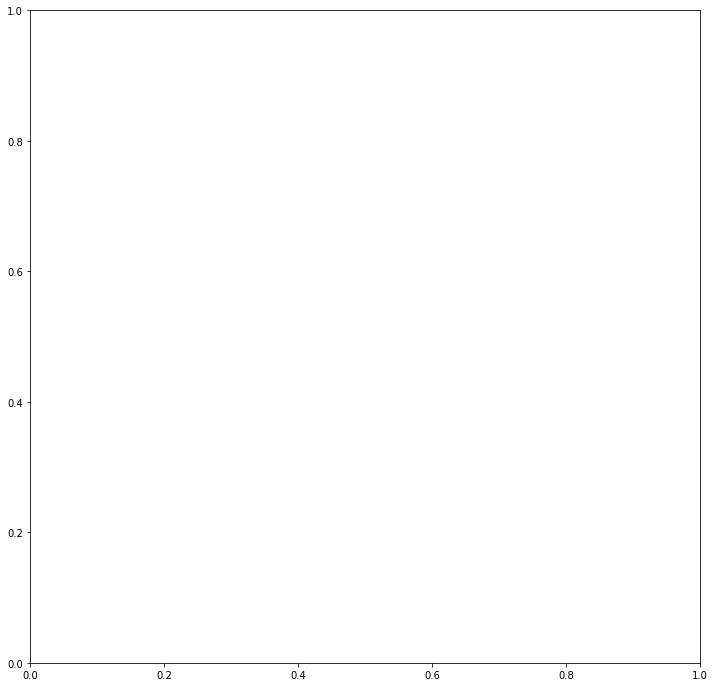

In [61]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image_hat.reshape((N_X, N_Y)), cmap=plt.gray())
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot([N_Y/2], [N_X/2], 'r+', ms=35)
ax.axis('equal')
#plt.savefig('LogPolar_effect.pdf')

# Wavelets filter

In [13]:
class WaveImage:
	
	def __init__(self, image = None, shape = (32, 32)):
		
		# Attribut shape
		if image is not None:
			# Decomposition ondelettes
			coeffs = pywt.wavedec2(image, 'haar') # haar correspond à une famille d'ondelettes
			self.__shape = image.shape
		else:
			self.__shape = shape
		
		# Attribut h_max : profondeur de l'image
		self.__h_max = min(int(math.log(self.__shape[0], 2)) + 1, 	int(math.log(self.__shape[1], 2)) + 1)
			
		# Attribut data : L'attribut data contient les vecteurs en position [h][u] (dictionnaire)
		if image is not None:
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
				if h == 0:
					(i_max, j_max) = coeffs[h].shape
				else:
					(i_max, j_max) = coeffs[h][0].shape
				for i in range(i_max):
					for j in range(j_max):
						if h == 0:
							data = coeffs[h][i][j]
						else:
							data = coeffs[h][0][i][j] # k : num ondelette ?
							for k in range(1,len(coeffs[h])):
								data = np.append(data, coeffs[h][k][i][j])	
						self.__data[h][(i, j)] = data				
		else: # image is None
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
					
		
	def get_data(self):
		return self.__data
	
	def get_shape(self):
		return self.__data
				
	def set_data(self, h, u, v):
		assert 0 <= h < self.__h_max
		dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
		assert 0 <= u[0] < dim_i
		assert 0 <= u[1] < dim_j
		if h == 0 :
			self.__data[h][u] = v
		else:
			self.__data[h][u] = np.copy(v)
		
	def get_h_max(self):
		return self.__h_max
		
	def get_image(self): # etape decodage pour retrouver image
		coeffs = []
		for h in range(self.__h_max):
			dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
			if h == 0:
				coeffs_h = np.zeros((dim_i, dim_j))
				for u in self.__data[h]:
					coeffs_h[u[0],u[1]] = self.__data[h][u]
			else:
				coeffs_h = [np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j))]
				for u in self.__data[h]:
					for k in range(3):
						coeffs_h[k][u[0],u[1]] = self.__data[h][u][k]
			coeffs += [coeffs_h]
		return pywt.waverec2(coeffs, 'haar')
		
	def add_coeffs(self, waveImage, u, h_ref = 0): # copie certains niveaux de l'arbre d'ondelettes
		# Niveau 0
		h_opp = self.__h_max - 1
		i = int(u[0] // 2**h_opp) 
		j = int(u[1] // 2**h_opp)
		u_0 = (i,j)
		if self.__data[0] == {}:
			self.__data[0][u_0] = waveImage.get_data()[0][u_0]
		else:
			v_test = self.__data[0][u_0]
			if np.linalg.norm(v_test) < 1e-16:
				self.__data[0][u_0] = waveImage.getData()[0][u_0]
		# Niveaux 1 et +
		for h in range(1, h_ref) :
			h_opp = self.__h_max - h
			i = int(u[0] // 2**h_opp) 
			j = int(u[1] // 2**h_opp)
			if (i,j) in self.__data[h]:
				v_test = self.__data[h][(i,j)]
				if np.linalg.norm(v_test) < 1e-16:
					self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
			else: 
				self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
	
	def copy(self): # copie complete
		self_shape = self.__shape 
		self_copy = WaveImage(shape = self_shape)
		for h in range(self.__h_max) :
			for u in self.__data[h]:
				self_copy.set_data(h, u, self.__data[h][u])
		return self_copy	
		
	def __str__(self): # affiche contenu objet
		h_max = len(self.__data)
		s = 'h_max :' + str(self.__h_max) + '\n'
		for h in range(self.__h_max):
			s += '***' + str(h) + '***\n'
			s += str(self.__data[h]) + '\n'
		return s

In [14]:
# Genere un dictionnaire de tenseurs indexes par la profondeur dans l'arbre des coefficients d'ondelettes 
def generate_tensor_data_with_offset_from_x(x, i_offset, j_offset):
    w1 = WaveImage(shape = (128, 128))
    w2 = WaveImage(image = mnist_reshape_128(x, i_offset = i_offset, j_offset = j_offset))
    w1.add_coeffs(w2, u = (63, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (63, 65), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 65), h_ref = w2.get_h_max())
    h_max = w1.get_h_max()
    data = w1.get_data()
    tensor_data = {}
    for k in data :
        if k == 0:
            tensor_data[0] = data[k][(0, 0)]
        elif k == 1:
            tensor_data[1] = np.array(data[k][(0, 0)])    
        else:
            tensor_data[k] = np.zeros((2, 2, 3))
            for u in data[k]:           
                u_offset = 64 // (2**(h_max - k)) - 1
                tensor_data[k][u[0] - u_offset, u[1] - u_offset, :] = np.array(data[k][u])
    return tensor_data, w1

In [15]:
def generate_vector_data_with_offset_from_x(x, i_offset, j_offset):
    # retourne un vecteur contenant les coefficients utilisés de l'image w1 générée à partir d'un point de fixation
    # central avec la cible en position i_offset, j_offset
    w1 = WaveImage(shape = (128, 128))
    w2 = WaveImage(image = mnist_reshape_128(x, i_offset = i_offset, j_offset = j_offset))
    w1.add_coeffs(w2, u = (63, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (63, 65), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 65), h_ref = w2.get_h_max())
    h_max = w1.get_h_max() # h = 7
    data = w1.get_data()
    vector_data = np.array([])
    for k in data :
        if k == 0:
            vector_data = np.append(vector_data, [data[k][(0, 0)]])
        elif k == 1:
            vector_data = np.append(vector_data, data[k][(0, 0)])  
        else:
            for u in data[k]:           
                 vector_data = np.append(vector_data, data[k][u])
    return vector_data, w1

## Energy

In [66]:
energy = (code**2).sum(axis=-1)
print('Shape of energy = ', energy.shape )

Shape of energy =  (6, 8, 5)


In [67]:
global_energy = (code**2).sum(axis=(0, -1))
print('Shape of global_energy = ', global_energy.shape )

Shape of global_energy =  (8, 5)


Shape of color_energy =  (8, 5, 3)


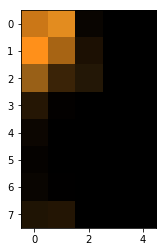

In [68]:
color_energy = np.zeros((N_orient, N_scale, 3))
for i_theta in range(N_theta):
    color = np.array([1 + np.cos(i_theta/N_theta + i*np.pi/3) for i in np.arange(3)])
    color_energy += energy[i_theta, :, :][:, :, np.newaxis] * color[np.newaxis, np.newaxis, :]
print('Shape of color_energy = ', color_energy.shape )
color_energy /= color_energy.max()
r, theta = np.meshgrid(np.linspace(0, 1, N_scale), np.linspace(0, 2*np.pi, N_orient))
fig, ax = plt.subplots()#subplot_kw=dict(projection='polar'))
#ax.pcolormesh(theta, r, color_energy);
ax.imshow(np.fliplr(color_energy));

In [69]:
log_r_target = 1  + np.log(np.sqrt(i_offset **2 + j_offset ** 2) / np.sqrt(N_X**2+N_Y**2) / 2) / 5
if j_offset != 0:
    theta_target = np.arctan(-i_offset / j_offset)
else:
    theta_target = np.sign(-i_offset) * np.pi/2


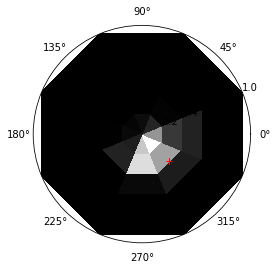

In [70]:
log_r, theta = np.meshgrid(np.linspace(0, 1, N_scale + 1), np.linspace(-np.pi * .625, np.pi * 1.375, N_orient + 1))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.pcolor(theta, log_r, np.fliplr(global_energy))
#ax.plot(log_r_target * np.cos(theta_target), log_r_target * np.sin(theta_target), 'r+')
ax.plot(theta_target , log_r_target, 'r+')

# Modèle Détecteur+Classifier avec saccades oculaires (intégration TensorFlow)

In [42]:
sess = tf.Session()

### Définir les paramètres principaux

In [23]:
Filter = 'Wavelets'   # LogPolar ou Wavelets
verbose = True

# Paramètres d'apprentissage
batch_size = 10000      # taille de l'échantillon d'apprentissage
iterations = 100      # nombre d'itérations que va durer l'apprentissage
if Filter == 'LogPolar':
    alpha_detect = 0.0015 # paramètre d'apprentissage de la couche de détection
    alpha_classif = 0.3   # paramètre d'apprentissage de la couche de classification
if Filter == 'Wavelets':
    alpha_detect = 0.03 # paramètre d'apprentissage de la couche de détection
    alpha_classif = 0.3   # paramètre d'apprentissage de la couche de classification

    
# Paramètres utilisés pour les graphiques
cost_detect_graph, cost_classif_graph = [], []

In [24]:
# Paramètres de la transformation logPolar
if Filter == 'LogPolar':
    N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
    N_X, N_Y = 128, 128
    phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
    phi_vectorial = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))

## Apprentissage du modèle

In [25]:
# Créer les placeholders et variables
if Filter == 'LogPolar': 
    vector_size = 480
    weights_detect = tf.Variable(tf.random_normal([vector_size,2], stddev=0.01), name='weights_detect_lp')    # poids (coordonnées)
    weights_classif = tf.Variable(tf.random_normal([vector_size,10], stddev=0.01), name='weights_classif_lp') # poids (classes)
if Filter == 'Wavelets':
    vector_size = 76
    weights_detect = tf.Variable(tf.random_normal([vector_size,2], stddev=0.01), name='weights_detect_wl')    # poids (coordonnées)
    weights_classif = tf.Variable(tf.random_normal([vector_size,10], stddev=0.01), name='weights_classif_wl') # poids (classes)
    
x_train = tf.placeholder(tf.float32, shape=[None, vector_size], name='x_train')   # input (vector_data)
coord = tf.placeholder(tf.float32, shape=[None, 2], name='coord')                 # labels (coordonnées)
labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')              # labels (classes)

In [26]:
print('Lancement apprentissage...')
# Initialiser les variables
init = tf.global_variables_initializer()
sess.run(init)

# Initialiser la sauvegarde du graph (variable + valeurs) + init graphique
if Filter == 'Wavelets':  
    saver = tf.train.Saver(var_list={"weights_detect_wl": weights_detect, "weights_classif_wl": weights_classif})
if Filter == 'LogPolar': 
    saver = tf.train.Saver(var_list={"weights_detect_lp": weights_detect, "weights_classif_lp": weights_classif})

# Calcul hypothèse du détecteur
hypo = tf.matmul(x_train, weights_detect)
# Définition du classifieur
classif = tf.nn.softmax(tf.matmul(x_train, weights_classif))

# Calcul coûts
cost_detect = (1/(2*batch_size))*(tf.reduce_sum(tf.square(hypo-coord))) #+ tf.contrib.layers.apply_regularization(l2_regularizer, weights)
cost_classif = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=classif)
#cost_classif = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=classif)
#cost_classif = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=classif)

# Définition des entraîneurs
optimizer_detect = tf.train.GradientDescentOptimizer(alpha_detect).minimize(cost_detect) #AdamOptimizer(0.001)
optimizer_classif = tf.train.GradientDescentOptimizer(alpha_classif).minimize(cost_classif)

time_start = time.time()
for it in range(iterations):
    if verbose: 
        if it%10 == 0: print('iteration #', it)
    
    # Récupération des données d'apprentissage
    batch = mnist.test.next_batch(batch_size)
    
    #Entrainement détecteur
    values, coord_values = [], []
    for x in batch[0]:
        i_offset, j_offset = minmax(int(np.random.randn() * 15), 40), minmax(int(np.random.randn() * 15), 40)
        coord_values += [(i_offset, j_offset)]
        
        image = mnist_reshape_128(x, i_offset=i_offset, j_offset=j_offset)        
        if Filter == 'LogPolar':
            v = phi_vectorial @ np.ravel(image)
        if Filter == 'Wavelets':
            v, w = generate_vector_data_with_offset_from_x(x, i_offset, j_offset)
        values += [v]
     
    sess.run(optimizer_detect, {x_train: values, coord: coord_values}) # Lancer l'entraînement

    # Prépration graphiques
    cost_detect_value = sess.run(cost_detect, {x_train : values, coord: coord_values})
    cost_detect_graph += [cost_detect_value]
    
    # Entrainement classifier (contexte : images proches de la fovea)
    values, labels_values = [], []
    num_x = 0
    for x in batch[0]:
        i_offset, j_offset = minmax(int(np.random.randn() * 0), 0), minmax(int(np.random.randn() * 0), 0)
        labels_values += [batch[1][num_x]]
        
        image = mnist_reshape_128(x, i_offset=i_offset, j_offset=j_offset)
        if Filter == 'LogPolar':
            v = phi_vectorial @ np.ravel(image)
        if Filter == 'Wavelets':
            v, w = generate_vector_data_with_offset_from_x(x, i_offset, j_offset)

        values += [v]
        
        num_x += 1
    
    sess.run(optimizer_classif, {x_train: values, labels: labels_values}) # Lancer l'entraînement
    
    # Préparations graphiques
    cost_classif_value = sess.run(cost_classif, {x_train: values, labels: labels_values})
    cost_classif_graph += [np.mean(cost_classif_value)]
    
    # Sauvegarder le graph
    if Filter == 'LogPolar':
        save_path = "/home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt"
    if Filter == 'Wavelets':
        save_path = "/home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt"
    saver.save(sess, save_path)
    if verbose: print("Model saved in file: %s" % save_path)

print("... Fin de l'apprentissage")
print("Temps nécessaire à apprentissage (mn):", (time.time()-time_start)/60)

Lancement apprentissage...
iteration # 0
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
iteration # 10
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
Model saved in file: /home/pimt/Documents/No

KeyboardInterrupt: 

In [ ]:
# Intégration graphique
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 10))

plt.subplot(122)
plt.plot(cost_classif_graph)
plt.ylabel('Coût (classification)', fontsize=20)
        
plt.subplot(121)
plt.plot(cost_detect_graph)
plt.ylabel('Coût (détection)', fontsize=20)

fig.text(0.52, 0.075, "Nombre d'itérations", ha='center', fontsize=20)
fig.text(0.1, 0.85, 'A', ha='center', fontsize=25)
fig.text(0.525, 0.85, 'B', ha='center', fontsize=25)
if Filter == 'LogPolar':
    if verbose: print('Filter :', Filter)
    plt.savefig('logpolar_cost_learning.pdf')
if Filter == 'Wavelets':
    if verbose: print('Filter :', Filter)
    plt.savefig('wavelets_cost_learning.pdf')
plt.show()

In [21]:
sess.close()

### Restaurer le graph enregistré

In [15]:
sess = tf.InteractiveSession()

init = tf.global_variables_initializer()
sess.run(init)

saver = tf.train.Saver()
    if Filter == 'LogPolar':
        save_path = "/home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt"
    if Filter == 'Wavelets':
        save_path = "/home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt"
saver.restore(sess, save_path)

print('weights_detect: \n' , sess.run(weights_detect)) # Imprimer les poids du détecteur

sess.close()

INFO:tensorflow:Restoring parameters from /home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt
weights_detect: 
 [[ 0.0022468   0.0113708 ]
 [-0.01367941  0.0038001 ]
 [ 0.00480139 -0.01601398]
 ..., 
 [ 0.0192199  -0.01044   ]
 [-0.07613662 -0.0752456 ]
 [ 0.16974448 -0.13956973]]


## Saccades oculaires

### Définir les paramètres principaux

In [29]:
# Paramètres de l'évaluation
test_size = 100   # taille de l'echantillon de test
fovea_size = 4   # longueur/largeur de la fovea

# Autres paramètres
verbose = True      # True pour messages, False pour silence
Mode = 'Multiple'   # Single pour évaluer un seul filtre, Multiple pour les comparer
Filter = 'LogPolar' # LogPolar ou Wavelets

### Récupération des données

In [43]:
print('Mode:', Mode)

if Mode == 'Single':
    print('Filter:', Filter)
    sess = tf.InteractiveSession()
    
    if Filter == 'LogPolar': 
        vector_size = 480
        weights_detect = tf.Variable(tf.random_normal([vector_size,2], stddev=0.01), name='weights_detect_lp')    # poids (coordonnées)
        weights_classif = tf.Variable(tf.random_normal([vector_size,10], stddev=0.01), name='weights_classif_lp') # poids (classes)
        save_path = "/home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt"
        # Paramètres de la transformation logPolar
        N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
        N_X, N_Y = 128, 128
        phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
        phi_vectorial = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
        
    if Filter == 'Wavelets':
        vector_size = 76
        weights_detect = tf.Variable(tf.random_normal([vector_size,2], stddev=0.01), name='weights_detect_wl')    # poids (coordonnées)
        weights_classif = tf.Variable(tf.random_normal([vector_size,10], stddev=0.01), name='weights_classif_wl') # poids (classes)
        save_path = "/home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt"
     
    x_train = tf.placeholder(tf.float32, shape=[None, vector_size], name='x_train')   # input (vector_data)
    coord = tf.placeholder(tf.float32, shape=[None, 2], name='coord')                 # labels (coordonnées)
    labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')              # labels (classes) 
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    saver.restore(sess, save_path)
    
    if verbose: 
        print('Model restored.')
        print('weights_detect: \n' , sess.run(weights_detect))   # Imprimer les poids du détecteur
        print('weights_classif: \n' , sess.run(weights_classif)) # Imprimer les poids du classifieur
    
if Mode == "Multiple":
    # Ouverture d'une session pour chaque filtre, permettant d'extraire individuellement
    # les résultats de leurs apprentissage et plus loin de les comparer
    
    # Filtre Wavelets 
    sess_wl = tf.InteractiveSession()
    x_train = tf.placeholder(tf.float32, shape=[None, 76], name='x_train')   # input (vector_data)
    coord = tf.placeholder(tf.float32, shape=[None, 2], name='coord')         # labels (coordonnées)
    labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')      # labels (classes)
    weights_detect = tf.Variable(tf.random_normal([76,2], stddev=0.01), name='weights_detect_wl')    # poids (coordonnées)
    weights_classif = tf.Variable(tf.random_normal([76,10], stddev=0.01), name='weights_classif_wl') # poids (classes)
    
    sess_wl.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess_wl, "/home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt")
    if verbose: print('weights_detect for Wavelets filter:\n', sess_wl.run(weights_detect))
        
    weights_detect_wl = weights_detect.eval(session=sess_wl)
    weights_classif_wl = weights_classif.eval(session=sess_wl) 
    
    sess_wl.close()
    tf.reset_default_graph()
    
    # Filtre LogPolar
    sess_lp = tf.InteractiveSession()
    x_train = tf.placeholder(tf.float32, shape=[None, 480], name='x_train')   # input (vector_data)
    coord = tf.placeholder(tf.float32, shape=[None, 2], name='coord')         # labels (coordonnées)
    labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')      # labels (classes)
    weights_detect = tf.Variable(tf.random_normal([480,2], stddev=0.01), name='weights_detect_lp')    # poids (coordonnées)
    weights_classif = tf.Variable(tf.random_normal([480,10], stddev=0.01), name='weights_classif_lp') # poids (classes)
    
        # Paramètres de la transformation logPolar
    N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
    N_X, N_Y = 128, 128
    phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
    phi_vectorial = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
    
    sess_lp.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess_lp, "/home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt")    
    if verbose: print('weights_detect for LogPolar filter:\n', sess_lp.run(weights_detect))
        
    weights_detect_lp = weights_detect.eval(session=sess_lp)
    weights_classif_lp = weights_classif.eval(session=sess_lp)
    
    sess_lp.close()
    tf.reset_default_graph()

Mode: Multiple
INFO:tensorflow:Restoring parameters from /home/pimt/Documents/Notebooks/TF_graph_wavelets.ckpt
weights_detect for Wavelets filter:
 [[  4.73112147e-03  -5.71105815e-03]
 [ -3.07806420e+00   1.06605021e-02]
 [  3.32729891e-04  -3.08520675e+00]
 ..., 
 [ -5.65143209e-03  -7.09909247e-03]
 [ -6.37113536e-03  -2.06816066e-02]
 [ -1.32156657e-02  -1.07452897e-02]]
INFO:tensorflow:Restoring parameters from /home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt
weights_detect for LogPolar filter:
 [[-0.02542895  0.01083547]
 [-0.00452948 -0.00370808]
 [-0.00995225  0.00840656]
 ..., 
 [ 0.02879993 -0.02139028]
 [-0.06637616 -0.06002691]
 [ 0.14861025 -0.13327657]]


## Réalisation des saccades oculaires (évaluation du modèle)

In [22]:
if Mode == 'Single':
    print('Lancement évaluation filtre', Filter, '...')

    # Récupération des données et des poids tirés de l'apprentissage
    test_batch = mnist.test.next_batch(test_size)
    weights_sacc = weights_detect.eval(session=sess)
    weights_cat = weights_classif.eval(session=sess)

    # Paramètres utilisés pour les graphiques
    nb_sacc = [(0) for _ in range(6)]
    inital_dist_per_nb_sacc = []
    err_per_dist = []

    num_x = 0
    for x in test_batch[0]:
        target_not_in_fovea = True  # reste True tant que la cible n'est pas presente dans la fovea
        it = 1                      # nombre d'iterations ~= nombre de saccades
        previous_prediction = 0     # contient la prediction précdente lorsque it>0
        new_prediction = 0          # contient la nouvelle prédiction lorsque it>0
        initial_dist = 0            # contient la distance initiale, avant saccade (graphique)
        initial_coord = (0,0)       # contient les coordonnées initiales, avant saccade (graphique)
        sacc_chain = []             # contient la somme des saccades (graphique)

        # Définition coordonnées et catégorie réelles
        i_offset, j_offset = minmax(int(np.random.randn() * 15), 40), minmax(int(np.random.randn() * 15), 40)
        cat_offset = test_batch[1][num_x]

        # Préparation graphiques
        sqrd_coord = np.square(i_offset) + np.square(j_offset)
        initial_dist = int(np.sqrt(sqrd_coord))
        initial_coord = (i_offset,j_offset)

        if verbose: 
            print('coordonnées réelles :', i_offset, j_offset)
            print('catégorie réelle :', one_hot_label_to_value(cat_offset))

        while target_not_in_fovea:
            image = mnist_reshape_128(x, i_offset=i_offset, j_offset=j_offset)
            if Filter == 'LogPolar': # Application filtre LogPolar
                v = phi_vectorial @ np.ravel(image)
            if Filter == 'Wavelets': # Application filtre Wavelets
                v, w = generate_vector_data_with_offset_from_x(x, i_offset, j_offset)

            cat_hat = softmax(np.dot(v, weights_cat)) # Prédiction de la catégorie par le modèle
            if verbose :
                print('catégorie prédite :', softmax_label_to_value(cat_hat))
                if softmax_label_to_value(cat_hat) == one_hot_label_to_value(cat_offset) : 
                    print(':::Prédiction correcte:::')

            # Vérification position cible (est-elle présente dans la fovéa?)
            if  i_offset >= -(fovea_size/2) and i_offset <= (fovea_size/2):
                if j_offset >= -(fovea_size/2) and j_offset <= (fovea_size/2):
                    target_not_in_fovea = False
                    nb_sacc[it-1] += 1 # Récupération données pour graphique
                    if verbose : print(':::Cible dans la fovéa:::')

            coord_hat = np.dot(v, weights_sacc) # prédiction des coordonnées par la modèle
            coord_hat = coord_hat.astype(int)   # transformation de la prédiction en integer

            for value in coord_hat:
                value = minmax(value, 40)
            if verbose : print('coordonnées prédites :', coord_hat)

            if it != 1:   # si ce n'est pas la premiere iteration de la boucle while
                new_prediction = coord_hat + previous_prediction

            previous_prediction += coord_hat  # mise a jour de la prediction precedente 

            # Préparation graphiques
            sqrd_coord_hat = np.square(i_offset - coord_hat[0]) + np.square(j_offset - coord_hat[1])
            err = int(np.sqrt(sqrd_coord_hat))
            sqrd_coord_actual = np.square(i_offset) + np.square(j_offset)
            dist = int(np.sqrt(sqrd_coord_actual))
            err_per_dist += [(err,dist)]
            if it == 1: v_ori = v
            if target_not_in_fovea:
                sacc_chain += [(coord_hat[0], coord_hat[1])]
                i_offset, j_offset = minmax((i_offset - coord_hat[0]), 40), minmax((j_offset - coord_hat[1]), 40) # nouvelle position de la cible par rapport au point de fixation apres saccade
                if verbose : print('nouvelles coordonnées :', i_offset, j_offset)

                it += 1
                if it == 6:
                    if verbose : print("break d'urgence")
                    nb_sacc[-1] += 1
                    break

        num_x += 1

        # Préparation graphiques
        inital_dist_per_nb_sacc += [(initial_dist, it-1)]

        if verbose : print('\n',"*"*30,'\n') # séparation visuelle entre les exemples

    print('...fin évaluation')

Lancement évaluation filtre LogPolar ...
coordonnées réelles : 17 16
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ 8 10]
nouvelles coordonnées : 9 6
catégorie prédite : 2
coordonnées prédites : [5 3]
nouvelles coordonnées : 4 3
catégorie prédite : 3
coordonnées prédites : [2 2]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -6 -12
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [-4 -8]
nouvelles coordonnées : -2 -4
catégorie prédite : 2
coordonnées prédites : [-1 -4]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -16 -23
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ -9 -20]
nouvelles coordonnées : -7 -3
catégorie prédite : 2
coordonnées prédites : [-7 -4]
nouvelles coord

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-3  6]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 6 26
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [ 7 20]
nouvelles coordonnées : -1 6
catégorie prédite : 8
coordonnées prédites : [0 6]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 0 12
catégorie réelle : 4
catégorie prédite : 6
coordonnées prédites : [0 9]
nouvelles coordonnées : 0 3
catégorie prédite : 3
coordonnées prédites : [0 2]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 1 -2
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans 

catégorie prédite : 3
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 15
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [-2  9]
nouvelles coordonnées : -1 6
catégorie prédite : 8
coordonnées prédites : [0 4]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -20 11
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-15  11]
nouvelles coordonnées : -5 0
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-5  0]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -13 -10
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-24 -17]
nouvelles coordonnées : 

catégorie prédite : 9
coordonnées prédites : [ -5 -24]
nouvelles coordonnées : 1 6
catégorie prédite : 3
coordonnées prédites : [1 7]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -14 16
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [-4  5]
nouvelles coordonnées : -10 11
catégorie prédite : 5
coordonnées prédites : [-3  4]
nouvelles coordonnées : -7 7
catégorie prédite : 8
coordonnées prédites : [-2  2]
nouvelles coordonnées : -5 5
catégorie prédite : 2
coordonnées prédites : [-1  2]
nouvelles coordonnées : -4 3
catégorie prédite : 2
coordonnées prédites : [-1  1]
nouvelles coordonnées : -3 2
break d'urgence

 ****************************** 

coordonnées réelles : -4 11
catégorie réelle : 3
catégorie prédite : 5
coordonnées prédites : [-1  3]
nouvelles coordonnées : -3 8
catégorie prédite : 2
coordonnées prédites : [0 2]
no

catégorie prédite : 8
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -2 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : -2 -2
break d'urgence

 ****************************** 

coordonnées réelles : 35 6
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [45 10]
nouvelles coordonnées : -10 -4
catégorie prédite : 3
coordonnées prédites : [-9 -4]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -28 1
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [-26   3]
nouvelles coordonnées : -2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 3 -7
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [ 3 -8]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 *

catégorie prédite : 2
coordonnées prédites : [-6  0]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -6 -1
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-5  0]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 16 -9
catégorie réelle : 1
catégorie prédite : 5
coordonnées prédites : [ 5 -4]
nouvelles coordonnées : 11 -5
catégorie prédite : 8
coordonnées prédites : [ 4 -1]
nouvelles coordonnées : 7 -4
catégorie prédite : 8
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 5 -3
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 4 -2
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles coordonnées : 3 -2
break d'urgence

 ****************************** 



catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -24 -4
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-15  -1]
nouvelles coordonnées : -9 -3
catégorie prédite : 3
coordonnées prédites : [-6 -2]
nouvelles coordonnées : -3 -1
catégorie prédite : 2
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -6 29
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-4 18]
nouvelles coordonnées : -2 11
catégorie prédite : 2
coordonnées prédites : [-1  8]
nouvelles coordonnées : -1 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [-1  3]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réell

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 6 19
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ 3 10]
nouvelles coordonnées : 3 9
catégorie prédite : 2
coordonnées prédites : [1 4]
nouvelles coordonnées : 2 5
catégorie prédite : 8
coordonnées prédites : [1 2]
nouvelles coordonnées : 1 3
catégorie prédite : 8
coordonnées prédites : [0 1]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 0 4
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [0 1]
nouvelles coordonnées : 0 3
catégorie prédite : 8
coordonnées prédites : [0 1]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 38 -2
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites :

coordonnées réelles : -15 10
catégorie réelle : 0
catégorie prédite : 5
coordonnées prédites : [-13   9]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -26 -8
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-40 -19]
nouvelles coordonnées : 14 11
catégorie prédite : 9
coordonnées prédites : [19 15]
nouvelles coordonnées : -5 -4
catégorie prédite : 2
coordonnées prédites : [-7 -5]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [3 1]

 ****************************** 

coordonnées réelles : 16 7
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [27 12]
nouvelles coordonnées : -11 -5
catégorie prédite : 3
coordonnées prédites : [-19  -8]
nouvelles coordonnées : 8 3
catégorie prédite : 3
coordonnées prédites : [15  6]
nouvelles coordonnées : -7 -3
catégorie prédite : 2
coordonnées prédites 

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -13 16
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-16  20]
nouvelles coordonnées : 3 -4
catégorie prédite : 8
coordonnées prédites : [ 4 -6]
nouvelles coordonnées : -1 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  3]

 ****************************** 

coordonnées réelles : 9 6
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [10  7]
nouvelles coordonnées : -1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 10 9
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [10  7]
nouvelles coordonnées : 0 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 22 29
catégorie réelle : 6
catégorie prédite : 7
co

catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -15 -5
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-10  -3]
nouvelles coordonnées : -5 -2
catégorie prédite : 8
coordonnées prédites : [-3 -2]
nouvelles coordonnées : -2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 0 -20
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [  0 -15]
nouvelles coordonnées : 0 -5
catégorie prédite : 3
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -16 12
catégorie réelle : 8
catégorie prédite : 5
coordonnées prédites : [-14  12]
nouvelles coordonnées : -2 0
catégorie prédite : 8
:::Prédiction correc

catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -22 6
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-9  1]
nouvelles coordonnées : -13 5
catégorie prédite : 5
coordonnées prédites : [-7  2]
nouvelles coordonnées : -6 3
catégorie prédite : 3
coordonnées prédites : [-3  2]
nouvelles coordonnées : -3 1
catégorie prédite : 3
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 1
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 5 2
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [6 2]
nouvell

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 12 5
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [6 2]
nouvelles coordonnées : 6 3
catégorie prédite : 2
coordonnées prédites : [2 2]
nouvelles coordonnées : 4 1
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 0 21
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [ 0 18]
nouvelles coordonnées : 0 3
catégorie prédite : 3
coordonnées prédites : [0 2]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 15 -5
catégorie réelle : 5
catégorie prédite : 3
coordonnées prédites : [15 -6]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fo

catégorie prédite : 9
coordonnées prédites : [  8 -11]
nouvelles coordonnées : 4 -5
catégorie prédite : 8
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -5 16
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [-5 15]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -6 13
catégorie réelle : 5
catégorie prédite : 6
coordonnées prédites : [-4  8]
nouvelles coordonnées : -2 5
catégorie prédite : 2
coordonnées prédites : [-1  3]
nouvelles coordonnées : -1 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 9 8
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [9 9]
nouvelles coordonnées : 0 -1


catégorie prédite : 8
coordonnées prédites : [0 0]
nouvelles coordonnées : -2 3
break d'urgence

 ****************************** 

coordonnées réelles : 13 24
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [ 6 17]
nouvelles coordonnées : 7 7
catégorie prédite : 2
coordonnées prédites : [5 7]
nouvelles coordonnées : 2 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 2 1
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : 15 5
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [11  3]
nouvelles coordonnées : 4 2
catégorie prédite : 3
coordonnées prédites : [3 2]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réell

catégorie prédite : 2
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -3 -3
catégorie prédite : 8
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : -13 -4
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [-4 -1]
nouvelles coordonnées : -9 -3
catégorie prédite : 8
coordonnées prédites : [-3 -1]
nouvelles coordonnées : -6 -2
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -4 -2
catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coordonnées : -3 -2
catégorie prédite : 8
coordonnées prédites : [0 0]
nouvelles coordonnées : -3 -2
break d'urgence

 ****************************** 

coordonnées réelles : -8 14
catégorie réelle : 5
catégorie prédite : 0
coordonnées prédites : [-10  19]
nouvelles coordonnées : 2 -5
catégorie prédite : 8
coordonnées prédites : [ 2 -7]
nouvelles coordonnée

catégorie prédite : 3
coordonnées prédites : [13 -1]
nouvelles coordonnées : 3 -1
catégorie prédite : 3
coordonnées prédites : [3 0]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 20
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [ 3 11]
nouvelles coordonnées : 4 9
catégorie prédite : 2
coordonnées prédites : [2 5]
nouvelles coordonnées : 2 4
catégorie prédite : 8
coordonnées prédites : [1 3]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 18 10
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [18 13]
nouvelles coordonnées : 0 -3
catégorie prédite : 2
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 **********

catégorie prédite : 9
coordonnées prédites : [ -5 -16]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : -7 -10
catégorie réelle : 8
catégorie prédite : 4
coordonnées prédites : [-4 -6]
nouvelles coordonnées : -3 -4
catégorie prédite : 2
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -15 -18
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [-13 -18]
nouvelles coordonnées : -2 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 11 4
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [10  3]
nouvelles coordonnée

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 5 3
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [6 4]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 3 -12
catégorie réelle : 8
catégorie prédite : 4
coordonnées prédites : [ 2 -7]
nouvelles coordonnées : 1 -5
catégorie prédite : 2
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 38 -11
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [11 -4]
nouvelles coordonnées : 27 -7
catégorie prédite : 7
coordonnées prédites : [13 -3]
nouvelles coordonnées : 14 -4
catégorie prédite : 8
coordonnées prédites : [ 7 -2]
nouvelles coordonnées : 

nouvelles coordonnées : -2 -8
catégorie prédite : 2
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : -2 -6
break d'urgence

 ****************************** 

coordonnées réelles : -29 6
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [-31   8]
nouvelles coordonnées : 2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -2 10
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [-2 10]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 -4
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-5 -3]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -17 0
catégorie réelle : 1
catégorie prédite : 3
coordon

catégorie prédite : 2
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 3]

 ****************************** 

coordonnées réelles : -26 2
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-25   4]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : -14 7
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [-13   6]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 12 -15
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [ 15 -21]
nouvelles coordonnées : -3 6
catégorie prédite : 8
coordonnées prédites : [-4  9]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 1 -5]
nouvelles coordon

catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [0 2]
nouvelles coordonnées : 1 2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -11 -13
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [-5 -6]
nouvelles coordonnées : -6 -7
catégorie prédite : 2
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -4 -4
catégorie prédite : 2
coordonnées prédites : [-2 -2]
nouvelles coordonnées : -2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 0 25
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [ 0 20]
nouvelles coordonnées : 0 5
catégorie prédite : 8
coordonnées prédites : [0 5]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -

catégorie prédite : 2
coordonnées prédites : [ 7 -8]
nouvelles coordonnées : 4 -4
catégorie prédite : 8
coordonnées prédites : [ 3 -3]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 -5
catégorie réelle : 3
catégorie prédite : 8
coordonnées prédites : [ 1 -5]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 8 6
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [8 6]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3 -27
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [  4 -28]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dan

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-7  0]
nouvelles coordonnées : -5 0
catégorie prédite : 3
coordonnées prédites : [-2  0]
nouvelles coordonnées : -3 0
catégorie prédite : 3
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -17 24
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-15  28]
nouvelles coordonnées : -2 -4
catégorie prédite : 2
coordonnées prédites : [-2 -6]
nouvelles coordonnées : 0 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -6 20
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-5 17]
nouvelles coordonnées : -1 3
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [0 2]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Prédiction correcte:::
:::

catégorie prédite : 4
coordonnées prédites : [0 0]
nouvelles coordonnées : -40 -6
catégorie prédite : 4
coordonnées prédites : [0 0]
nouvelles coordonnées : -40 -6
catégorie prédite : 4
coordonnées prédites : [0 0]
nouvelles coordonnées : -40 -6
catégorie prédite : 4
coordonnées prédites : [0 0]
nouvelles coordonnées : -40 -6
catégorie prédite : 4
coordonnées prédites : [0 0]
nouvelles coordonnées : -40 -6
break d'urgence

 ****************************** 

coordonnées réelles : 29 0
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [44 -3]
nouvelles coordonnées : -15 3
catégorie prédite : 3
coordonnées prédites : [-17   2]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [3 1]

 ****************************** 

coordonnées réelles : -5 3
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-4  3]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Prédic

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 20 6
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [3 0]
nouvelles coordonnées : 17 6
catégorie prédite : 9
coordonnées prédites : [3 0]
nouvelles coordonnées : 14 6
catégorie prédite : 3
coordonnées prédites : [3 1]
nouvelles coordonnées : 11 5
catégorie prédite : 3
coordonnées prédites : [2 1]
nouvelles coordonnées : 9 4
catégorie prédite : 3
coordonnées prédites : [2 1]
nouvelles coordonnées : 7 3
break d'urgence

 ****************************** 

coordonnées réelles : -10 -10
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [-11 -10]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 3 8
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [3 9]
nouvelles coordonnées

coordonnées prédites : [-7  5]
nouvelles coordonnées : -5 4
catégorie prédite : 8
coordonnées prédites : [-3  2]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 5 -18
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [  3 -11]
nouvelles coordonnées : 2 -7
catégorie prédite : 3
coordonnées prédites : [ 1 -5]
nouvelles coordonnées : 1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 6 9
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [4 8]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 0 7
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [ 0 14]
nouvelles coordonnées : 0 -7
catégorie prédite : 2
coordonnées prédites : [  

catégorie prédite : 7
coordonnées prédites : [-20   9]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : 10 -21
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [  3 -11]
nouvelles coordonnées : 7 -10
catégorie prédite : 2
coordonnées prédites : [ 3 -5]
nouvelles coordonnées : 4 -5
catégorie prédite : 8
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 2 -3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 1 -2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 12 17
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [16 25]
nouvelles coordonnées : -4 -8
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [ -5 -12]
nouvelles coordonnées : 1 4
catégorie prédit

catégorie prédite : 3
coordonnées prédites : [ 6 -2]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 9
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [0 8]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 13 1
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [8 1]
nouvelles coordonnées : 5 0
catégorie prédite : 3
coordonnées prédites : [3 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 2 -22
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [  1 -12]
nouvelles coordonnées : 1 -10
catégorie prédite : 8
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : 1 -4
catégorie prédite : 2
coordonnées p

catégorie prédite : 2
coordonnées prédites : [-2 10]
nouvelles coordonnées : 0 -2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : 11 6
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [17  9]
nouvelles coordonnées : -6 -3
catégorie prédite : 2
coordonnées prédites : [-8 -4]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [3 2]

 ****************************** 

coordonnées réelles : 3 6
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [4 8]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : -8 -1
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [-7 -1]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 **

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -1 6
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [-1  7]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 22 20
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [22 17]
nouvelles coordonnées : 0 3
catégorie prédite : 3
coordonnées prédites : [0 3]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 14 10
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [11  8]
nouvelles coordonnées : 3 2
catégorie prédite : 2
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 1
catégorie prédite : 6
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 *******

catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [ 0 24]
nouvelles coordonnées : 0 -3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 8 9
catégorie réelle : 5
catégorie prédite : 3
coordonnées prédites : [6 7]
nouvelles coordonnées : 2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -15 -19
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [ -7 -12]
nouvelles coordonnées : -8 -7
catégorie prédite : 8
coordonnées prédites : [-6 -5]
nouvelles coordonnées : -2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : 3 -7
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [ 1 -5]
nouvel

catégorie prédite : 7
coordonnées prédites : [ -3 -42]
nouvelles coordonnées : 0 6
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [0 7]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3 -1
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [ 3 -1]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -16 -29
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [ -4 -14]
nouvelles coordonnées : -12 -15
catégorie prédite : 7
coordonnées prédites : [ -8 -10]
nouvelles coordonnées : -4 -5
catégorie prédite : 8
coordonnées prédites : [-3 -3]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées 

catégorie prédite : 7
coordonnées prédites : [-8 20]
nouvelles coordonnées : -4 10
catégorie prédite : 8
coordonnées prédites : [-2  7]
nouvelles coordonnées : -2 3
catégorie prédite : 3
coordonnées prédites : [-1  3]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 13 20
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ 5 12]
nouvelles coordonnées : 8 8
catégorie prédite : 2
coordonnées prédites : [5 6]
nouvelles coordonnées : 3 2
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -7 33
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-12  38]
nouvelles coordonnées : 5 -5
catégorie prédite : 2
coordonnées prédites : [ 5 -6]
nouvelles coordonnées : 0 1
c

catégorie prédite : 2
coordonnées prédites : [-2  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -2 3
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [-2  3]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 1 4
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [0 2]
nouvelles coordonnées : 1 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 6 0
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [4 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 2 17
catégor

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 0
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [5 0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 9 -24
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [  5 -11]
nouvelles coordonnées : 4 -13
catégorie prédite : 2
coordonnées prédites : [ 1 -7]
nouvelles coordonnées : 3 -6
catégorie prédite : 2
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 2 -3
catégorie prédite : 2
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -1

catégorie prédite : 8
coordonnées prédites : [-3 -3]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : -17 -18
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-16 -19]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 2 1
catégorie réelle : 6
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 5 16
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [ 7 21]
nouvelles coordonnées : -2 -5
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-3 -7]
nouvelles coordonnées : 1 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 

catégorie prédite : 3
coordonnées prédites : [-9 -9]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : 0 0
catégorie réelle : 7
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -16 -1
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [-21  -1]
nouvelles coordonnées : 5 0
catégorie prédite : 2
coordonnées prédites : [7 0]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 1 8
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [0 4]
nouvelles coordonnées : 1 4
catégorie prédite : 3
coordonnées prédites : [0 2]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coor

catégorie prédite : 2
coordonnées prédites : [-1  2]
nouvelles coordonnées : -3 1
catégorie prédite : 2
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 20 -8
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [13 -8]
nouvelles coordonnées : 7 0
catégorie prédite : 3
coordonnées prédites : [6 0]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -8 -37
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [-2 -9]
nouvelles coordonnées : -6 -28
catégorie prédite : 9
coordonnées prédites : [-11 -39]
nouvelles coordonnées : 5 11
catégorie prédite : 3
coordonnées prédites : [ 5 12]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ********************

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 13 16
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [ 7 11]
nouvelles coordonnées : 6 5
catégorie prédite : 2
coordonnées prédites : [4 4]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 31 20
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [20 10]
nouvelles coordonnées : 11 10
catégorie prédite : 9
coordonnées prédites : [6 5]
nouvelles coordonnées : 5 5
catégorie prédite : 3
coordonnées prédites : [3 3]
nouvelles coordonnées : 2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 27 18
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [24 10]
nouvelles coordonnées : 3 8
catégorie prédite : 2
coordonnées

catégorie prédite : 3
coordonnées prédites : [-9  8]
nouvelles coordonnées : 40 -40
catégorie prédite : 3
coordonnées prédites : [-9  8]
nouvelles coordonnées : 40 -40
break d'urgence

 ****************************** 

coordonnées réelles : 9 3
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [8 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 9 30
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [ 7 33]
nouvelles coordonnées : 2 -3
catégorie prédite : 8
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 14 9
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [23 14]
nouvelles coordonnées : -9 -5
catégorie prédite : 8
coordonnées prédites : [-13  -7]
nouvelles coordonnées : 4 2
catégo

catégorie prédite : 8
coordonnées prédites : [-7 -4]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -22 -23
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-22 -16]
nouvelles coordonnées : 0 -7
catégorie prédite : 8
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -14 22
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [-7 13]
nouvelles coordonnées : -7 9
catégorie prédite : 8
coordonnées prédites : [-3  6]
nouvelles coordonnées : -4 3
catégorie prédite : 8
coordonnées prédites : [-2  2]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -1 20
catégorie réelle : 3
catégorie prédite :

catégorie prédite : 2
coordonnées prédites : [ 6 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : -4 10
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-3  9]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 -14
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [-1 -4]
nouvelles coordonnées : -2 -10
catégorie prédite : 3
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : -2 -5
catégorie prédite : 2
coordonnées prédites : [-1 -3]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -10 -6
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [-15  -9]
nouvelles coordonnées : 5 3
catégorie prédit

catégorie prédite : 2
coordonnées prédites : [-7 -2]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -23 -7
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-9 -2]
nouvelles coordonnées : -14 -5
catégorie prédite : 3
coordonnées prédites : [-8 -2]
nouvelles coordonnées : -6 -3
catégorie prédite : 8
coordonnées prédites : [-3 -2]
nouvelles coordonnées : -3 -1
catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 20 -8
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ 5 -1]
nouvelles coordonnées : 15 -7
catégorie prédite : 5
coordonnées prédites : [3 0]
nouvelles coordonnées : 12 -7
catégorie prédite : 2
coordonnées prédites : [ 3 -1]
nouvelles coordonn

coordonnées prédites : [-9  0]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [6 0]
nouvelles coordonnées : -3 1
catégorie prédite : 2
coordonnées prédites : [-4  1]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : -17 -16
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ -9 -11]
nouvelles coordonnées : -8 -5
catégorie prédite : 8
coordonnées prédites : [-6 -4]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 6 6
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [2 3]
nouvelles coordonnées : 4 3
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 3 2
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::

catégorie prédite : 8
coordonnées prédites : [1 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -9 -4
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [-7 -3]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 13 -14
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [ 5 -6]
nouvelles coordonnées : 8 -8
catégorie prédite : 2
coordonnées prédites : [ 4 -4]
nouvelles coordonnées : 4 -4
catégorie prédite : 2
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -15 -3
catégorie réelle :

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 27 -1
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [24  0]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
coordonnées prédites : [3 0]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -3
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : 0 3
catégorie prédite : 8
coordonnées prédites : [0 5]
nouvelles coordonnées : 0 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -4]

 ****************************** 

coordonnées réelles : 16 5
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [21  6]
nouvelles coordonnées : -5 -1
catégorie prédite : 3
coordonnées prédites : [-6 -1]
nouvelles coordonnées : 1 0
ca

catégorie prédite : 3
coordonnées prédites : [2 1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 1 -29
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [  1 -17]
nouvelles coordonnées : 0 -12
catégorie prédite : 4
coordonnées prédites : [ 0 -8]
nouvelles coordonnées : 0 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -8 -12
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [-5 -7]
nouvelles coordonnées : -3 -5
catégorie prédite : 3
coordonnées prédites : [-1 -3]
nouvelles coordonnées : -2 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -6 1
catégorie réelle : 1
catégorie prédite :

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 -4
catégorie réelle : 3
catégorie prédite : 8
coordonnées prédites : [-3 -4]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -15 -7
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [-17  -8]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [2 1]

 ****************************** 

coordonnées réelles : 16 2
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [16  1]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -4 8
catégorie réelle : 7
catégorie prédite : 2
coordonnées 

catégorie prédite : 7
coordonnées prédites : [-11 -11]
nouvelles coordonnées : -6 -4
catégorie prédite : 2
coordonnées prédites : [-4 -3]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 8 -16
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [  5 -11]
nouvelles coordonnées : 3 -5
catégorie prédite : 8
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -9 -9
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [-10  -9]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -15 -12
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites

coordonnées prédites : [ 8 13]
nouvelles coordonnées : 1 7
catégorie prédite : 3
coordonnées prédites : [0 4]
nouvelles coordonnées : 1 3
catégorie prédite : 8
coordonnées prédites : [0 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -24 23
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [-35  31]
nouvelles coordonnées : 11 -8
catégorie prédite : 8
coordonnées prédites : [12 -9]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 5 12
catégorie réelle : 8
catégorie prédite : 6
coordonnées prédites : [ 6 14]
nouvelles coordonnées : -1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -3]

 ****************************** 

coordonnées réelles : -17 9
catégorie réelle : 2
catégorie prédite : 5
coordonnées prédites : [-6

:::Cible dans la fovéa:::
coordonnées prédites : [-1 -3]

 ****************************** 

coordonnées réelles : -23 -12
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-15  -7]
nouvelles coordonnées : -8 -5
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [-6 -4]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2 -1]

 ****************************** 

coordonnées réelles : 2 15
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [ 2 12]
nouvelles coordonnées : 0 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [0 2]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -5 7
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [-2  3]
nouvelles coordonnées : -3 4
catégorie prédite : 2
coordonnées prédites : [-

catégorie prédite : 8
coordonnées prédites : [0 5]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 -25
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [  0 -18]
nouvelles coordonnées : -1 -7
catégorie prédite : 2
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -12 10
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-10   9]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 2 15
catégorie réelle : 1
catégorie prédite : 0
coordonnées prédites : [1 8]
nouvelles coordonnées : 1 7
catégorie prédite : 3
coordonnées prédites : [0 5]
nouvelles coordonnées : 1

coordonnées prédites : [ 9 28]
nouvelles coordonnées : -4 -14
catégorie prédite : 9
coordonnées prédites : [ -7 -26]
nouvelles coordonnées : 3 12
catégorie prédite : 2
coordonnées prédites : [ 5 22]
nouvelles coordonnées : -2 -10
catégorie prédite : 2
coordonnées prédites : [ -3 -16]
nouvelles coordonnées : 1 6
break d'urgence

 ****************************** 

coordonnées réelles : 33 25
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [17 12]
nouvelles coordonnées : 16 13
catégorie prédite : 9
coordonnées prédites : [9 8]
nouvelles coordonnées : 7 5
catégorie prédite : 2
coordonnées prédites : [4 3]
nouvelles coordonnées : 3 2
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 19 -19
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [ 22 -18]
nouvelles coordonnées : -3 -1
catégorie prédite : 

catégorie prédite : 2
coordonnées prédites : [4 6]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -40 1
catégorie réelle : 6
catégorie prédite : 4
coordonnées prédites : [-26  -3]
nouvelles coordonnées : -14 4
catégorie prédite : 2
coordonnées prédites : [-21   5]
nouvelles coordonnées : 7 -1
catégorie prédite : 2
coordonnées prédites : [9 0]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-3 -1]

 ****************************** 

coordonnées réelles : 14 -14
catégorie réelle : 8
catégorie prédite : 5
coordonnées prédites : [ 18 -22]
nouvelles coordonnées : -4 8
catégorie prédite : 2
coordonnées prédites : [-7 13]
nouvelles coordonnées : 3 -5
catégorie prédite : 2
coordonnées prédites : [ 3 -9]
nouvelles coordonnées : 0 4
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [0 6]
nouvelles coordonnées 

coordonnées prédites : [ 0 -1]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 1 -3
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 22 -7
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [23 -9]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  3]

 ****************************** 

coordonnées réelles : 9 -2
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [ 8 -1]
nouvelles coordonnées : 1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles

coordonnées prédites : [-3  4]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 -14
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [ 4 -7]
nouvelles coordonnées : 5 -7
catégorie prédite : 2
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 3 -4
catégorie prédite : 8
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 10 14
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [10 13]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -8 1
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [-8  2]
nouvelles coordonnées : 0 -1
catégorie prédite : 8

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : -6 20
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [-6 18]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : 0 0
catégorie réelle : 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 15 5
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [8 2]
nouvelles coordonnées : 7 3
catégorie prédite : 2
coordonnées prédites : [4 2]
nouvelles coordonnées : 3 1
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -23 -28
catégorie réelle : 5
catégorie prédite : 7
coordonnées pré

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 12 -21
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [ 2 -7]
nouvelles coordonnées : 10 -14
catégorie prédite : 2
coordonnées prédites : [ 3 -5]
nouvelles coordonnées : 7 -9
catégorie prédite : 2
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 5 -6
catégorie prédite : 2
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 4 -4
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 3 -3
break d'urgence

 ****************************** 

coordonnées réelles : -19 -6
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [-13  -4]
nouvelles coordonnées : -6 -2
catégorie prédite : 8
coordonnées prédites : [-4 -2]
nouvelles coordonnées : -2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 19 12
catégorie réelle

catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 2
break d'urgence

 ****************************** 

coordonnées réelles : 11 40
catégorie réelle : 3
catégorie prédite : 8
coordonnées prédites : [ 5 29]
nouvelles coordonnées : 6 11
catégorie prédite : 2
coordonnées prédites : [ 8 14]
nouvelles coordonnées : -2 -3
catégorie prédite : 2
coordonnées prédites : [-2 -5]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 3]

 ****************************** 

coordonnées réelles : -2 -8
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [-2 -8]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 22 3
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [6 2]
nouvelles coordonnées : 16 1
catégorie prédite : 9
coordonnées prédites : [5 0]
nouvelles coo

catégorie prédite : 2
coordonnées prédites : [-4  0]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -3 -20
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [ -2 -18]
nouvelles coordonnées : -1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : -15 -9
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-16  -9]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3 -34
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [  3 -40]
nouvelles coordonnées : 0 6
catégorie prédite : 2
coordonnées prédites : [0 4]
nouvelles coordonnées : 0 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0

coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 12 -11
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 14 -14]
nouvelles coordonnées : -2 3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-3  3]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 0 24
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [ 3 13]
nouvelles coordonnées : -3 11
catégorie prédite : 8
coordonnées prédites : [-2  8]
nouvelles coordonnées : -1 3
catégorie prédite : 2
coordonnées prédites : [0 3]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelle

catégorie prédite : 6
coordonnées prédites : [ 8 13]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 -6
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [ 9 -9]
nouvelles coordonnées : -3 3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-4  5]
nouvelles coordonnées : 1 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -3]

 ****************************** 

coordonnées réelles : 39 -10
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [ 6 -1]
nouvelles coordonnées : 33 -9
catégorie prédite : 9
coordonnées prédites : [25 -7]
nouvelles coordonnées : 8 -2
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [ 5 -1]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 1 

catégorie prédite : 3
coordonnées prédites : [-5 -8]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 9 -6
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [10 -6]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 3
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-5  4]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 2 -2]

 ****************************** 

coordonnées réelles : -6 7
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [-11  13]
nouvelles coordonnées : 5 -6
catégorie prédite : 8
coordonnées prédites : [  8 -11]
nouvelles coordonnées : -3 5
catégorie prédite : 2
coordonnées prédites : [-6 10]
nouvelles coordonnées : 3 

nouvelles coordonnées : 2 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : -12 17
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-10  18]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2 -1]

 ****************************** 

coordonnées réelles : -13 12
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [-13  15]
nouvelles coordonnées : 0 -3
catégorie prédite : 3
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3 -23
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [  1 -18]
nouvelles coordonnées : 2 -5
catégorie prédite : 8
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites :

catégorie prédite : 7
coordonnées prédites : [4 0]
nouvelles coordonnées : 15 -6
catégorie prédite : 5
coordonnées prédites : [ 4 -1]
nouvelles coordonnées : 11 -5
break d'urgence

 ****************************** 

coordonnées réelles : -18 32
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [-17  29]
nouvelles coordonnées : -1 3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-1  3]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -12
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [ 0 -9]
nouvelles coordonnées : 0 -3
catégorie prédite : 3
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 9
catégorie réelle : 0
catégorie prédite : 8
coordonnée

catégorie prédite : 7
coordonnées prédites : [-1  7]
nouvelles coordonnées : 0 8
catégorie prédite : 2
coordonnées prédites : [0 5]
nouvelles coordonnées : 0 3
catégorie prédite : 3
coordonnées prédites : [0 2]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 40 12
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [16  5]
nouvelles coordonnées : 24 7
catégorie prédite : 7
coordonnées prédites : [21  8]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
coordonnées prédites : [ 3 -1]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -17
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [  7 -27]
nouvelles coordonnées : -3 10
catégorie prédite : 2
coordonnées prédites : [-4 16]
nouvelles coordonnées : 1 -6
catégorie prédite : 2
coord

catégorie prédite : 2
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 4 -4
catégorie prédite : 8
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 3 -2
break d'urgence

 ****************************** 

coordonnées réelles : 3 -3
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [ 4 -4]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 7 15
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [ 9 19]
nouvelles coordonnées : -2 -4
catégorie prédite : 2
coordonnées prédites : [-2 -4]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 7
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [-1  8]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 **********

catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [26  5]
nouvelles coordonnées : 4 0
catégorie prédite : 3
coordonnées prédites : [3 0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -6 0
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-6  0]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 -12
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-5 -6]
nouvelles coordonnées : -5 -6
catégorie prédite : 3
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -3 -3
catégorie prédite : 2
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 15 -6
catégorie réelle : 

catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -36 4
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [-41   1]
nouvelles coordonnées : 5 3
catégorie prédite : 2
coordonnées prédites : [7 5]
nouvelles coordonnées : -2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-3 -2]

 ****************************** 

coordonnées réelles : 14 1
catégorie réelle : 3
catégorie prédite : 8
coordonnées prédites : [23  1]
nouvelles coordonnées : -9 0
catégorie prédite : 8
coordonnées prédites : [-15   0]
nouvelles coordonnées : 6 0
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [8 0]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-4  0]

 ****************************** 

coordonnées réelles : -4 8
catégorie réelle : 8


catégorie prédite : 2
coordonnées prédites : [ 0 -7]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 3]

 ****************************** 

coordonnées réelles : -12 17
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-7  9]
nouvelles coordonnées : -5 8
catégorie prédite : 8
coordonnées prédites : [-2  4]
nouvelles coordonnées : -3 4
catégorie prédite : 2
coordonnées prédites : [-1  2]
nouvelles coordonnées : -2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -1 -15
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [ -1 -13]
nouvelles coordonnées : 0 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -5 0
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-3  0]
nouvelles coordonnées : -2 0
catégorie prédite :

catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 25 30
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [25 28]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 12 -5
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [10 -4]
nouvelles coordonnées : 2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : 1 3
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [0 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -21 0
catégorie réelle : 7
catégorie prédite : 7
:::Prédict

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -5
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [ 5 -7]
nouvelles coordonnées : -1 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  3]

 ****************************** 

coordonnées réelles : -25 3
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-20   1]
nouvelles coordonnées : -5 2
catégorie prédite : 2
coordonnées prédites : [-4  2]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 4 18
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [ 6 27]
nouvelles coordonnées : -2 -9
catégorie prédite : 2
coordonnées prédites : [ -3 -12]
nouvelles coordonnées : 1 3
catégorie prédite : 8
coordonnées prédites : [0 4]
nouvelles coordonnées : 

catégorie prédite : 8
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -10 -7
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [-3 -2]
nouvelles coordonnées : -7 -5
catégorie prédite : 3
coordonnées prédites : [-2 -2]
nouvelles coordonnées : -5 -3
catégorie prédite : 2
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -3 -2
catégorie prédite : 2
coordonnées prédites : [-1 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -9 18
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [-7 14]
nouvelles coordonnées : -2 4
catégorie prédite : 8
coordonnées prédites : [-1  4]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites 

catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -13 12
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-12  13]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 8 12
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [ 8 11]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -7 -14
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [ -8 -16]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordo

catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 -11
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [ -9 -13]
nouvelles coordonnées : 2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 2]

 ****************************** 

coordonnées réelles : 3 -34
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [  4 -26]
nouvelles coordonnées : -1 -8
catégorie prédite : 2
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : -1 -3
catégorie prédite : 2
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 27 -28
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [ 15 -23]
nouvelles coordonnées : 12 -5
catégorie prédite : 2
coordonnées prédites : [ 8 -3]
nouvelles coord

coordonnées prédites : [-15   3]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 19 0
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [10  0]
nouvelles coordonnées : 9 0
catégorie prédite : 8
coordonnées prédites : [6 0]
nouvelles coordonnées : 3 0
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -11
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [  4 -10]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 7 9
catégorie réelle : 2
catégorie prédite : 6
coordonnées prédites : [ 9 11]
nou

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : 8 4
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [8 4]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -15 -12
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [-16 -12]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 -10
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [ 6 -7]
nouvelles coordonnées : 3 -3
catégorie prédite : 8
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -22 -6
catégorie réelle : 5
cat

catégorie prédite : 3
coordonnées prédites : [-3 -8]
nouvelles coordonnées : -2 -3
catégorie prédite : 2
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -16 -14
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [-10 -11]
nouvelles coordonnées : -6 -3
catégorie prédite : 3
coordonnées prédites : [-4 -2]
nouvelles coordonnées : -2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 14 -10
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [ 13 -10]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 1
catégorie réelle : 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites 

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 14 8
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [12  6]
nouvelles coordonnées : 2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 2]

 ****************************** 

coordonnées réelles : -15 7
catégorie réelle : 6
catégorie prédite : 5
coordonnées prédites : [-9  4]
nouvelles coordonnées : -6 3
catégorie prédite : 8
coordonnées prédites : [-4  2]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -6 0
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [-5  0]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 -4
catégorie réelle : 2
catégorie prédite : 8
coordo

catégorie prédite : 7
coordonnées prédites : [ 25 -19]
nouvelles coordonnées : -3 -4
catégorie prédite : 2
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -8 -17
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [-4 -9]
nouvelles coordonnées : -4 -8
catégorie prédite : 8
coordonnées prédites : [-2 -4]
nouvelles coordonnées : -2 -4
catégorie prédite : 3
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 25 28
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [13 15]
nouvelles coordonnées : 12 13
catégorie prédite : 9
coordonnées prédites : [5 6]
nouvelles coordonnées : 7 7
catégorie prédite : 3
coordonnées prédites : [2 3]
nouvelles coordonné

coordonnées prédites : [-12  -7]
nouvelles coordonnées : 4 3
catégorie prédite : 8
coordonnées prédites : [7 4]
nouvelles coordonnées : -3 -1
catégorie prédite : 2
coordonnées prédites : [-4 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 0 -5
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -12 -11
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [-14 -12]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 15 -3
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [ 8 -2]
nouvelles coordonnées : 7 -1
catégorie prédite : 8

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 -15
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [  7 -15]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -22 -18
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-8 -4]
nouvelles coordonnées : -14 -14
catégorie prédite : 9
coordonnées prédites : [-4 -5]
nouvelles coordonnées : -10 -9
catégorie prédite : 3
coordonnées prédites : [-4 -4]
nouvelles coordonnées : -6 -5
catégorie prédite : 4
coordonnées prédites : [-2 -2]
nouvelles coordonnées : -4 -3
catégorie prédite : 8
coordonnées prédites : [-1 -1]
nouvelles coordonnées : -3 -2
break d'urgence

 ****************************** 

coordonnées réelles : -1 -1
catégorie réelle : 4
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 

catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 9 7
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [3 2]
nouvelles coordonnées : 6 5
catégorie prédite : 3
coordonnées prédites : [2 2]
nouvelles coordonnées : 4 3
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 3 2
catégorie prédite : 3
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -20 22
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-19  17]
nouvelles coordonnées : -1 5
catégorie prédite : 8
coordonnées prédites : [0 5]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 11 14
catég

catégorie prédite : 7
coordonnées prédites : [ 1 20]
nouvelles coordonnées : -1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -7 14
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-4  9]
nouvelles coordonnées : -3 5
catégorie prédite : 2
coordonnées prédites : [-2  4]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 1
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [-1  0]
nouvelles coordonnées : -3 1
catégorie prédite : 2
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -13 20
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-13  17]
nouvelles coordonnées : 0 3
catégorie prédite : 2

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -4 -6
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [-3 -5]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 36
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [-11  46]
nouvelles coordonnées : 4 -10
catégorie prédite : 2
coordonnées prédites : [  5 -12]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  2]

 ****************************** 

coordonnées réelles : -2 -4
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -23 -6
catégorie

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 27 5
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [28 10]
nouvelles coordonnées : -1 -5
catégorie prédite : 2
coordonnées prédites : [-1 -6]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 14 -11
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [ 13 -12]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 -10
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [ 2 -9]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -2

catégorie prédite : 2
coordonnées prédites : [-3  0]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -14 -4
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [-9 -2]
nouvelles coordonnées : -5 -2
catégorie prédite : 3
coordonnées prédites : [-3 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 6 -13
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [  8 -18]
nouvelles coordonnées : -2 5
catégorie prédite : 2
coordonnées prédites : [-2  6]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 3
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [-5  3]
nouvelles coordonnées : 0 0
catégorie prédite : 

coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -25
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [  0 -29]
nouvelles coordonnées : 0 4
catégorie prédite : 8
coordonnées prédites : [0 5]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 36 25
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [12 17]
nouvelles coordonnées : 24 8
catégorie prédite : 7
coordonnées prédites : [19  9]
nouvelles coordonnées : 5 -1
catégorie prédite : 8
coordonnées prédites : [4 0]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -19 -14
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [

catégorie prédite : 8
coordonnées prédites : [ 3 -1]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -12
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [  5 -15]
nouvelles coordonnées : -1 3
catégorie prédite : 2
coordonnées prédites : [-1  4]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -40 -3
catégorie réelle : 8
catégorie prédite : 4
coordonnées prédites : [-12  -2]
nouvelles coordonnées : -28 -1
catégorie prédite : 7
coordonnées prédites : [-31  -2]
nouvelles coordonnées : 3 1
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [3 1]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 *************************

catégorie prédite : 7
coordonnées prédites : [-14  36]
nouvelles coordonnées : 6 -5
catégorie prédite : 8
coordonnées prédites : [ 6 -6]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 21 -10
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [11 -5]
nouvelles coordonnées : 10 -5
catégorie prédite : 8
coordonnées prédites : [ 7 -3]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 6 -15
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [  6 -15]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -29 -2
catégorie rée

catégorie prédite : 8
coordonnées prédites : [ 3 -2]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 19 17
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [14 13]
nouvelles coordonnées : 5 4
catégorie prédite : 3
coordonnées prédites : [4 4]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 0 1
catégorie réelle : 4
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 1 -18
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [  1 -14]
nouvelles coordonnées : 0 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 0 -1
cat

catégorie prédite : 8
coordonnées prédites : [-2  2]
nouvelles coordonnées : -6 4
catégorie prédite : 2
coordonnées prédites : [-2  1]
nouvelles coordonnées : -4 3
catégorie prédite : 8
coordonnées prédites : [-1  1]
nouvelles coordonnées : -3 2
break d'urgence

 ****************************** 

coordonnées réelles : 10 -30
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [  5 -15]
nouvelles coordonnées : 5 -15
catégorie prédite : 9
coordonnées prédites : [ 3 -8]
nouvelles coordonnées : 2 -7
catégorie prédite : 2
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 2 -4
catégorie prédite : 2
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 2 -1
catégorie réelle : 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 2 -1]

 ****************************** 

coordonnées réelles : -4 -15
catégorie réelle 

nouvelles coordonnées : -5 3
catégorie prédite : 2
coordonnées prédites : [-2  2]
nouvelles coordonnées : -3 1
catégorie prédite : 8
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 8 -19
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [  9 -19]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -26 -4
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [-31  -7]
nouvelles coordonnées : 5 3
catégorie prédite : 3
coordonnées prédites : [5 3]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -18
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [  0

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 7 2
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [8 2]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -21 -6
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-16  -6]
nouvelles coordonnées : -5 0
catégorie prédite : 8
coordonnées prédites : [-4  0]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -14 19
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-5  7]
nouvelles coordonnées : -9 12
catégorie prédite : 5
coordonnées prédites : [-4  5]
nouvelles coordonnées : -5 7
catégorie prédite : 3
coordonnées prédites : [-2  3]
nouvelles coordonnées : -3 4
catégorie prédite : 

catégorie prédite : 3
coordonnées prédites : [-18 -15]
nouvelles coordonnées : 6 5
catégorie prédite : 8
coordonnées prédites : [8 7]
nouvelles coordonnées : -2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-3 -3]

 ****************************** 

coordonnées réelles : 3 0
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -14 -2
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [-13   0]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : 0 -26
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [ -2 -28]
nouvelles coordonnées : 2 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [2 3]

 ************************

catégorie prédite : 8
coordonnées prédites : [0 9]
nouvelles coordonnées : -1 3
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -12 -17
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [ -7 -11]
nouvelles coordonnées : -5 -6
catégorie prédite : 2
coordonnées prédites : [-3 -4]
nouvelles coordonnées : -2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -31 3
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-50   8]
nouvelles coordonnées : 19 -5
catégorie prédite : 7
coordonnées prédites : [23 -7]
nouvelles coordonnées : -4 2
catégorie prédite : 8
coordonnées prédites : [-6  3]
nouvelles coordonnées : 2 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites 

catégorie prédite : 8
coordonnées prédites : [ 4 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 27 -18
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [ 25 -12]
nouvelles coordonnées : 2 -6
catégorie prédite : 2
coordonnées prédites : [ 2 -6]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -27 17
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-24   9]
nouvelles coordonnées : -3 8
catégorie prédite : 2
coordonnées prédites : [-2  7]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 -12
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [-2 

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 13 -16
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [  7 -10]
nouvelles coordonnées : 6 -6
catégorie prédite : 2
coordonnées prédites : [ 4 -4]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 19 19
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [12  9]
nouvelles coordonnées : 7 10
catégorie prédite : 2
coordonnées prédites : [5 7]
nouvelles coordonnées : 2 3
catégorie prédite : 3
coordonnées prédites : [1 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -3 13
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-4 21]
nouvelles coordonnées : 1 -8


catégorie prédite : 3
coordonnées prédites : [9 0]
nouvelles coordonnées : 4 0
catégorie prédite : 8
coordonnées prédites : [3 0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 20 2
catégorie réelle : 6
catégorie prédite : 6
:::Prédiction correcte:::
coordonnées prédites : [10  1]
nouvelles coordonnées : 10 1
catégorie prédite : 3
coordonnées prédites : [7 0]
nouvelles coordonnées : 3 1
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 17 -3
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [17 -2]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordon

catégorie prédite : 3
coordonnées prédites : [-1 -3]
nouvelles coordonnées : -2 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 4 3
catégorie réelle : 5
catégorie prédite : 3
coordonnées prédites : [5 4]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : 7 -11
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [  7 -11]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 11
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-4  9]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ************************

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -9 -9
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [-7 -8]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 1 -17
catégorie réelle : 2
catégorie prédite : 6
coordonnées prédites : [  1 -15]
nouvelles coordonnées : 0 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -9 -10
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [-9 -9]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 10 14
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [ 6

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -10 -7
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [-10  -6]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 39 -12
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [ 9 -5]
nouvelles coordonnées : 30 -7
catégorie prédite : 7
coordonnées prédites : [ 39 -10]
nouvelles coordonnées : -9 3
catégorie prédite : 8
coordonnées prédites : [-10   3]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 5 16
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [ 3 12]
nouvelles coordonnées : 2 4
catégorie prédite : 2
coordonnées prédites : [1 4]
nouvelles coordonnées : 1 0
catégorie prédite : 

coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 -9
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [-12 -10]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 2]

 ****************************** 

coordonnées réelles : 19 13
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [11  9]
nouvelles coordonnées : 8 4
catégorie prédite : 3
coordonnées prédites : [6 3]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 16 37
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [ 7 19]
nouvelles coordonnées : 9 18
catégorie prédite : 9
coordonnées prédites : [ 6 11]
nouvelles coordonnées : 3 7
catégorie prédite : 2
coordonnées prédites : [1 5]

nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -28 2
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-21   1]
nouvelles coordonnées : -7 1
catégorie prédite : 3
coordonnées prédites : [-5  1]
nouvelles coordonnées : -2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -15 0
catégorie réelle : 5
catégorie prédite : 3
coordonnées prédites : [-18  -1]
nouvelles coordonnées : 3 1
catégorie prédite : 8
coordonnées prédites : [4 1]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -35 0
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [-35  -1]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1

catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 1 7
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [1 6]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3 0
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 4
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [-3  2]
nouvelles coordonnées : -4 2
catégorie prédite : 8
coordonnées prédites : [-2  1]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -16 -2
catégorie réelle : 6
catégorie pr

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 1
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [7 0]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 1 -2
catégorie réelle : 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : -5 15
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [-6 16]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -5 12
catégorie réelle : 6
catégorie prédite : 4
coordonnées prédites : [-5 13]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 



catégorie prédite : 9
coordonnées prédites : [23  4]
nouvelles coordonnées : 11 -1
catégorie prédite : 8
coordonnées prédites : [7 0]
nouvelles coordonnées : 4 -1
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -13 9
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [-21  14]
nouvelles coordonnées : 8 -5
catégorie prédite : 2
coordonnées prédites : [12 -9]
nouvelles coordonnées : -4 4
catégorie prédite : 2
coordonnées prédites : [-7  7]
nouvelles coordonnées : 3 -3
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [ 4 -6]
nouvelles coordonnées : -1 3
catégorie prédite : 2
coordonnées prédites : [-2  5]
nouvelles coordonnées : 1 -2
break d'urgence

 ****************************** 

coordonnées réelles : -13 6
catégorie réelle : 1
catégorie prédite : 8
coordonnée

coordonnées prédites : [0 3]

 ****************************** 

coordonnées réelles : 12 16
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [13 19]
nouvelles coordonnées : -1 -3
catégorie prédite : 2
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -9 -17
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [-10 -19]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 3]

 ****************************** 

coordonnées réelles : -24 -7
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-17  -6]
nouvelles coordonnées : -7 -1
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [-6 -1]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 *****************

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : -6 -9
catégorie réelle : 2
catégorie prédite : 4
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -4 -6
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -3 -4
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-1 -1]
nouvelles coordonnées : -2 -3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-1 -1]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 8 -4
catégorie réelle : 7
catégorie prédite : 8
coordonnées prédites : [ 6 -3]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -22 20
catégorie réelle :

coordonnées prédites : [7 0]
nouvelles coordonnées : 7 1
catégorie prédite : 3
coordonnées prédites : [3 0]
nouvelles coordonnées : 4 1
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -19 1
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-11   1]
nouvelles coordonnées : -8 0
catégorie prédite : 3
coordonnées prédites : [-6  0]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -18 8
catégorie réelle : 4
catégorie prédite : 5
coordonnées prédites : [-12   6]
nouvelles coordonnées : -6 2
catégorie prédite : 2
coordonnées prédites : [-4  1]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées rée

catégorie prédite : 3
coordonnées prédites : [-10  11]
nouvelles coordonnées : 3 -3
catégorie prédite : 3
coordonnées prédites : [ 4 -5]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  2]

 ****************************** 

coordonnées réelles : -16 2
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-13   1]
nouvelles coordonnées : -3 1
catégorie prédite : 3
coordonnées prédites : [-2  1]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -10 -28
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [ -6 -18]
nouvelles coordonnées : -4 -10
catégorie prédite : 2
coordonnées prédites : [-3 -8]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -12 8
catégorie réelle : 3
catégori

coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -6 7
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [-2  3]
nouvelles coordonnées : -4 4
catégorie prédite : 2
coordonnées prédites : [-1  2]
nouvelles coordonnées : -3 2
catégorie prédite : 2
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -15 35
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-12  29]
nouvelles coordonnées : -3 6
catégorie prédite : 2
coordonnées prédites : [-4  8]
nouvelles coordonnées : 1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 8 33
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [ 8 39]
nouvelles coordonnées : 0 -6
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites

catégorie prédite : 7
coordonnées prédites : [-4 22]
nouvelles coordonnées : 0 3
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 12 -32
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [  6 -14]
nouvelles coordonnées : 6 -18
catégorie prédite : 9
coordonnées prédites : [ 3 -8]
nouvelles coordonnées : 3 -10
catégorie prédite : 2
coordonnées prédites : [ 1 -5]
nouvelles coordonnées : 2 -5
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 40 0
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [-11   4]
nouvelles coordonnées : 40 -4
catégorie prédite : 4
coordonnées prédites : [-7  4]
nouvelles coordonnées : 40 -8
catégorie prédit

catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [0 5]
nouvelles coordonnées : 0 6
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : 0 3
catégorie prédite : 2
coordonnées prédites : [0 1]
nouvelles coordonnées : 0 2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 4 -11
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [ 3 -9]
nouvelles coordonnées : 1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : 9 9
catégorie réelle : 7
catégorie prédite : 6
coordonnées prédites : [7 6]
nouvelles coordonnées : 2 3
catégorie prédite : 8
coordonnées prédites : [2 2]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -16 -9
catégorie rée

catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -4 0
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -11 2
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [-8  2]
nouvelles coordonnées : -3 0
catégorie prédite : 2
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -4 10
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-3  9]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -5 -13
catégorie réelle 

catégorie prédite : 8
coordonnées prédites : [  0 -13]
nouvelles coordonnées : 0 -10
catégorie prédite : 2
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 0 -5
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -23 -15
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-9 -8]
nouvelles coordonnées : -14 -7
catégorie prédite : 3
coordonnées prédites : [-8 -4]
nouvelles coordonnées : -6 -3
catégorie prédite : 8
coordonnées prédites : [-4 -2]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -13 7
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-10   5]
nouvelles coordonnées : -3 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées pré

catégorie prédite : 5
coordonnées prédites : [-13   3]
nouvelles coordonnées : -4 2
catégorie prédite : 2
coordonnées prédites : [-4  2]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -13
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [  0 -17]
nouvelles coordonnées : 0 4
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [0 5]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -13 -23
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [ -6 -16]
nouvelles coordonnées : -7 -7
catégorie prédite : 3
coordonnées prédites : [-7 -6]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 **********************

catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -22 11
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-10   8]
nouvelles coordonnées : -12 3
catégorie prédite : 2
coordonnées prédites : [-6  2]
nouvelles coordonnées : -6 1
catégorie prédite : 3
coordonnées prédites : [-3  0]
nouvelles coordonnées : -3 1
catégorie prédite : 2
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -16 1
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [-14   1]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 12 10
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : 

catégorie prédite : 3
coordonnées prédites : [5 8]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 21 -3
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [ 8 -2]
nouvelles coordonnées : 13 -1
catégorie prédite : 8
coordonnées prédites : [5 0]
nouvelles coordonnées : 8 -1
catégorie prédite : 8
coordonnées prédites : [4 0]
nouvelles coordonnées : 4 -1
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 27 7
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [13  3]
nouvelles coordonnées : 14 4
catégorie prédite : 3
coordonnées prédites : [7 2]
nouvelles coordonnées : 7 2
catégorie prédite : 3
coordonnées prédites : [3 1]
nouvelles coordonnées : 4 1
catégorie prédite : 3
coordonnées pré

catégorie prédite : 8
coordonnées prédites : [-5  8]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 13 0
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [12  0]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -14
catégorie réelle : 7
catégorie prédite : 4
coordonnées prédites : [  3 -10]
nouvelles coordonnées : 1 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -10 -8
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [-11  -8]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]


catégorie prédite : 9
coordonnées prédites : [17  4]
nouvelles coordonnées : 10 1
catégorie prédite : 2
coordonnées prédites : [5 1]
nouvelles coordonnées : 5 0
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 3 0
catégorie prédite : 3
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -18 -3
catégorie réelle : 6
catégorie prédite : 6
:::Prédiction correcte:::
coordonnées prédites : [-16  -3]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 8 -40
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [  1 -19]
nouvelles coordonnées : 7 -21
catégorie prédite : 7
coordonnées prédites : [  3 -15]
nouvelles coordonnées : 4 -6
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 2 -5

catégorie prédite : 3
coordonnées prédites : [5 0]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 11 -11
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [ 10 -11]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -26 3
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-11   3]
nouvelles coordonnées : -15 0
catégorie prédite : 3
coordonnées prédites : [-7  0]
nouvelles coordonnées : -8 0
catégorie prédite : 3
coordonnées prédites : [-4  0]
nouvelles coordonnées : -4 0
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -5 11
catégorie rée

catégorie prédite : 7
coordonnées prédites : [-9 -3]
nouvelles coordonnées : -12 -2
catégorie prédite : 3
coordonnées prédites : [-7 -1]
nouvelles coordonnées : -5 -1
catégorie prédite : 8
coordonnées prédites : [-3  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -1 -4
catégorie réelle : 7
catégorie prédite : 8
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -2 10
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-1  8]
nouvelles coordonnées : -1 2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 0 -14
catégorie réelle : 4
catégorie prédite : 4
:::Prédiction correcte:::
coordonnées prédites : [ 

catégorie prédite : 9
coordonnées prédites : [ 5 22]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -16 0
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [-16   0]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 13
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [ 9 13]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -25 -20
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-15 -11]
nouvelles coordonnées : -10 -9
catégorie prédite : 3
coordonnées prédites : [-6 -5]
nouvelles coordonnées : -4 -4
catégorie prédite : 8
coordonnées prédites : [-2 -3]
nouvelles coordonnée

catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 37 -5
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [19 -4]
nouvelles coordonnées : 18 -1
catégorie prédite : 3
coordonnées prédites : [12  0]
nouvelles coordonnées : 6 -1
catégorie prédite : 8
coordonnées prédites : [ 5 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 5
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [0 2]
nouvelles coordonnées : 0 3
catégorie prédite : 8
coordonnées prédites : [0 1]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 12
catégorie réelle : 5
catégorie prédite : 5
:::Prédiction correcte:::
coordonnées prédites : [-5 10]
nouvelles 

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -6 -13
catégorie réelle : 3
catégorie prédite : 4
coordonnées prédites : [ -5 -11]
nouvelles coordonnées : -1 -2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 6 7
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [5 6]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -5
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [ 3 -4]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 *******

catégorie prédite : 9
coordonnées prédites : [ -4 -10]
nouvelles coordonnées : -5 -10
catégorie prédite : 4
coordonnées prédites : [-2 -5]
nouvelles coordonnées : -3 -5
catégorie prédite : 2
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -2 -3
catégorie prédite : 8
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 9 -23
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [  7 -16]
nouvelles coordonnées : 2 -7
catégorie prédite : 8
coordonnées prédites : [ 1 -5]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 14 5
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [5 2]
nouvelles coordonnées : 9 3
catégorie prédite : 3
coordonnées prédites : [3 1]
nouvelles coordonn

catégorie prédite : 2
coordonnées prédites : [-2  0]
nouvelles coordonnées : -2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 19 -17
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [ 11 -13]
nouvelles coordonnées : 8 -4
catégorie prédite : 2
coordonnées prédites : [ 6 -2]
nouvelles coordonnées : 2 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 11 14
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [12 16]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : 14 13
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [15 16]
nouvelles coordonnées : -1 -3
catégorie prédite : 2
coordonnées prédites : [-1 -3]
nouvelles coordonnées : 0 0
catégorie prédi

catégorie prédite : 7
coordonnées prédites : [10  4]
nouvelles coordonnées : 12 4
catégorie prédite : 3
coordonnées prédites : [7 1]
nouvelles coordonnées : 5 3
catégorie prédite : 3
coordonnées prédites : [2 2]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -21 -7
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-21  -7]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 9
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [3 5]
nouvelles coordonnées : 4 4
catégorie prédite : 3
coordonnées prédites : [2 3]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 **************

coordonnées prédites : [0 6]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 7 24
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [ 5 14]
nouvelles coordonnées : 2 10
catégorie prédite : 2
coordonnées prédites : [1 8]
nouvelles coordonnées : 1 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -21 -5
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-11  -3]
nouvelles coordonnées : -10 -2
catégorie prédite : 3
coordonnées prédites : [-7 -1]
nouvelles coordonnées : -3 -1
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 8
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::


coordonnées prédites : [-2  0]
nouvelles coordonnées : -3 -1
catégorie prédite : 2
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 -11
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [  2 -11]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 0
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 3
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-5  4]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -15 -4
catégorie réelle

coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 -16
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [ -1 -13]
nouvelles coordonnées : 0 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -2 22
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-4 19]
nouvelles coordonnées : 2 3
catégorie prédite : 8
coordonnées prédites : [1 2]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 0
catégorie réelle : 9
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -22 -17
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-21 -1

catégorie prédite : 7
coordonnées prédites : [15 24]
nouvelles coordonnées : 4 -4
catégorie prédite : 3
coordonnées prédites : [ 4 -4]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -6 -13
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-3 -6]
nouvelles coordonnées : -3 -7
catégorie prédite : 8
coordonnées prédites : [-1 -4]
nouvelles coordonnées : -2 -3
catégorie prédite : 3
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : -2 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : -26 8
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-15   6]
nouvelles coordonnées : -11 2
catégorie prédite : 2
coordonnées prédites : [-8  1]
nouvelles coordonnées : -3 1
catégorie prédite : 8
coordonnées prédites : [-2  1]
nouvelles coordonnées : -1 0
catégorie préd

catégorie prédite : 4
coordonnées prédites : [ 3 -7]
nouvelles coordonnées : 1 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 7 27
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [12 30]
nouvelles coordonnées : -5 -3
catégorie prédite : 2
coordonnées prédites : [-6 -4]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 12 26
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [ 5 12]
nouvelles coordonnées : 7 14
catégorie prédite : 0
coordonnées prédites : [4 8]
nouvelles coordonnées : 3 6
catégorie prédite : 2
coordonnées prédites : [2 4]
nouvelles coordonnées : 1 2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****

catégorie prédite : 5
coordonnées prédites : [-5 18]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -35 -21
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [-13  -7]
nouvelles coordonnées : -22 -14
catégorie prédite : 7
coordonnées prédites : [-14  -8]
nouvelles coordonnées : -8 -6
catégorie prédite : 3
coordonnées prédites : [-6 -5]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : -2 -6
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [-1 -5]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 19 7
catégori

catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [14 -6]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -14 13
catégorie réelle : 7
catégorie prédite : 5
coordonnées prédites : [-10  11]
nouvelles coordonnées : -4 2
catégorie prédite : 8
coordonnées prédites : [-3  2]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 -22
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [ -5 -18]
nouvelles coordonnées : -5 -4
catégorie prédite : 3
coordonnées prédites : [-5 -4]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles

catégorie prédite : 7
coordonnées prédites : [27 -7]
nouvelles coordonnées : 2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [2 2]

 ****************************** 

coordonnées réelles : -13 -24
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-10 -26]
nouvelles coordonnées : -3 2
catégorie prédite : 2
coordonnées prédites : [-5  2]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : -1 -26
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [ -1 -24]
nouvelles coordonnées : 0 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 13 -26
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [  4 -14]
nouvelles coordonnées : 9 -12
catégorie prédite : 2
coordonnées prédites : [ 6 -7]
nouvelles coordonnées : 3 -5
catégorie préd

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -11 -24
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [ -4 -15]
nouvelles coordonnées : -7 -9
catégorie prédite : 4
coordonnées prédites : [-5 -7]
nouvelles coordonnées : -2 -2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-2 -1]

 ****************************** 

coordonnées réelles : 18 1
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [17  0]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 28 -6
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [ 27 -10]
nouvelles coordonnées : 1 4
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0

coordonnées prédites : [-2  1]
nouvelles coordonnées : -4 2
catégorie prédite : 8
coordonnées prédites : [-1  1]
nouvelles coordonnées : -3 1
catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 1
break d'urgence

 ****************************** 

coordonnées réelles : -22 -1
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-11   0]
nouvelles coordonnées : -11 -1
catégorie prédite : 3
coordonnées prédites : [-10  -1]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -2 13
catégorie réelle : 9
catégorie prédite : 5
coordonnées prédites : [-2 13]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -6 11
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [-4  8]
nouvelles coordonnées : -2 3
catégorie prédite : 

coordonnées prédites : [2 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -8 -13
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [ -9 -12]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 21 -13
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [ 27 -10]
nouvelles coordonnées : -6 -3
catégorie prédite : 2
coordonnées prédites : [-7 -3]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -1 -12
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [ -1 -13]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées 

catégorie prédite : 8
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -21 -10
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-9 -5]
nouvelles coordonnées : -12 -5
catégorie prédite : 3
coordonnées prédites : [-7 -3]
nouvelles coordonnées : -5 -2
catégorie prédite : 2
coordonnées prédites : [-3 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : -2 -7
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [-1 -5]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 5 0
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [2 0]
nouvelles coordonnées : 3 0
catégorie prédite

coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 0 -2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -3 -11
catégorie réelle : 5
catégorie prédite : 3
coordonnées prédites : [-2 -7]
nouvelles coordonnées : -1 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -17 2
catégorie réelle : 9
catégorie prédite : 5
coordonnées prédites : [-13   1]
nouvelles coordonnées : -4 1
catégorie prédite : 3
coordonnées prédites : [-3  1]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -14 0
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [-19   0]
nouvelles coordonnées : 5 0
catégorie p

coordonnées prédites : [-3  8]
nouvelles coordonnées : -2 4
catégorie prédite : 8
coordonnées prédites : [-1  4]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 15
catégorie réelle : 6
catégorie prédite : 6
:::Prédiction correcte:::
coordonnées prédites : [ 0 16]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 18 9
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [5 2]
nouvelles coordonnées : 13 7
catégorie prédite : 2
coordonnées prédites : [4 1]
nouvelles coordonnées : 9 6
catégorie prédite : 3
coordonnées prédites : [2 1]
nouvelles coordonnées : 7 5
catégorie prédite : 3
coordonnées prédites : [2 1]
nouvelles coordonnées : 5 4
catégorie prédite : 3
coordonnées prédites : [1 2]
nouvelles coordonnées : 4 2
break d'urgence

 **************

nouvelles coordonnées : 3 2
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 21 14
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [16 12]
nouvelles coordonnées : 5 2
catégorie prédite : 3
coordonnées prédites : [4 2]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 3
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [0 1]
nouvelles coordonnées : 2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -2 13
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [-1  9]
nouvelles coordonnées : -1 4
catégorie prédite : 8
coordonnées prédites : [0 2]
nouvelles coordonnées : -1 2
catégorie p

catégorie prédite : 8
coordonnées prédites : [0 1]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 -11
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [ 4 -8]
nouvelles coordonnées : 2 -3
catégorie prédite : 8
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -24 -8
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-8 -3]
nouvelles coordonnées : -16 -5
catégorie prédite : 3
coordonnées prédites : [-6 -2]
nouvelles coordonnées : -10 -3
catégorie prédite : 3
coordonnées prédites : [-5 -1]
nouvelles coordonnées : -5 -2
catégorie prédite : 2
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -3 -1
catégorie prédite : 2
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 -1
break d'urgence



nouvelles coordonnées : -8 4
catégorie prédite : 2
coordonnées prédites : [-10   5]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 3 -1]

 ****************************** 

coordonnées réelles : 17 0
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [13  1]
nouvelles coordonnées : 4 -1
catégorie prédite : 2
coordonnées prédites : [3 0]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -13 33
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [-10  23]
nouvelles coordonnées : -3 10
catégorie prédite : 5
coordonnées prédites : [-1  6]
nouvelles coordonnées : -2 4
catégorie prédite : 2
coordonnées prédites : [-1  3]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -3 -8
catégori

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [0 4]
nouvelles coordonnées : 1 6
catégorie prédite : 3
coordonnées prédites : [0 3]
nouvelles coordonnées : 1 3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [0 1]
nouvelles coordonnées : 1 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 23 -9
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [18 -8]
nouvelles coordonnées : 5 -1
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [ 4 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -17 1
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [-15   0]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées préd

catégorie prédite : 2
coordonnées prédites : [0 2]
nouvelles coordonnées : 1 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -12 -25
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-15 -37]
nouvelles coordonnées : 3 12
catégorie prédite : 2
coordonnées prédites : [ 5 19]
nouvelles coordonnées : -2 -7
catégorie prédite : 2
coordonnées prédites : [ -2 -11]
nouvelles coordonnées : 0 4
catégorie prédite : 8
coordonnées prédites : [0 7]
nouvelles coordonnées : 0 -3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 0 2
break d'urgence

 ****************************** 

coordonnées réelles : 8 -11
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [ 4 -6]
nouvelles coordonnées : 4 -5
catégorie prédite : 2
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouv

catégorie prédite : 7
coordonnées prédites : [-15   0]
nouvelles coordonnées : -6 -2
catégorie prédite : 8
coordonnées prédites : [-6 -2]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -13 0
catégorie réelle : 7
catégorie prédite : 6
coordonnées prédites : [-10   0]
nouvelles coordonnées : -3 0
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -14 8
catégorie réelle : 7
catégorie prédite : 8
coordonnées prédites : [-13   8]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 5 -8
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [ 4 -7]
nouvelles coordonnées : 1 -1
catégorie prédite : 

nouvelles coordonnées : 3 -1
catégorie prédite : 3
coordonnées prédites : [3 0]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -22 -11
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-11  -8]
nouvelles coordonnées : -11 -3
catégorie prédite : 3
coordonnées prédites : [-7 -1]
nouvelles coordonnées : -4 -2
catégorie prédite : 8
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -14 11
catégorie réelle : 6
catégorie prédite : 5
coordonnées prédites : [-9  8]
nouvelles coordonnées : -5 3
catégorie prédite : 8
coordonnées prédites : [-3  2]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonn

catégorie prédite : 9
coordonnées prédites : [18 -9]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 8 6
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [5 4]
nouvelles coordonnées : 3 2
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [2 1]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 -5
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [-3 -4]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 7 -11
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [ 4 -7]
nouvelles coordonnées : 3 -4
catégorie prédite : 8
coordonnée

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 1 14
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [0 7]
nouvelles coordonnées : 1 7
catégorie prédite : 8
coordonnées prédites : [0 5]
nouvelles coordonnées : 1 2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 7 0
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [6 0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -9 0
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [-12   0]
nouvelles coordonnées : 3 0
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [3 0]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fov


 ****************************** 

coordonnées réelles : -10 6
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-13   7]
nouvelles coordonnées : 3 -1
catégorie prédite : 2
coordonnées prédites : [ 3 -1]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 3
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [11  4]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2 -1]

 ****************************** 

coordonnées réelles : -16 -40
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [-1 -5]
nouvelles coordonnées : -15 -35
catégorie prédite : 1
coordonnées prédites : [ -9 -34]
nouvelles coordonnées : -6 -1
catégorie prédite : 2
coordonnées prédites : [-6 -1]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 **************

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 0 16]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 -6
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [ 5 -3]
nouvelles coordonnées : 4 -3
catégorie prédite : 2
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -15 -5
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [-8 -2]
nouvelles coordonnées : -7 -3
catégorie prédite : 8
coordonnées prédites : [-3 -2]
nouvelles coordonnées : -4 -1
catégorie prédite : 2
coordonnées prédites : [-2  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réell

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -17 -12
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-27 -18]
nouvelles coordonnées : 10 6
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [18 12]
nouvelles coordonnées : -8 -6
catégorie prédite : 3
coordonnées prédites : [-15 -10]
nouvelles coordonnées : 7 4
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [12  8]
nouvelles coordonnées : -5 -4
catégorie prédite : 3
coordonnées prédites : [-10  -7]
nouvelles coordonnées : 5 3
break d'urgence

 ****************************** 

coordonnées réelles : 9 -18
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [  4 -10]
nouvelles coordonnées : 5 -8
catégorie prédite : 2
coordonnées prédites : [ 2 -4]
nouvelles coordonnées : 3 -4
catégorie prédite : 2
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 2 -2
catégorie prédite :

catégorie prédite : 2
coordonnées prédites : [ 4 -1]
nouvelles coordonnées : 4 -3
catégorie prédite : 8
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 2 -36
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [  4 -52]
nouvelles coordonnées : -2 16
catégorie prédite : 7
coordonnées prédites : [-2 16]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 23 13
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [22 10]
nouvelles coordonnées : 1 3
catégorie prédite : 3
coordonnées prédites : [0 4]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles :

catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -19 -3
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [-5 -2]
nouvelles coordonnées : -14 -1
catégorie prédite : 3
coordonnées prédites : [-5  0]
nouvelles coordonnées : -9 -1
catégorie prédite : 8
coordonnées prédites : [-3  0]
nouvelles coordonnées : -6 -1
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -4 -1
catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coordonnées : -3 -1
break d'urgence

 ****************************** 

coordonnées réelles : 18 13
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [18 13]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 -5
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-6 -6]
n

catégorie prédite : 2
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 2
break d'urgence

 ****************************** 

coordonnées réelles : 0 0
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 -11
catégorie réelle : 9
catégorie prédite : 4
coordonnées prédites : [  0 -10]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 9 0
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [8 0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 16
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [ 5 14]
nouvelles coordonnées : 2 2
catégorie prédite : 2
:::Cible dans la f

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 11 -6
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [ 9 -5]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 22 3
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [9 2]
nouvelles coordonnées : 13 1
catégorie prédite : 3
coordonnées prédites : [7 0]
nouvelles coordonnées : 6 1
catégorie prédite : 3
coordonnées prédites : [3 0]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 14 19
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ 6 10]
nouvelles coordonnées : 8 9
catégorie prédite : 2
coordonnées pr

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 1
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [5 1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -11 0
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [-14   0]
nouvelles coordonnées : 3 0
catégorie prédite : 2
coordonnées prédites : [4 0]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 14 7
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [12  6]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : -18 -14
catégorie réelle : 7
catégori

catégorie prédite : 8
coordonnées prédites : [7 0]
nouvelles coordonnées : 4 0
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -10 -5
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [-10  -5]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 1
catégorie réelle : 3
catégorie prédite : 8
coordonnées prédites : [7 0]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -18 15
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-12   9]
nouvelles coordonnées : -6 6
catégorie prédite : 2
coordonnées prédites : [-4  4]
nouvelle

catégorie prédite : 8
coordonnées prédites : [ 3 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 7 18
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [ 6 14]
nouvelles coordonnées : 1 4
catégorie prédite : 3
coordonnées prédites : [1 3]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 4
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [10  5]
nouvelles coordonnées : -3 -1
catégorie prédite : 2
coordonnées prédites : [-3 -1]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 -18
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [ -1 -12]
nouvelles coordonnées : 0 -6
cat

coordonnées réelles : 11 -8
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [ 8 -6]
nouvelles coordonnées : 3 -2
catégorie prédite : 3
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 0
catégorie réelle : 7
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 3
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [-5  5]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -3]

 ****************************** 

coordonnées réelles : -7 0
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [-5  0]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

c

catégorie prédite : 3
coordonnées prédites : [-13  -9]
nouvelles coordonnées : 40 40
catégorie prédite : 3
coordonnées prédites : [-13  -9]
nouvelles coordonnées : 40 40
catégorie prédite : 3
coordonnées prédites : [-13  -9]
nouvelles coordonnées : 40 40
catégorie prédite : 3
coordonnées prédites : [-13  -9]
nouvelles coordonnées : 40 40
catégorie prédite : 3
coordonnées prédites : [-13  -9]
nouvelles coordonnées : 40 40
break d'urgence

 ****************************** 

coordonnées réelles : 1 9
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [1 6]
nouvelles coordonnées : 0 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [0 2]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 3
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [-3  1]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::

catégorie prédite : 2
coordonnées prédites : [ 2 -4]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -17 17
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-4  4]
nouvelles coordonnées : -13 13
catégorie prédite : 5
coordonnées prédites : [-4  4]
nouvelles coordonnées : -9 9
catégorie prédite : 8
coordonnées prédites : [-3  3]
nouvelles coordonnées : -6 6
catégorie prédite : 8
coordonnées prédites : [-1  2]
nouvelles coordonnées : -5 4
catégorie prédite : 8
coordonnées prédites : [-1  1]
nouvelles coordonnées : -4 3
break d'urgence

 ****************************** 

coordonnées réelles : -5 -38
catégorie réelle : 1
catégorie prédite : 1
:::Prédiction correcte:::
coordonnées prédites : [ -5 -38]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : -3 15
catégorie réelle : 7
catégorie prédite : 5
coordonnées prédites : [-2 11]
nouvelles coordonnées : -1 4
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 16 -16
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [ 10 -12]
nouvelles coordonnées : 6 -4
catégorie prédite : 2
coordonnées prédites : [ 4 -3]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 2 -8
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [ 1 -5]
nouvelles coordonnées : 1 -3
catégorie prédite : 3
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 3

nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 4
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [-3  2]
nouvelles coordonnées : -2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -1 13
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-1  8]
nouvelles coordonnées : 0 5
catégorie prédite : 8
coordonnées prédites : [0 4]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 7 2
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [7 1]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 9 -18
catégorie réelle : 1
catégori

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -5 -6
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-4 -5]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 0 -6
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 0 -4
catégorie prédite : 2
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 0 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 11 1
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [10  0]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]


catégorie prédite : 7
coordonnées prédites : [ 11 -23]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : 0 9
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [ 0 15]
nouvelles coordonnées : 0 -6
catégorie prédite : 2
coordonnées prédites : [ 0 -8]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 4]

 ****************************** 

coordonnées réelles : 2 -7
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 6 16
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [3 8]
nouve

catégorie prédite : 2
coordonnées prédites : [ 1 -8]
nouvelles coordonnées : 1 -6
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -17 12
catégorie réelle : 4
catégorie prédite : 5
coordonnées prédites : [-15   9]
nouvelles coordonnées : -2 3
catégorie prédite : 8
coordonnées prédites : [-1  2]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 0
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [6 0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -6

catégorie prédite : 2
coordonnées prédites : [-7 -2]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 9 -18
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [  8 -21]
nouvelles coordonnées : 1 3
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -19 19
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-20  18]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 7 -12
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [ 4 -7]
nouvelles coordonnées : 3 -5
catégorie prédite : 8
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 2 -2


catégorie prédite : 3
coordonnées prédites : [-3  3]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -16 -5
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [-8 -2]
nouvelles coordonnées : -8 -3
catégorie prédite : 3
coordonnées prédites : [-4 -1]
nouvelles coordonnées : -4 -2
catégorie prédite : 8
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 19 -5
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [17 -4]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 2 -1]

 ****************************** 

coordonnées réelles : -4 -10
catégorie réelle : 0
catégorie prédite : 4
coordonnées prédites : [-3 -9]
nouvelles coordonné

catégorie prédite : 2
coordonnées prédites : [2 2]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -23 17
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-15   9]
nouvelles coordonnées : -8 8
catégorie prédite : 8
coordonnées prédites : [-5  5]
nouvelles coordonnées : -3 3
catégorie prédite : 8
coordonnées prédites : [-2  2]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 5
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [-5  6]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 12
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [ 2 14]
nouvelles coordonnées : 0 -2
c

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 8 35
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [ 8 46]
nouvelles coordonnées : 0 -11
catégorie prédite : 2
coordonnées prédites : [  0 -11]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -16 16
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-13  12]
nouvelles coordonnées : -3 4
catégorie prédite : 2
coordonnées prédites : [-2  4]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 3 -7
catégorie réelle : 7
catégorie prédite : 8
coordonnées prédites : [ 2 -5]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1

catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 1
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [9 0]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 20 0
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [14  1]
nouvelles coordonnées : 6 -1
catégorie prédite : 3
coordonnées prédites : [ 6 -1]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -21 0
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-15   0]
nouvelles coordonnées : -6 0
catégorie prédite : 8
coordonnées prédites : [-5  0]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées 

catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 13 -9
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [12 -7]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : 0 -2
catégorie réelle : 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -40 12
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [-5  0]
nouvelles coordonnées : -35 12
catégorie prédite : 9
coordonnées prédites : [-22   8]
nouvelles coordonnées : -13 4
catégorie prédite : 8
coordonnées prédites : [-8  2]
nouvelles coordonnées : -5 2
catégorie prédite : 2
coordonnées prédites : [-3  1]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa::


 ****************************** 

coordonnées réelles : 12 -8
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [12 -8]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 22 -19
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ 23 -17]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -3]

 ****************************** 

coordonnées réelles : -10 -4
catégorie réelle : 5
catégorie prédite : 3
coordonnées prédites : [-6 -3]
nouvelles coordonnées : -4 -1
catégorie prédite : 2
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 5 16
catégorie réelle : 5
catégorie prédite : 6
coordonnées prédites : 

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 4
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [-3  4]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 10 -4
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [ 5 -2]
nouvelles coordonnées : 5 -2
catégorie prédite : 8
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 13 12
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [14 12]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 


nouvelles coordonnées : 1 7
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [0 5]
nouvelles coordonnées : 1 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 21 -7
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [11 -6]
nouvelles coordonnées : 10 -1
catégorie prédite : 8
coordonnées prédites : [ 8 -1]
nouvelles coordonnées : 2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -15 1
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [-12   0]
nouvelles coordonnées : -3 1
catégorie prédite : 3
coordonnées prédites : [-2  1]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 6
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-2  5]
no

catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -15 -8
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [-13  -7]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : -22 -27
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-13 -20]
nouvelles coordonnées : -9 -7
catégorie prédite : 3
coordonnées prédites : [-5 -4]
nouvelles coordonnées : -4 -3
catégorie prédite : 8
coordonnées prédites : [-2 -2]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 27 -14
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [ 21 -12]
nouvelles coordonnées : 6 -2
catégorie prédite : 8
coordonnées prédites : [ 5 -2]
nouvelle

catégorie prédite : 4
coordonnées prédites : [-3 -7]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -20 -2
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-11   0]
nouvelles coordonnées : -9 -2
catégorie prédite : 3
coordonnées prédites : [-6 -1]
nouvelles coordonnées : -3 -1
catégorie prédite : 2
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -11 6
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [-10   6]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 27
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [

catégorie prédite : 5
coordonnées prédites : [-4  5]
nouvelles coordonnées : -6 8
catégorie prédite : 8
coordonnées prédites : [-2  3]
nouvelles coordonnées : -4 5
catégorie prédite : 2
coordonnées prédites : [-1  2]
nouvelles coordonnées : -3 3
catégorie prédite : 2
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 2
break d'urgence

 ****************************** 

coordonnées réelles : 0 -3
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-1 -3]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 -5
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [ 3 -3]
nouvelles coordonnées : 4 -2
catégorie prédite : 8
coordonnées prédites : [ 3 -1]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coor

catégorie prédite : 3
coordonnées prédites : [-8  0]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 14
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 3 16]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -3]

 ****************************** 

coordonnées réelles : 12 -7
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [ 5 -3]
nouvelles coordonnées : 7 -4
catégorie prédite : 8
coordonnées prédites : [ 3 -2]
nouvelles coordonnées : 4 -2
catégorie prédite : 8
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 35 -28
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [ 2 -7]

catégorie prédite : 9
coordonnées prédites : [11  5]
nouvelles coordonnées : 8 3
catégorie prédite : 3
coordonnées prédites : [6 2]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 8 8
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [5 5]
nouvelles coordonnées : 3 3
catégorie prédite : 3
coordonnées prédites : [1 2]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 0 5
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [0 2]
nouvelles coordonnées : 0 3
catégorie prédite : 2
coordonnées prédites : [0 1]
nouvelles coordonnées : 0 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -20 5
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : 

catégorie prédite : 2
coordonnées prédites : [ 6 -5]
nouvelles coordonnées : 3 -3
catégorie prédite : 8
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -4 14
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [-5 12]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : -20 7
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-14   4]
nouvelles coordonnées : -6 3
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [-5  1]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 1 3
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [1 3]
n

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -3]

 ****************************** 

coordonnées réelles : 1 -9
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 1 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -1 0
catégorie réelle : 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -3 2
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-2  2]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 20 -1
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [20  0]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::

catégorie prédite : 3
coordonnées prédites : [-9  0]
nouvelles coordonnées : -6 -3
catégorie prédite : 3
coordonnées prédites : [-3 -1]
nouvelles coordonnées : -3 -2
catégorie prédite : 3
coordonnées prédites : [-1 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -2 6
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [-1 10]
nouvelles coordonnées : -1 -4
catégorie prédite : 2
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 4]

 ****************************** 

coordonnées réelles : -11 -12
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [-7 -7]
nouvelles coordonnées : -4 -5
catégorie prédite : 3
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites 

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 0 -5
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -3 -21
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [ -4 -24]
nouvelles coordonnées : 1 3
catégorie prédite : 3
coordonnées prédites : [1 4]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -6 6
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-6  7]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 3 4
catégorie réelle : 2
catégorie prédite : 3
coor

catégorie prédite : 2
coordonnées prédites : [ 2 -4]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -8 26
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-6 13]
nouvelles coordonnées : -2 13
catégorie prédite : 8
coordonnées prédites : [0 9]
nouvelles coordonnées : -2 4
catégorie prédite : 3
coordonnées prédites : [-1  4]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 24 18
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [18  8]
nouvelles coordonnées : 6 10
catégorie prédite : 2
coordonnées prédites : [4 8]
nouvelles coordonnées : 2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 18 -24
catégorie réelle : 2
catégorie prédite : 7
coor

catégorie prédite : 0
coordonnées prédites : [-6  6]
nouvelles coordonnées : -3 5
catégorie prédite : 2
coordonnées prédites : [-2  4]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -20 -18
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-13 -12]
nouvelles coordonnées : -7 -6
catégorie prédite : 3
coordonnées prédites : [-6 -6]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -34 7
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [-35   3]
nouvelles coordonnées : 1 4
catégorie prédite : 8
coordonnées prédites : [1 4]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 -21
catégorie réell

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [7 7]
nouvelles coordonnées : 4 2
catégorie prédite : 3
coordonnées prédites : [2 1]
nouvelles coordonnées : 2 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 17 -11
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [12 -8]
nouvelles coordonnées : 5 -3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 3 -1
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 12 9
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [12 10]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées préd

catégorie prédite : 3
coordonnées prédites : [-1  6]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -6 22
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [-9 28]
nouvelles coordonnées : 3 -6
catégorie prédite : 8
coordonnées prédites : [  4 -10]
nouvelles coordonnées : -1 4
catégorie prédite : 3
coordonnées prédites : [0 5]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -9 -21
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [-3 -9]
nouvelles coordonnées : -6 -12
catégorie prédite : 4
coordonnées prédites : [-2 -4]
nouvelles coordonnées : -4 -8
catégorie prédite : 2
coordonnées prédites : [-1 -4]
nouvelles coordonnées : -3 -4
catégorie prédite : 2
coordonnées prédites : [-1 -2]
nouvelles coord

nouvelles coordonnées : 2 3
catégorie prédite : 2
coordonnées prédites : [2 2]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -23 -3
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-14   0]
nouvelles coordonnées : -9 -3
catégorie prédite : 3
coordonnées prédites : [-6 -1]
nouvelles coordonnées : -3 -2
catégorie prédite : 2
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -13 0
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [-10   0]
nouvelles coordonnées : -3 0
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées rée

catégorie prédite : 2
coordonnées prédites : [-3 -1]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -32
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [  0 -26]
nouvelles coordonnées : 0 -6
catégorie prédite : 2
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 10 -11
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [  8 -10]
nouvelles coordonnées : 2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 5 10
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [ 5 10]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ************************

coordonnées réelles : 21 14
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [9 8]
nouvelles coordonnées : 12 6
catégorie prédite : 9
coordonnées prédites : [8 3]
nouvelles coordonnées : 4 3
catégorie prédite : 3
coordonnées prédites : [3 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -29 -15
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-27 -11]
nouvelles coordonnées : -2 -4
catégorie prédite : 2
coordonnées prédites : [-2 -5]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 -22
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [  7 -21]
nouvelles coordonnées : 2 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ******

catégorie prédite : 6
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : -37 -1
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : -37 1
catégorie prédite : 3
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : -37 2
catégorie prédite : 3
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : -37 3
catégorie prédite : 3
coordonnées prédites : [0 0]
nouvelles coordonnées : -37 3
break d'urgence

 ****************************** 

coordonnées réelles : -17 17
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-17  14]
nouvelles coordonnées : 0 3
catégorie prédite : 2
coordonnées prédites : [0 3]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -16 16
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-11  11]
nouvelles coordonnées : -5 5
catégorie prédite : 2
coordonnées prédites : [-4  4]
nouvelles coordonnées : 

catégorie prédite : 2
coordonnées prédites : [-1  0]
nouvelles coordonnées : -3 0
catégorie prédite : 2
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 18 -19
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [ 15 -17]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 3 -2]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 -2
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [-6  0]
nouvelles coordonnées : -4 -2
catégorie prédite : 2
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 3 -1
catégorie réelle : 0
catégorie prédite :

catégorie prédite : 7
coordonnées prédites : [  2 -11]
nouvelles coordonnées : 4 -13
catégorie prédite : 2
coordonnées prédites : [ 2 -6]
nouvelles coordonnées : 2 -7
catégorie prédite : 2
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -17 -11
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [-13  -8]
nouvelles coordonnées : -4 -3
catégorie prédite : 3
coordonnées prédites : [-4 -2]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -30 -17
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [-12  -5]
nouvelles coordonnées : -18 -12
catégorie prédite : 7
coordonnées prédites : [-9 -7]
nouvelles 

catégorie prédite : 4
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -38 -14
catégorie prédite : 9
coordonnées prédites : [-10  -3]
nouvelles coordonnées : -28 -11
catégorie prédite : 7
coordonnées prédites : [-18  -7]
nouvelles coordonnées : -10 -4
catégorie prédite : 3
coordonnées prédites : [-6 -2]
nouvelles coordonnées : -4 -2
break d'urgence

 ****************************** 

coordonnées réelles : 4 7
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [3 6]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 21 4
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [13  1]
nouvelles coordonnées : 8 3
catégorie prédite : 3
coordonnées prédites : [8 2]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 11
catégorie réelle : 4
c

catégorie prédite : 9
coordonnées prédites : [17 -4]
nouvelles coordonnées : 10 0
catégorie prédite : 2
coordonnées prédites : [6 0]
nouvelles coordonnées : 4 0
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 0
break d'urgence

 ****************************** 

coordonnées réelles : -24 -10
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-24  -9]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -4 -11
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [-1 -4]
nouvelles coordonnées : -3 -7
catégorie prédite : 8
coordonnées prédites : [-1 -4]
nouvelles coordonnées : -2 -3
catégorie prédite : 2
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -8 16
catégorie réelle : 

catégorie prédite : 2
coordonnées prédites : [ 3 -3]
nouvelles coordonnées : 5 -4
catégorie prédite : 8
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 -1
break d'urgence

 ****************************** 

coordonnées réelles : 5 7
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [5 7]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 24 9
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [17  8]
nouvelles coordonnées : 7 1
catégorie prédite : 2
coordonnées prédites : [5 0]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -2 16
catégorie réelle : 0
catégorie prédite : 6
coordonnées prédites : [-3 17]
nouvelles coordon

catégorie prédite : 2
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -24 -18
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-17  -7]
nouvelles coordonnées : -7 -11
catégorie prédite : 3
coordonnées prédites : [-4 -8]
nouvelles coordonnées : -3 -3
catégorie prédite : 2
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -20 -10
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-11  -5]
nouvelles coordonnées : -9 -5
catégorie prédite : 2
coordonnées prédites : [-7 -4]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coor

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [3 0]

 ****************************** 

coordonnées réelles : -4 12
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-3 11]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 21 3
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [10  0]
nouvelles coordonnées : 11 3
catégorie prédite : 8
coordonnées prédites : [8 1]
nouvelles coordonnées : 3 2
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 1 -3
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coor

coordonnées prédites : [-1 -5]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 3]

 ****************************** 

coordonnées réelles : 0 2
catégorie réelle : 4
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -11 10
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [-9  8]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 2 40
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : 2 37
catégorie prédite : 9
coordonnées prédites : [ 0 32]
nouvelles coordonnées : 2 5
catégorie prédite : 8
coordonnées prédites : [3 6]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 2]

 ****************************** 

coordonnées réelles : 9 -17
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [  6 -11]
nouvelles coordonnées : 3 -6
catégorie prédite : 2
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : -3 32
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-2 25]
nouvelles coordonnées : -1 7
catégorie prédite : 8
coordonnées prédites : [0 5]
nouvelles coordonnées : -1 2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 5 -13
catégorie réelle : 3
catégorie prédite : 4
coordonnées prédites : [  4 -11]
nouvelles coordonnées : 1 -2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coo

catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 18
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [-6 19]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -12 18
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [-7 13]
nouvelles coordonnées : -5 5
catégorie prédite : 2
coordonnées prédites : [-3  4]
nouvelles coordonnées : -2 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -1 4
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [0 5]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles :

catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 6 6
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [6 6]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 14 13
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [12 14]
nouvelles coordonnées : 2 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -4 0
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [-4  0]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 -10
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [-1 -6]
nouvelles c

coordonnées prédites : [ 0 -6]
nouvelles coordonnées : 0 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -7 6
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-7  7]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -13 -6
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [-8 -4]
nouvelles coordonnées : -5 -2
catégorie prédite : 8
coordonnées prédites : [-3 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 15 20
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [14 20]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnée

catégorie prédite : 2
coordonnées prédites : [-1  7]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -24
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ -3 -31]
nouvelles coordonnées : 3 7
catégorie prédite : 2
coordonnées prédites : [3 9]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 14 14
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [14 15]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 25 -24
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [ 35 -37]
nouvelles coordonnées : -10 13
catégorie prédite : 9
coordonnées prédites : [-

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 12 1
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [11  1]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -25 -10
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-19  -9]
nouvelles coordonnées : -6 -1
catégorie prédite : 2
coordonnées prédites : [-4  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : -24 10
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-16  10]
nouvelles coordonnées : -8 0
catégorie prédite : 3
coordonnées prédites : [-7  0]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 *****************

catégorie prédite : 2
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -17 12
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-25  20]
nouvelles coordonnées : 8 -8
catégorie prédite : 2
coordonnées prédites : [ 14 -13]
nouvelles coordonnées : -6 5
catégorie prédite : 8
coordonnées prédites : [-9  8]
nouvelles coordonnées : 3 -3
catégorie prédite : 3
coordonnées prédites : [ 5 -6]
nouvelles coordonnées : -2 3
catégorie prédite : 2
coordonnées prédites : [-3  5]
nouvelles coordonnées : 1 -2
break d'urgence

 ****************************** 

coordonnées réelles : 10 6
catégorie réelle : 8
catégorie prédite : 3
coordonnées prédites : [8 3]
nouvelles coordonnées : 2 3
catégorie prédite : 3
coordonnées prédites : [1 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées 

catégorie prédite : 2
coordonnées prédites : [-5 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 -4
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [-5 -3]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 2 6
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [1 4]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 25 -3
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ 7 -2]
nouvelles coordonnées : 18 -1
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [7 0]
nouvelles coordonnées : 11 -1
catégorie prédite : 2
coordonnées prédites : [5 0]
nouvell

catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [3 6]
nouvelles coordonnées : -1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -3]

 ****************************** 

coordonnées réelles : -20 -9
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-13  -7]
nouvelles coordonnées : -7 -2
catégorie prédite : 8
coordonnées prédites : [-6 -1]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 5 3
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [3 2]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 12 -1
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [17 -1]
nouvelles coordonnées : -5 0
catégorie prédite : 2
coordonnées prédites : [-6  0]
nouvelles coordonnées : 1

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 -1
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-5  0]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -6 17
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [-7 17]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 1 11
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [0 5]
nouvelles coordonnées : 1 6
catégorie prédite : 3
coordonnées prédites : [0 3]
nouvelles coordonnées : 1 3
catégorie prédite : 3
coordonnées prédites : [0 1]
nouvelles coordonnées : 1 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 *************

catégorie prédite : 9
coordonnées prédites : [  3 -21]
nouvelles coordonnées : -1 3
catégorie prédite : 2
coordonnées prédites : [0 4]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 15 0
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [7 0]
nouvelles coordonnées : 8 0
catégorie prédite : 2
coordonnées prédites : [4 0]
nouvelles coordonnées : 4 0
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 18 35
catégorie réelle : 8
catégorie prédite : 1
coordonnées prédites : [11 29]
nouvelles coordonnées : 7 6
catégorie prédite : 3
coordonnées prédites : [6 5]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 **********

catégorie prédite : 7
coordonnées prédites : [35 36]
nouvelles coordonnées : -9 -9
catégorie prédite : 8
coordonnées prédites : [-14 -12]
nouvelles coordonnées : 5 3
catégorie prédite : 2
coordonnées prédites : [9 5]
nouvelles coordonnées : -4 -2
catégorie prédite : 2
coordonnées prédites : [-6 -3]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [3 1]

 ****************************** 

coordonnées réelles : -23 10
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-9  4]
nouvelles coordonnées : -14 6
catégorie prédite : 3
coordonnées prédites : [-6  3]
nouvelles coordonnées : -8 3
catégorie prédite : 8
coordonnées prédites : [-3  1]
nouvelles coordonnées : -5 2
catégorie prédite : 2
coordonnées prédites : [-2  1]
nouvelles coordonnées : -3 1
catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 1
break d'urgence

 ****************************** 

coordonnées réelles : 

coordonnées prédites : [0 0]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [0 0]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [0 0]
nouvelles coordonnées : 3 1
break d'urgence

 ****************************** 

coordonnées réelles : -1 2
catégorie réelle : 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : 0 7
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [0 6]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 29
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [ 0 52]
nouvelles coordonnées : -1 -23
catégorie prédite : 9
coordonnées prédites : [ -1 -26]
nouvelles coordonnées : 0 3
catégorie prédite : 8
coordonnées prédites : [0 4]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Cible dans la f

catégorie prédite : 9
coordonnées prédites : [10  5]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 40 -22
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [-3 -5]
nouvelles coordonnées : 40 -17
catégorie prédite : 9
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 40 -15
catégorie prédite : 9
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 39 -13
catégorie prédite : 9
coordonnées prédites : [ 8 -3]
nouvelles coordonnées : 31 -10
catégorie prédite : 7
coordonnées prédites : [ 32 -12]
nouvelles coordonnées : -1 2
break d'urgence

 ****************************** 

coordonnées réelles : -6 -5
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-3 -2]
nouvelles coordonnées : -3 -3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -1 -2
catégorie prédite :

catégorie prédite : 8
coordonnées prédites : [0 1]
nouvelles coordonnées : 0 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 -2
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-7 -2]
nouvelles coordonnées : 2 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : 9 11
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [15 16]
nouvelles coordonnées : -6 -5
catégorie prédite : 2
coordonnées prédites : [-9 -7]
nouvelles coordonnées : 3 2
catégorie prédite : 8
coordonnées prédites : [5 3]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2 -1]

 ****************************** 

coordonnées réelles : 7 8
catégorie réelle : 7
catégorie prédite : 6
coordonnées prédites : [4 5]
nouvelles coordonnées : 3 3
catégori

coordonnées prédites : [-17  -6]
nouvelles coordonnées : -16 -8
catégorie prédite : 9
coordonnées prédites : [-9 -4]
nouvelles coordonnées : -7 -4
catégorie prédite : 3
coordonnées prédites : [-4 -3]
nouvelles coordonnées : -3 -1
catégorie prédite : 8
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 -11
catégorie réelle : 4
catégorie prédite : 4
:::Prédiction correcte:::
coordonnées prédites : [-2 -9]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -6 -9
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [ -8 -11]
nouvelles coordonnées : 2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [2 3]

 ****************************** 

coordonnées réelles : 13 -5
catégorie réelle : 0
catégorie 

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 4 -19
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [  2 -10]
nouvelles coordonnées : 2 -9
catégorie prédite : 2
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : 2 -5
catégorie prédite : 8
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 17 -16
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [ 7 -9]
nouvelles coordonnées : 10 -7
catégorie prédite : 8
coordonnées prédites : [ 6 -4]
nouvelles coordonnées : 4 -3
catégorie prédite : 2
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 *******************

catégorie prédite : 8
coordonnées prédites : [-6 -2]
nouvelles coordonnées : -2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -5 6
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [-2  3]
nouvelles coordonnées : -3 3
catégorie prédite : 2
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -6 -4
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [-5 -4]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -16 -3
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [-12  -1]
nouvelles coordonnées : -4 -2
catégorie prédite : 3
coordonnées prédites : [-3 -1]
nouvelles coordonnées : -1 -1
catégorie prédite 

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-3 -6]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : -2 -1
catégorie réelle : 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : -16 -4
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [-17  -5]
nouvelles coordonnées : 1 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 2]

 ****************************** 

coordonnées réelles : 6 -1
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [3 0]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ******************************

catégorie prédite : 2
coordonnées prédites : [-6  0]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 17 -6
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [10 -4]
nouvelles coordonnées : 7 -2
catégorie prédite : 2
coordonnées prédites : [ 4 -1]
nouvelles coordonnées : 3 -1
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 40
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [ 0 25]
nouvelles coordonnées : -1 15
catégorie prédite : 0
coordonnées prédites : [-1 13]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -4 0
catégorie réelle : 6
catégorie prédite : 8
coordon

coordonnées réelles : -24 1
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [-28   4]
nouvelles coordonnées : 4 -3
catégorie prédite : 8
coordonnées prédites : [ 4 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 -24
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [ -6 -18]
nouvelles coordonnées : -1 -6
catégorie prédite : 8
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : -1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 2 -18
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ 1 -9]
nouvelles coordonnées : 1 -9
catégorie prédite : 2
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : 1 -5
catégorie prédite : 2
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 1 -3
catégorie prédite : 2
coordonnées prédites : [ 

catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [-15 -17]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -10 -8
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [-8 -6]
nouvelles coordonnées : -2 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : 28 7
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [8 2]
nouvelles coordonnées : 20 5
catégorie prédite : 9
coordonnées prédites : [4 1]
nouvelles coordonnées : 16 4
catégorie prédite : 2
coordonnées prédites : [4 1]
nouvelles coordonnées : 12 3
catégorie prédite : 3
coordonnées prédites : [3 1]
nouvelles coordonnées : 9 2
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 7 2
break d'urgence

 ****************************** 

coordonnées réelles : 3 8
catégorie r

catégorie prédite : 8
coordonnées prédites : [-9  3]
nouvelles coordonnées : 2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : 0 -8
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 0 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -18 -2
catégorie réelle : 4
catégorie prédite : 6
coordonnées prédites : [-13   0]
nouvelles coordonnées : -5 -2
catégorie prédite : 3
coordonnées prédites : [-4 -1]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3 -4
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [ 3 -3]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:

nouvelles coordonnées : -4 3
catégorie prédite : 2
coordonnées prédites : [-2  1]
nouvelles coordonnées : -2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 1 -9
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 1 -6
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 3 -15
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [  3 -14]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 14 -12
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [

catégorie prédite : 7
coordonnées prédites : [38  7]
nouvelles coordonnées : -7 -3
catégorie prédite : 2
coordonnées prédites : [-7 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 0
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-6  0]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 14 -17
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [  8 -11]
nouvelles coordonnées : 6 -6
catégorie prédite : 8
coordonnées prédites : [ 5 -4]
nouvelles coordonnées : 1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -6 13
catégorie réelle : 5
catégorie prédite : 5
:::Prédiction correcte:::
coordonnées prédites : [-6 

catégorie prédite : 3
coordonnées prédites : [0 1]
nouvelles coordonnées : 0 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 17 17
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [11 11]
nouvelles coordonnées : 6 6
catégorie prédite : 2
coordonnées prédites : [4 5]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [2 1]

 ****************************** 

coordonnées réelles : 24 0
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [19  0]
nouvelles coordonnées : 5 0
catégorie prédite : 8
coordonnées prédites : [5 0]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 26 27
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [46 41]
nouvelles coordonnées : -20 -14
catégori

catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -3 -1
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-4 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 4
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [-5  2]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -4 8
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [-3  8]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 28 14
catégorie réelle : 2
catégorie prédite : 7
coordonné

catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ 5 12]
nouvelles coordonnées : 1 13
catégorie prédite : 8
coordonnées prédites : [0 8]
nouvelles coordonnées : 1 5
catégorie prédite : 3
coordonnées prédites : [0 4]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 16
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-4 11]
nouvelles coordonnées : -6 5
catégorie prédite : 2
coordonnées prédites : [-4  4]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 2 4
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [2 4]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -17 -8
c

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 13 20
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [ 8 17]
nouvelles coordonnées : 5 3
catégorie prédite : 2
coordonnées prédites : [5 3]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 -8
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [ 8 -6]
nouvelles coordonnées : 1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 15 15
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [5 4]
nouvelles coordonnées : 10 11
catégorie prédite : 9
coordonnées prédites : [4 5]
nouvelles coordonnées : 6 6
catégorie prédite : 2
coordonnées prédites : [1 2]
nouvelles coordonnées : 5 4
catégor

coordonnées réelles : 6 -1
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [4 0]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -9 -1
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-8  0]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 -9
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 5 -7
catégorie prédite : 2
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 4 -5
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 3 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 3 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 3 -2
break d'urgence

 **************

catégorie prédite : 7
coordonnées prédites : [-20  23]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 6 -20
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [  3 -11]
nouvelles coordonnées : 3 -9
catégorie prédite : 2
coordonnées prédites : [ 2 -6]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -14 -16
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [ -7 -10]
nouvelles coordonnées : -7 -6
catégorie prédite : 3
coordonnées prédites : [-4 -4]
nouvelles coordonnées : -3 -2
catégorie prédite : 8
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédit

catégorie prédite : 2
coordonnées prédites : [-4  0]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 9
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [-2  8]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -5 15
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-2  5]
nouvelles coordonnées : -3 10
catégorie prédite : 2
coordonnées prédites : [-1  4]
nouvelles coordonnées : -2 6
catégorie prédite : 2
coordonnées prédites : [-1  3]
nouvelles coordonnées : -1 3
catégorie prédite : 3
coordonnées prédites : [0 2]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 2
catégorie réelle : 6
catégorie prédite : 3
coordonn

coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 15 0
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [10  0]
nouvelles coordonnées : 5 0
catégorie prédite : 8
coordonnées prédites : [3 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -3 -11
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [ -2 -10]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 15 -4
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [14 -2]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : -4 18
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [-4 14]
nouvelles coordonnée

catégorie prédite : 7
coordonnées prédites : [-7 13]
nouvelles coordonnées : -5 9
catégorie prédite : 8
coordonnées prédites : [-3  7]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -2 -16
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [ -1 -20]
nouvelles coordonnées : -1 4
catégorie prédite : 2
coordonnées prédites : [0 3]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 0
catégorie réelle : 9
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -2 0
catégorie réelle : 6
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 0 14
catégorie réelle : 1
catégorie prédite : 0
coordon

nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 2 -1]

 ****************************** 

coordonnées réelles : -5 5
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [-5  5]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -17 -18
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-17 -17]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : 3 3
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 13 -6
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [13 -6]
nouvelles coordonnées : 0 0

catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 8 -5
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [ 6 -3]
nouvelles coordonnées : 2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -8 23
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-7 18]
nouvelles coordonnées : -1 5
catégorie prédite : 2
coordonnées prédites : [-1  5]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 3
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [4 3]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 11 0
cat

catégorie prédite : 8
coordonnées prédites : [-6  2]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 3 -5
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [ 3 -5]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 14 -2
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [12 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -16 -19
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-12 -16]
nouvelles coordonnées : -4 -3
catégorie prédite : 2
coordonnées prédites : [-3 -3]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 *********************

coordonnées prédites : [-2 -2]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 29 11
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [19  8]
nouvelles coordonnées : 10 3
catégorie prédite : 2
coordonnées prédites : [7 2]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 15
catégorie réelle : 7
catégorie prédite : 6
coordonnées prédites : [ 2 17]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -19 25
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-19  26]
nouvelles coordonnées : 0 -1
catégorie prédite : 8


catégorie prédite : 9
coordonnées prédites : [ -5 -18]
nouvelles coordonnées : 0 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -2 0
catégorie réelle : 6
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 5 14
catégorie réelle : 9
catégorie prédite : 6
coordonnées prédites : [2 9]
nouvelles coordonnées : 3 5
catégorie prédite : 2
coordonnées prédites : [1 4]
nouvelles coordonnées : 2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 3 2
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [2 2]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -8 13
catégorie réelle : 7
catégorie prédite : 6
coordonnées préd

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -26 1
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-13   0]
nouvelles coordonnées : -13 1
catégorie prédite : 2
coordonnées prédites : [-7  0]
nouvelles coordonnées : -6 1
catégorie prédite : 3
coordonnées prédites : [-3  0]
nouvelles coordonnées : -3 1
catégorie prédite : 3
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 10 8
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [10  9]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -8 11
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [-10  14]
nouvelles coordonnées : 2 -3
catégorie prédite :

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [2 1]

 ****************************** 

coordonnées réelles : -18 22
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-8 13]
nouvelles coordonnées : -10 9
catégorie prédite : 6
coordonnées prédites : [-6  6]
nouvelles coordonnées : -4 3
catégorie prédite : 8
coordonnées prédites : [-2  2]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -6 0
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [-3  0]
nouvelles coordonnées : -3 0
catégorie prédite : 3
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -15 9
catégorie réelle : 5
catégorie prédite : 6
coordonnées prédites : [-11   6]
nouvelles coordonnées : -4 3
catégorie prédite 

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 12 -3
catégorie réelle : 3
catégorie prédite : 8
coordonnées prédites : [16 -3]
nouvelles coordonnées : -4 0
catégorie prédite : 2
coordonnées prédites : [-5  0]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 5
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [-6  5]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -22
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [  4 -22]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 8 5
catégorie réelle : 0
catég

catégorie prédite : 8
coordonnées prédites : [-1  4]
nouvelles coordonnées : -1 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 24 13
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [15  6]
nouvelles coordonnées : 9 7
catégorie prédite : 2
coordonnées prédites : [5 4]
nouvelles coordonnées : 4 3
catégorie prédite : 3
coordonnées prédites : [2 2]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 24 5
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [16  3]
nouvelles coordonnées : 8 2
catégorie prédite : 2
coordonnées prédites : [5 1]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [2 1]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordon

catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 16 -7
catégorie réelle : 7
catégorie prédite : 5
coordonnées prédites : [ 7 -2]
nouvelles coordonnées : 9 -5
catégorie prédite : 2
coordonnées prédites : [ 4 -2]
nouvelles coordonnées : 5 -3
catégorie prédite : 8
coordonnées prédites : [ 3 -1]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -12 22
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [-5 13]
nouvelles coordonnées : -7 9
catégorie prédite : 8
coordonnées prédites : [-4  5]
nouvelles coordonnées : -3 4
catégorie prédite : 8
coordonnées prédites : [-1  2]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0

coordonnées prédites : [-4  9]
nouvelles coordonnées : -1 3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [0 2]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -22
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [ 1 -8]
nouvelles coordonnées : 3 -14
catégorie prédite : 9
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 2 -10
catégorie prédite : 2
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : 2 -6
catégorie prédite : 2
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 2 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 2 -2
break d'urgence

 ****************************** 

coordonnées réelles : 8 0
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [8 0]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnée

coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 3 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 3 -3
break d'urgence

 ****************************** 

coordonnées réelles : -15 6
catégorie réelle : 3
catégorie prédite : 8
coordonnées prédites : [-11   4]
nouvelles coordonnées : -4 2
catégorie prédite : 2
coordonnées prédites : [-2  2]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : -3 40
catégorie réelle : 5
catégorie prédite : 3
coordonnées prédites : [-1 27]
nouvelles coordonnées : -2 13
catégorie prédite : 2
coordonnées prédites : [-3 11]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 5 -19
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [  6 -21]
nouvelles coordonnées : -1 2
catégorie prédite : 

coordonnées prédites : [ 17 -17]
nouvelles coordonnées : 1 3
catégorie prédite : 8
coordonnées prédites : [1 3]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 12 17
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [10 20]
nouvelles coordonnées : 2 -3
catégorie prédite : 8
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 35 -3
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [12  1]
nouvelles coordonnées : 23 -4
catégorie prédite : 7
coordonnées prédites : [10 -2]
nouvelles coordonnées : 13 -2
catégorie prédite : 2
coordonnées prédites : [6 0]
nouvelles coordonnées : 7 -2
catégorie prédite : 3
coordonnées prédites : [3 0]
nouvelles coordonnées : 4 -2
catégorie prédite : 3
c

catégorie prédite : 2
coordonnées prédites : [4 0]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 0 -13
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [  1 -20]
nouvelles coordonnées : -1 7
catégorie prédite : 2
coordonnées prédites : [0 9]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -3]

 ****************************** 

coordonnées réelles : -24 -11
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-15  -4]
nouvelles coordonnées : -9 -7
catégorie prédite : 2
coordonnées prédites : [-5 -5]
nouvelles coordonnées : -4 -2
catégorie prédite : 3
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3 -7
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 2 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -30 -9
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-30 -11]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -4 0
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-6  0]
nouvelles coordonnées : 2 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : -1

catégorie prédite : 9
coordonnées prédites : [-37 -15]
nouvelles coordonnées : 10 5
catégorie prédite : 2
coordonnées prédites : [14  7]
nouvelles coordonnées : -4 -2
catégorie prédite : 2
coordonnées prédites : [-6 -2]
nouvelles coordonnées : 2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 13 -16
catégorie réelle : 8
catégorie prédite : 0
coordonnées prédites : [ 10 -14]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -40 7
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [-24   0]
nouvelles coordonnées : -16 7
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-31  15]
nouvelles coordonnées : 15 -8
catégorie prédit

:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 1 -3
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -4 3
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [-3  2]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 8
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-10   8]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 15 -9
catégorie réelle : 3
catégorie prédite : 5
coordonnées prédites : [10 -5]
nouvelles coordonnées : 5 -4


nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 -6
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -8 11
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [-8 12]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -6 -26
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [ -9 -21]
nouvelles coordonnées : 3 -5
catégorie prédite : 8
coordonnées prédites : [ 3 -5]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 *

catégorie prédite : 2
coordonnées prédites : [ 9 -4]
nouvelles coordonnées : 4 -4
catégorie prédite : 8
coordonnées prédites : [ 3 -3]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 8 -10
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [ 12 -16]
nouvelles coordonnées : -4 6
catégorie prédite : 2
coordonnées prédites : [-5  9]
nouvelles coordonnées : 1 -3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -2 2
catégorie réelle : 5
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  2]

 ****************************** 

coordonnées réelles : 0 -13
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [  0 -14

catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -9 14
catégorie réelle : 4
catégorie prédite : 5
coordonnées prédites : [-8 14]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 8 -11
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 5 -7]
nouvelles coordonnées : 3 -4
catégorie prédite : 8
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 18 10
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [7 4]
nouvelles coordonnées : 11 6
catégorie prédite : 2
coordonnées prédites : [5 3]
nouvelles coordonnées : 6 3
catégorie prédite : 3
coordonnées prédites : [3 1]
nouvelles

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -28 18
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-15   9]
nouvelles coordonnées : -13 9
catégorie prédite : 5
coordonnées prédites : [-7  6]
nouvelles coordonnées : -6 3
catégorie prédite : 8
coordonnées prédites : [-4  2]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 21 -8
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [ 9 -1]
nouvelles coordonnées : 12 -7
catégorie prédite : 2
coordonnées prédites : [ 6 -3]
nouvelles coordonnées : 6 -4
catégorie prédite : 8
coordonnées prédites : [ 3 -2]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ******************

catégorie prédite : 2
coordonnées prédites : [ 1 10]
nouvelles coordonnées : 1 4
catégorie prédite : 2
coordonnées prédites : [0 2]
nouvelles coordonnées : 1 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 3
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [-6  6]
nouvelles coordonnées : 3 -3
catégorie prédite : 2
coordonnées prédites : [ 5 -5]
nouvelles coordonnées : -2 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-4  4]

 ****************************** 

coordonnées réelles : 14 19
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [11 15]
nouvelles coordonnées : 3 4
catégorie prédite : 2
coordonnées prédites : [3 4]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 14 15
catégorie réelle : 7
catégorie prédite : 7
:::Prédict

nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -7 3
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-5  3]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : -14 -10
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [-7 -5]
nouvelles coordonnées : -7 -5
catégorie prédite : 3
coordonnées prédites : [-3 -3]
nouvelles coordonnées : -4 -2
catégorie prédite : 8
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 16 -5
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [ 8 -3]
nouvelles coordonnées : 8 -2
catégorie prédite : 8
coordonnées prédites : [ 5 -1]
nouvelles coordon

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [0 5]
nouvelles coordonnées : 0 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : 5 -17
catégorie réelle : 2
catégorie prédite : 5
coordonnées prédites : [  7 -21]
nouvelles coordonnées : -2 4
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-1  6]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 12 1
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [9 0]
nouvelles coordonnées : 3 1
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 36 11
catégorie réelle : 7
catégori

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [1 7]
nouvelles coordonnées : 1 3
catégorie prédite : 8
coordonnées prédites : [1 2]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -29 -21
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-44 -26]
nouvelles coordonnées : 15 5
catégorie prédite : 9
coordonnées prédites : [22  6]
nouvelles coordonnées : -7 -1
catégorie prédite : 8
coordonnées prédites : [-9 -1]
nouvelles coordonnées : 2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : 10 -4
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [10 -4]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 25 25
catégorie réelle : 2
ca

catégorie prédite : 9
coordonnées prédites : [1 9]
nouvelles coordonnées : 3 16
catégorie prédite : 6
coordonnées prédites : [0 7]
nouvelles coordonnées : 3 9
catégorie prédite : 2
coordonnées prédites : [1 3]
nouvelles coordonnées : 2 6
catégorie prédite : 3
coordonnées prédites : [1 2]
nouvelles coordonnées : 1 4
catégorie prédite : 8
coordonnées prédites : [0 1]
nouvelles coordonnées : 1 3
break d'urgence

 ****************************** 

coordonnées réelles : -19 6
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-15   3]
nouvelles coordonnées : -4 3
catégorie prédite : 8
coordonnées prédites : [-4  3]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 29 15
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [20  8]
nouvelles coordonnées : 9 7
catégorie prédite : 2
coordonnées prédites : [5 4]
nouvelles coordonnées : 4 3
catégorie prédite 

catégorie prédite : 8
coordonnées prédites : [ 5 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 12
catégorie réelle : 5
catégorie prédite : 6
coordonnées prédites : [ 7 12]
nouvelles coordonnées : 0 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 8 -10
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [ 14 -18]
nouvelles coordonnées : -6 8
catégorie prédite : 8
coordonnées prédites : [-9 14]
nouvelles coordonnées : 3 -6
catégorie prédite : 8
coordonnées prédites : [  6 -12]
nouvelles coordonnées : -3 6
catégorie prédite : 2
coordonnées prédites : [-4 12]
nouvelles coordonnées : 1 -6
catégorie prédite : 8
coordonnées prédites : [  2 -11]
nouvelles coordonnées : -1 5
break d'urgence

 ****************************** 

coordonnées réelles : 8 

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 8 5
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [9 6]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 0 17
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [ 0 13]
nouvelles coordonnées : 0 4
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 12
catégorie réelle : 2
catégorie prédite : 6
coordonnées prédites : [-6 13]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -17 4
cat

coordonnées prédites : [-4  3]
nouvelles coordonnées : -3 2
catégorie prédite : 2
coordonnées prédites : [-2  1]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 18 0
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [14  0]
nouvelles coordonnées : 4 0
catégorie prédite : 8
coordonnées prédites : [4 0]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -34 3
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [-37   4]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -5 2
catégorie réelle : 

nouvelles coordonnées : 2 2
break d'urgence

 ****************************** 

coordonnées réelles : -18 -13
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [-18 -11]
nouvelles coordonnées : 0 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 7 -37
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [-2 -7]
nouvelles coordonnées : 9 -30
catégorie prédite : 9
coordonnées prédites : [ 14 -50]
nouvelles coordonnées : -5 20
catégorie prédite : 7
coordonnées prédites : [-8 22]
nouvelles coordonnées : 3 -2
catégorie prédite : 3
coordonnées prédites : [ 4 -3]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -7 -15
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [ -5 -11]
nouvelles coordonnées : -2 -4
catégorie prédit

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -10 -4
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [-4 -1]
nouvelles coordonnées : -6 -3
catégorie prédite : 8
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -4 -2
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -13 0
catégorie réelle : 7
catégorie prédite : 6
coordonnées prédites : [-13   0]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -17
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [  4 -18]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : 

catégorie prédite : 4
coordonnées prédites : [-1 -8]
nouvelles coordonnées : -1 -5
catégorie prédite : 3
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : -1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 7
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [-5  9]
nouvelles coordonnées : 0 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : 17 14
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [11  9]
nouvelles coordonnées : 6 5
catégorie prédite : 8
coordonnées prédites : [4 3]
nouvelles coordonnées : 2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 22 6
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [15  7]
nouvelles coordonnées : 7 -1
catégorie prédite : 3
coord

catégorie prédite : 2
coordonnées prédites : [-2  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 3 4
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [1 3]
nouvelles coordonnées : 2 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 5 5
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [5 6]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -15
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [  5 -16]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

c

catégorie prédite : 7
coordonnées prédites : [-14  12]
nouvelles coordonnées : -1 6
catégorie prédite : 2
coordonnées prédites : [0 5]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 24
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-4 18]
nouvelles coordonnées : 1 6
catégorie prédite : 8
coordonnées prédites : [0 4]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 14 -13
catégorie réelle : 3
catégorie prédite : 5
coordonnées prédites : [ 15 -17]
nouvelles coordonnées : -1 4
catégorie prédite : 8
coordonnées prédites : [0 5]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -11 14
catégorie réelle : 4
catégorie prédite : 7
co

catégorie prédite : 2
coordonnées prédites : [11 -7]
nouvelles coordonnées : 4 -2
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [ 3 -2]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 -34
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [  9 -55]
nouvelles coordonnées : -3 21
catégorie prédite : 9
coordonnées prédites : [-4 26]
nouvelles coordonnées : 1 -5
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 1 -7]
nouvelles coordonnées : 0 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -17 9
catégorie réelle : 7
catégorie prédite : 8
coordonnées prédites : [-15   9]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]


catégorie prédite : 3
coordonnées prédites : [-10  -7]
nouvelles coordonnées : 3 2
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [5 3]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2 -1]

 ****************************** 

coordonnées réelles : -2 17
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-1  6]
nouvelles coordonnées : -1 11
catégorie prédite : 2
coordonnées prédites : [0 4]
nouvelles coordonnées : -1 7
catégorie prédite : 3
coordonnées prédites : [0 3]
nouvelles coordonnées : -1 4
catégorie prédite : 8
coordonnées prédites : [0 2]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -17 9
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-15   8]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]


nouvelles coordonnées : -40 40
catégorie prédite : 2
coordonnées prédites : [10 -9]
nouvelles coordonnées : -40 40
catégorie prédite : 2
coordonnées prédites : [10 -9]
nouvelles coordonnées : -40 40
break d'urgence

 ****************************** 

coordonnées réelles : -7 -8
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [-5 -7]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 2 19
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [ 3 22]
nouvelles coordonnées : -1 -3
catégorie prédite : 2
coordonnées prédites : [-1 -4]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 0 2
catégorie réelle : 7
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles :

catégorie prédite : 8
coordonnées prédites : [7 0]
nouvelles coordonnées : -40 -1
catégorie prédite : 8
coordonnées prédites : [7 0]
nouvelles coordonnées : -40 -1
catégorie prédite : 8
coordonnées prédites : [7 0]
nouvelles coordonnées : -40 -1
catégorie prédite : 8
coordonnées prédites : [7 0]
nouvelles coordonnées : -40 -1
catégorie prédite : 8
coordonnées prédites : [7 0]
nouvelles coordonnées : -40 -1
break d'urgence

 ****************************** 

coordonnées réelles : -39 -5
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [-10  -4]
nouvelles coordonnées : -29 -1
catégorie prédite : 7
coordonnées prédites : [-21   0]
nouvelles coordonnées : -8 -1
catégorie prédite : 8
coordonnées prédites : [-5 -1]
nouvelles coordonnées : -3 0
catégorie prédite : 2
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 14 -27
catégorie r

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 11 0
catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [11  0]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -5 9
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-5 10]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : 3 0
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 13 9
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [14 10]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Prédictio

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -9 -4
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [-5 -2]
nouvelles coordonnées : -4 -2
catégorie prédite : 8
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -18 2
catégorie réelle : 7
catégorie prédite : 5
coordonnées prédites : [-17   1]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 15 -5
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [15 -5]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelle

catégorie prédite : 7
coordonnées prédites : [-11 -23]
nouvelles coordonnées : -8 -5
catégorie prédite : 3
coordonnées prédites : [-6 -4]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -29 17
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [-40  20]
nouvelles coordonnées : 11 -3
catégorie prédite : 2
coordonnées prédites : [16 -3]
nouvelles coordonnées : -5 0
catégorie prédite : 2
coordonnées prédites : [-6  0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 6 3
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [5 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -6 4
catégorie réelle : 7
catégorie prédite : 2


catégorie prédite : 7
coordonnées prédites : [57 -7]
nouvelles coordonnées : -25 3
catégorie prédite : 7
coordonnées prédites : [-38   3]
nouvelles coordonnées : 13 0
catégorie prédite : 2
coordonnées prédites : [22  0]
nouvelles coordonnées : -9 0
catégorie prédite : 2
coordonnées prédites : [-14   0]
nouvelles coordonnées : 5 0
break d'urgence

 ****************************** 

coordonnées réelles : 2 0
catégorie réelle : 7
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 2 -5
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -6 9
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [-3  5]
nouvelles coordonnées : -3 4
catégorie prédite : 8
coordonnées prédites : [-1  2]
nouvelles coordonnées : -2 2
caté

catégorie prédite : 8
coordonnées prédites : [10 -3]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 -13
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [  6 -13]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 17 2
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [9 1]
nouvelles coordonnées : 8 1
catégorie prédite : 3
coordonnées prédites : [5 0]
nouvelles coordonnées : 3 1
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 0 6
catégorie

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -2 24
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [-1 24]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 0 -31
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [  3 -53]
nouvelles coordonnées : -3 22
catégorie prédite : 7
coordonnées prédites : [-3 28]
nouvelles coordonnées : 0 -6
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 0 -9]
nouvelles coordonnées : 0 3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [0 4]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -15 -2
catégorie réelle : 7
catégorie prédite : 3
co

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 15 3
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [13  2]
nouvelles coordonnées : 2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [2 1]

 ****************************** 

coordonnées réelles : -7 0
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [-10   0]
nouvelles coordonnées : 3 0
catégorie prédite : 8
coordonnées prédites : [5 0]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 20 -18
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [11 -7]
nouvelles coordonnées : 9 -11
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 5 -6]
nouvelles coordonnées : 4 -5
catégorie prédite : 8
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 2 

catégorie prédite : 2
coordonnées prédites : [-1  7]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -14 0
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [-8  0]
nouvelles coordonnées : -6 0
catégorie prédite : 3
coordonnées prédites : [-3  0]
nouvelles coordonnées : -3 0
catégorie prédite : 2
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 8 -1
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [10 -1]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 25 13
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [22  9]
nouvelles coordonnées : 3 4
catégorie prédite : 3
coor

nouvelles coordonnées : 1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 -22
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [  4 -15]
nouvelles coordonnées : 2 -7
catégorie prédite : 2
coordonnées prédites : [ 1 -5]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : 11 -37
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [ 13 -32]
nouvelles coordonnées : -2 -5
catégorie prédite : 2
coordonnées prédites : [-2 -5]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -11 0
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-8  0]
nouvelles coordonnées : -3 0
catégorie prédite :

catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [-8  0]
nouvelles coordonnées : -4 0
catégorie prédite : 2
coordonnées prédites : [-3  0]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -14 40
catégorie réelle : 5
catégorie prédite : 3
coordonnées prédites : [-4 14]
nouvelles coordonnées : -10 26
catégorie prédite : 7
coordonnées prédites : [-7 18]
nouvelles coordonnées : -3 8
catégorie prédite : 2
coordonnées prédites : [-3  7]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -36
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [  0 -53]
nouvelles coordonnées : 0 17
catégorie prédite : 7
coordonnées prédites : [ 0 21]
nouvelles coordonnées : 0 -4
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [ 0 -4]


catégorie prédite : 6
coordonnées prédites : [17 12]
nouvelles coordonnées : -3 -1
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-4 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -11 4
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-10   4]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -20 2
catégorie réelle : 9
catégorie prédite : 6
coordonnées prédites : [-12   0]
nouvelles coordonnées : -8 2
catégorie prédite : 3
coordonnées prédites : [-5  1]
nouvelles coordonnées : -3 1
catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelle

catégorie prédite : 2
coordonnées prédites : [-2 -2]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -4 1
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [-3  0]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 1 15
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [ 1 15]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 17 -10
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [ 18 -10]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 -8
catégorie réelle : 1

catégorie prédite : 3
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 8 -5
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [ 5 -3]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -23 -8
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-22 -11]
nouvelles coordonnées : -1 3
catégorie prédite : 2
coordonnées prédites : [-1  3]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -25 -12
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-9 -5]
nouvelles coordonnées : -16 -7
catégorie prédite : 

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 16 -10
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [ 8 -5]
nouvelles coordonnées : 8 -5
catégorie prédite : 8
coordonnées prédites : [ 5 -2]
nouvelles coordonnées : 3 -3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 10 16
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [ 9 14]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 18 -19
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [ 20 -23]
nouvelles coordonnées : -2 4
catégorie prédite : 2
coordonnées prédites : [-3

catégorie prédite : 8
coordonnées prédites : [1 6]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -9 -35
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-16 -59]
nouvelles coordonnées : 7 24
catégorie prédite : 7
coordonnées prédites : [12 30]
nouvelles coordonnées : -5 -6
catégorie prédite : 3
coordonnées prédites : [-8 -9]
nouvelles coordonnées : 3 3
catégorie prédite : 8
coordonnées prédites : [4 5]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : 28 4
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [37  4]
nouvelles coordonnées : -9 0
catégorie prédite : 8
coordonnées prédites : [-9  0]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
co

catégorie prédite : 7
coordonnées prédites : [  4 -16]
nouvelles coordonnées : 2 -7
catégorie prédite : 2
coordonnées prédites : [ 1 -6]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -11 -9
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-14 -10]
nouvelles coordonnées : 3 1
catégorie prédite : 3
coordonnées prédites : [3 1]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 20 2
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [9 1]
nouvelles coordonnées : 11 1
catégorie prédite : 3
coordonnées prédites : [7 0]
nouvelles coordonnées : 4 1
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 9 0
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [5 0]
nouvelles coordonnées : 4 0
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -3 -15
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [ -1 -10]
nouvelles coordonnées : -2 -5
catégorie prédite : 2
coordonnées prédites : [-1 -3]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -5 19
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-6 18]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -27 10
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-20  11]
nouvelles coordonnées : -7 -1
catégorie prédite : 3
coordonnées prédites : [-6 -1]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -18 -12
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-10  -8]
nouvelles coordonnées : -8 -4
catégorie prédite : 3
coordonnées prédites : [-6 -3]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 0 6
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte::

nouvelles coordonnées : -2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -11 -13
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [-8 -9]
nouvelles coordonnées : -3 -4
catégorie prédite : 2
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -1 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : -2 31
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-3 23]
nouvelles coordonnées : 1 8
catégorie prédite : 8
coordonnées prédites : [0 6]
nouvelles coordonnées : 1 2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 13 1
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [15  1]
nouvelles coordonnées : -2 0
catégorie prédite : 8
:

:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 40
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [ 0 17]
nouvelles coordonnées : -4 23
catégorie prédite : 9
coordonnées prédites : [-2 15]
nouvelles coordonnées : -2 8
catégorie prédite : 2
coordonnées prédites : [-1  7]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 0 0
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -17 16
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [-11  12]
nouvelles coordonnées : -6 4
catégorie prédite : 2
coordonnées prédites : [-4  4]
nouvelles coordonnées : -2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1 

coordonnées prédites : [-4  0]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 12 14
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [12 14]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 23 -5
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [15 -4]
nouvelles coordonnées : 8 -1
catégorie prédite : 3
coordonnées prédites : [ 7 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 9 6
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [8 5]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 *****

catégorie prédite : 7
coordonnées prédites : [-10  -1]
nouvelles coordonnées : -10 -3
catégorie prédite : 3
coordonnées prédites : [-6 -1]
nouvelles coordonnées : -4 -2
catégorie prédite : 3
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 -3
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 5 7
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [ 5 10]
nouvelles coordonnées : 0 -3
catégorie prédite : 3
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -10 2
catégorie réelle

catégorie prédite : 5
coordonnées prédites : [-5  5]
nouvelles coordonnées : -5 5
catégorie prédite : 8
coordonnées prédites : [-3  3]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 11 13
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [15 16]
nouvelles coordonnées : -4 -3
catégorie prédite : 2
coordonnées prédites : [-5 -4]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 12 -2
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [9 0]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 33 4
catégorie réelle : 1
catégorie prédite : 9
coor

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -5
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 0 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -10 12
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [-9 13]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 0 1
catégorie réelle : 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : 5 -10
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [  5 -10]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordo

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 34 9
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [34  9]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -9 28
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-6 18]
nouvelles coordonnées : -3 10
catégorie prédite : 2
coordonnées prédites : [-2  8]
nouvelles coordonnées : -1 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -9 -8
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [-8 -7]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -6 -3
catégorie réelle : 6


catégorie prédite : 9
coordonnées prédites : [  7 -20]
nouvelles coordonnées : 0 -9
catégorie prédite : 2
coordonnées prédites : [ 0 -7]
nouvelles coordonnées : 0 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : 4 13
catégorie réelle : 2
catégorie prédite : 6
coordonnées prédites : [ 5 14]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 11 12
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [17 17]
nouvelles coordonnées : -6 -5
catégorie prédite : 3
coordonnées prédites : [-7 -6]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 2 31
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [ 0 17]
nouvelles coordonnées :

catégorie prédite : 8
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 20 -36
catégorie réelle : 3
catégorie prédite : 8
coordonnées prédites : [ 11 -21]
nouvelles coordonnées : 9 -15
catégorie prédite : 9
coordonnées prédites : [  7 -13]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : 6 -19
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [  5 -16]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -13 -28
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-4 -9]
nouvelles coordon

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -3]

 ****************************** 

coordonnées réelles : 25 20
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [24 19]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -25 13
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [-22  10]
nouvelles coordonnées : -3 3
catégorie prédite : 2
coordonnées prédites : [-2  3]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 18 -4
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [10 -1]
nouvelles coordonnées : 8 -3
catégorie prédite : 8
coordonnées prédites : [ 5 -1]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 1 -1

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 2 -1]

 ****************************** 

coordonnées réelles : 7 -26
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [  5 -15]
nouvelles coordonnées : 2 -11
catégorie prédite : 2
coordonnées prédites : [ 1 -6]
nouvelles coordonnées : 1 -5
catégorie prédite : 2
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -3 2
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-3  2]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 12 4
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [12  3]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]



catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 29 -8
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ 23 -10]
nouvelles coordonnées : 6 2
catégorie prédite : 3
coordonnées prédites : [6 2]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -29 -12
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-42 -16]
nouvelles coordonnées : 13 4
catégorie prédite : 3
coordonnées prédites : [20  5]
nouvelles coordonnées : -7 -1
catégorie prédite : 3
coordonnées prédites : [-10  -1]
nouvelles coordonnées : 3 0
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [5 0]
nouvelles coordonnées : -2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-3  0]

 ****************************** 

coordonnées réelle

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -23 -25
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-21 -19]
nouvelles coordonnées : -2 -6
catégorie prédite : 3
coordonnées prédites : [-1 -5]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -7 11
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-6 10]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 22 -7
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [14 -4]
nouvelles coordonnées : 8 -3
catégorie prédite : 8
coordonnées prédites : [ 9 -3]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Prédiction correcte:

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -3 -35
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [ -4 -26]
nouvelles coordonnées : 1 -9
catégorie prédite : 2
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : 1 -5
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 1 -3
catégorie prédite : 3
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -40 -14
catégorie réelle : 6
catégorie prédite : 4
coordonnées prédites : [-5 -4]
nouvelles coordonnées : -35 -10
catégorie prédite : 7
coordonnées prédites : [-23  -8]
nouvelles coordonnées : -12 -2
catégorie prédite : 3
coordonnées prédites : [-11  -1]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ******

catégorie prédite : 9
coordonnées prédites : [ -8 -12]
nouvelles coordonnées : -6 -4
catégorie prédite : 8
coordonnées prédites : [-5 -3]
nouvelles coordonnées : -1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 4 -14
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 3 -12
catégorie prédite : 6
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 3 -9
catégorie prédite : 2
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 3 -7
catégorie prédite : 2
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 3 -5
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 3 -3
break d'urgence

 ****************************** 

coordonnées réelles : -2 9
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [0 4]
nouvelles coordonnées : -2 5
catégorie prédite : 8
coordonnées prédites : [0 2]
nouvelles coordonnées : -2 3

catégorie prédite : 2
coordonnées prédites : [8 0]
nouvelles coordonnées : -3 0
catégorie prédite : 2
coordonnées prédites : [-4  0]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 20 -28
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [ 12 -25]
nouvelles coordonnées : 8 -3
catégorie prédite : 8
coordonnées prédites : [ 6 -3]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 24 -12
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [ 30 -12]
nouvelles coordonnées : -6 0
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-7  0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles :

catégorie prédite : 6
coordonnées prédites : [0 8]
nouvelles coordonnées : 0 3
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3 -26
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [  2 -18]
nouvelles coordonnées : 1 -8
catégorie prédite : 8
coordonnées prédites : [ 1 -7]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 12
catégorie réelle : 7
catégorie prédite : 6
coordonnées prédites : [-6  8]
nouvelles coordonnées : -4 4
catégorie prédite : 2
coordonnées prédites : [-2  2]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -2 -1
catégorie réelle : 9
ca

catégorie prédite : 7
coordonnées prédites : [10 24]
nouvelles coordonnées : 3 2
catégorie prédite : 8
coordonnées prédites : [3 1]
nouvelles coordonnées : 0 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -22 14
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-14   7]
nouvelles coordonnées : -8 7
catégorie prédite : 8
coordonnées prédites : [-5  4]
nouvelles coordonnées : -3 3
catégorie prédite : 8
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 19 1
catégorie réelle : 8
catégorie prédite : 9
coordonnées prédites : [13  0]
nouvelles coordonnées : 6 1
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [5 0]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonn

nouvelles coordonnées : -3 2
catégorie prédite : 2
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 17 -4
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ 9 -1]
nouvelles coordonnées : 8 -3
catégorie prédite : 8
coordonnées prédites : [ 4 -1]
nouvelles coordonnées : 4 -2
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 4 3
catégorie réelle : 5
catégorie prédite : 2
coordonnées prédites : [3 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -27 -4
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-13  -4]
nouvelles coordonnées : -14

catégorie prédite : 8
coordonnées prédites : [ 4 -5]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 2 -2]

 ****************************** 

coordonnées réelles : 4 9
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [3 9]
nouvelles coordonnées : 1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 24
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [ 7 21]
nouvelles coordonnées : -3 3
catégorie prédite : 8
coordonnées prédites : [-2  3]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -6 9
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-3  6]
nouvelles coordonnées : -3 3
catégorie prédite : 8
coordonnées prédites : [-1  2]
nouvell

catégorie prédite : 2
coordonnées prédites : [-1 -4]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -39 -1
catégorie réelle : 3
catégorie prédite : 8
coordonnées prédites : [-4  0]
nouvelles coordonnées : -35 -1
catégorie prédite : 7
coordonnées prédites : [-28   0]
nouvelles coordonnées : -7 -1
catégorie prédite : 2
coordonnées prédites : [-6  0]
nouvelles coordonnées : -1 -1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 9 18
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [11 18]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-2  0]

 ****************************** 

coordonnées réelles : 17 1
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [1

nouvelles coordonnées : 2 -11
catégorie prédite : 3
coordonnées prédites : [  3 -13]
nouvelles coordonnées : -1 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  3]

 ****************************** 

coordonnées réelles : -8 11
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-5  8]
nouvelles coordonnées : -3 3
catégorie prédite : 8
coordonnées prédites : [-1  2]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -26 -12
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [-21 -10]
nouvelles coordonnées : -5 -2
catégorie prédite : 2
coordonnées prédites : [-4 -2]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 16 21
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédit

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 19 0
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [7 0]
nouvelles coordonnées : 12 0
catégorie prédite : 3
coordonnées prédites : [6 0]
nouvelles coordonnées : 6 0
catégorie prédite : 3
coordonnées prédites : [3 0]
nouvelles coordonnées : 3 0
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -5 -3
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [-5 -2]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 5 -12
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [  9 -23]
nouvelles coordonnées : -4 11
catégorie prédite : 2
coordonnées 

catégorie prédite : 8
coordonnées prédites : [-9 -7]
nouvelles coordonnées : 2 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [3 3]

 ****************************** 

coordonnées réelles : -10 9
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-14  12]
nouvelles coordonnées : 4 -3
catégorie prédite : 8
coordonnées prédites : [ 5 -4]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -3 -13
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [ -1 -10]
nouvelles coordonnées : -2 -3
catégorie prédite : 2
coordonnées prédites : [-1 -3]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 21 2
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [14 

catégorie prédite : 2
coordonnées prédites : [ 3 -5]
nouvelles coordonnées : 4 -4
catégorie prédite : 8
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 9 -1
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [11  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-2 -1]

 ****************************** 

coordonnées réelles : -13 8
catégorie réelle : 7
catégorie prédite : 8
coordonnées prédites : [-8  5]
nouvelles coordonnées : -5 3
catégorie prédite : 2
coordonnées prédites : [-2  2]
nouvelles coordonnées : -3 1
catégorie prédite : 8
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -16 6
catégorie réelle : 2
catégorie prédite : 2
:

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 10
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [0 9]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -4 0
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-3  0]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 5 2
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [2 1]
nouvelles coordonnées : 3 1
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -11 9
catégorie réelle : 2
catégorie pré

catégorie prédite : 3
coordonnées prédites : [-21  -7]
nouvelles coordonnées : 10 3
catégorie prédite : 3
coordonnées prédites : [17  6]
nouvelles coordonnées : -7 -3
catégorie prédite : 3
coordonnées prédites : [-12  -5]
nouvelles coordonnées : 5 2
break d'urgence

 ****************************** 

coordonnées réelles : -36 -4
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-20  -1]
nouvelles coordonnées : -16 -3
catégorie prédite : 3
coordonnées prédites : [-9  0]
nouvelles coordonnées : -7 -3
catégorie prédite : 8
coordonnées prédites : [-4 -2]
nouvelles coordonnées : -3 -1
catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 0 -32
catégorie réelle : 3
catégorie prédite : 7
coordonnées prédites : [  2 -31]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédit

catégorie prédite : 2
coordonnées prédites : [ 2 -6]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -13 10
catégorie réelle : 7
catégorie prédite : 5
coordonnées prédites : [-5  3]
nouvelles coordonnées : -8 7
catégorie prédite : 8
coordonnées prédites : [-2  2]
nouvelles coordonnées : -6 5
catégorie prédite : 2
coordonnées prédites : [-2  2]
nouvelles coordonnées : -4 3
catégorie prédite : 2
coordonnées prédites : [-2  1]
nouvelles coordonnées : -2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -4 -24
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [-10 -41]
nouvelles coordonnées : 6 17
catégorie prédite : 9
coordonnées prédites : [12 32]
nouvelles coordonnées : -6 -15
catégorie prédite : 9
coordonnées prédites : [-12 -31]
nouvelles coordonnées : 6 16
catégorie 

coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 21 -15
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [ 16 -10]
nouvelles coordonnées : 5 -5
catégorie prédite : 8
coordonnées prédites : [ 4 -4]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 11 25
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [ 3 10]
nouvelles coordonnées : 8 15
catégorie prédite : 1
coordonnées prédites : [4 7]
nouvelles coordonnées : 4 8
catégorie prédite : 2
coordonnées prédites : [1 4]
nouvelles coordonnées : 3 4
catégorie prédite : 3
coordonnées prédites : [1 2]
nouvelles coordonnées : 2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 0 -2
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
:::C

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 12 -23
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [  5 -11]
nouvelles coordonnées : 7 -12
catégorie prédite : 2
coordonnées prédites : [ 4 -7]
nouvelles coordonnées : 3 -5
catégorie prédite : 3
coordonnées prédites : [ 2 -3]
nouvelles coordonnées : 1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 9 -13
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [  7 -11]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 2 -1]

 ****************************** 

coordonnées réelles : 15 -6
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [14 -6]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 *******************

:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : -10 0
catégorie réelle : 2
catégorie prédite : 8
coordonnées prédites : [-16  -1]
nouvelles coordonnées : 6 1
catégorie prédite : 3
coordonnées prédites : [10  1]
nouvelles coordonnées : -4 0
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-6  0]
nouvelles coordonnées : 2 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [2 0]

 ****************************** 

coordonnées réelles : -21 -3
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-11  -1]
nouvelles coordonnées : -10 -2
catégorie prédite : 3
coordonnées prédites : [-8 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -23 15
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédit

catégorie prédite : 2
coordonnées prédites : [-5 -6]
nouvelles coordonnées : 1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 2]

 ****************************** 

coordonnées réelles : 8 -40
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [ -1 -13]
nouvelles coordonnées : 9 -27
catégorie prédite : 9
coordonnées prédites : [  9 -31]
nouvelles coordonnées : 0 4
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [0 5]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -2 5
catégorie réelle : 7
catégorie prédite : 8
coordonnées prédites : [0 2]
nouvelles coordonnées : -2 3
catégorie prédite : 3
coordonnées prédites : [0 1]
nouvelles coordonnées : -2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -5

catégorie prédite : 4
coordonnées prédites : [-3 -6]
nouvelles coordonnées : -4 -3
catégorie prédite : 3
coordonnées prédites : [-1 -2]
nouvelles coordonnées : -3 -1
catégorie prédite : 2
coordonnées prédites : [-1 -1]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 20 -7
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [16 -5]
nouvelles coordonnées : 4 -2
catégorie prédite : 8
coordonnées prédites : [ 3 -2]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -4 -5
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [-2 -3]
nouvelles coordonnées : -2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 11 -40
catégorie réelle : 9
catégorie prédite : 

catégorie prédite : 9
coordonnées prédites : [ -3 -16]
nouvelles coordonnées : -3 -10
catégorie prédite : 2
coordonnées prédites : [-2 -8]
nouvelles coordonnées : -1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : 21 24
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [18 20]
nouvelles coordonnées : 3 4
catégorie prédite : 3
coordonnées prédites : [3 4]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -13 -30
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [ -6 -16]
nouvelles coordonnées : -7 -14
catégorie prédite : 9
coordonnées prédites : [ -5 -10]
nouvelles coordonnées : -2 -4
catégorie prédite : 3
coordonnées prédites : [-1 -3]
nouvelles coordonnées : -1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédi

catégorie prédite : 7
coordonnées prédites : [-11   0]
nouvelles coordonnées : -11 1
catégorie prédite : 8
coordonnées prédites : [-8  0]
nouvelles coordonnées : -3 1
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -9 8
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [-10  10]
nouvelles coordonnées : 1 -2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : 18 0
catégorie réelle : 0
catégorie prédite : 9
coordonnées prédites : [12  0]
nouvelles coordonnées : 6 0
catégorie prédite : 2
coordonnées prédites : [5 0]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles :

catégorie prédite : 9
coordonnées prédites : [ -4 -14]
nouvelles coordonnées : -1 -3
catégorie prédite : 2
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 16 -14
catégorie réelle : 3
catégorie prédite : 9
coordonnées prédites : [ 25 -23]
nouvelles coordonnées : -9 9
catégorie prédite : 5
coordonnées prédites : [-15  15]
nouvelles coordonnées : 6 -6
catégorie prédite : 8
coordonnées prédites : [ 10 -11]
nouvelles coordonnées : -4 5
catégorie prédite : 2
coordonnées prédites : [-7  9]
nouvelles coordonnées : 3 -4
catégorie prédite : 8
coordonnées prédites : [ 6 -8]
nouvelles coordonnées : -3 4
break d'urgence

 ****************************** 

coordonnées réelles : -2 4
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-3  7]
nouvelles coordonnées : 1 -3
catégorie prédite : 2
:::Prédiction correcte:::

catégorie prédite : 7
coordonnées prédites : [27  9]
nouvelles coordonnées : 5 0
catégorie prédite : 8
coordonnées prédites : [3 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -4 15
catégorie réelle : 6
catégorie prédite : 0
coordonnées prédites : [-4 13]
nouvelles coordonnées : 0 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : -12 7
catégorie réelle : 6
catégorie prédite : 5
coordonnées prédites : [-10   5]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -27 -1
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-37  -4]
nouvelles coordonnées : 10 3
catégorie prédite : 2
coordonnées prédites : [12  4]
nouvelles coordonnées : -2 -1
catégorie prédite : 2


catégorie prédite : 8
coordonnées prédites : [0 2]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -8 7
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-5  5]
nouvelles coordonnées : -3 2
catégorie prédite : 2
coordonnées prédites : [-1  1]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 8 -27
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [ 11 -28]
nouvelles coordonnées : -3 1
catégorie prédite : 2
coordonnées prédites : [-3  0]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 -17
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [ -9 -22]
nouvelles coordonnées : -1 5
catégorie prédite : 2

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -30 2
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-32   5]
nouvelles coordonnées : 2 -3
catégorie prédite : 3
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 15 -22
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [  8 -14]
nouvelles coordonnées : 7 -8
catégorie prédite : 2
coordonnées prédites : [ 5 -6]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 2 -1]

 ****************************** 

coordonnées réelles : -5 -15
catégorie réelle : 7
catégorie prédite : 6
coordonnées prédites : [ -5 -16]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Cible dans la fovéa::

catégorie prédite : 7
coordonnées prédites : [18 -1]
nouvelles coordonnées : 5 -1
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [ 6 -1]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 28 -23
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ 15 -11]
nouvelles coordonnées : 13 -12
catégorie prédite : 2
coordonnées prédites : [ 6 -7]
nouvelles coordonnées : 7 -5
catégorie prédite : 8
coordonnées prédites : [ 3 -2]
nouvelles coordonnées : 4 -3
catégorie prédite : 8
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 14 3
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [13  3]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
c

catégorie prédite : 3
coordonnées prédites : [-4 -1]
nouvelles coordonnées : -10 -6
catégorie prédite : 3
coordonnées prédites : [-3 -1]
nouvelles coordonnées : -7 -5
catégorie prédite : 3
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -5 -4
break d'urgence

 ****************************** 

coordonnées réelles : -20 -27
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-21 -34]
nouvelles coordonnées : 1 7
catégorie prédite : 2
coordonnées prédites : [0 8]
nouvelles coordonnées : 1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -4 -40
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [  0 -17]
nouvelles coordonnées : -4 -23
catégorie prédite : 9
coordonnées prédites : [-2 -9]
nouvelles coordonnées : -2 -14
catégorie prédite : 9
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : -2 -9
catégorie prédite : 2
coordonnées prédites : [ 0 -4]
nouvelles coord

catégorie prédite : 8
coordonnées prédites : [3 1]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -28 -14
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-20  -8]
nouvelles coordonnées : -8 -6
catégorie prédite : 3
coordonnées prédites : [-6 -4]
nouvelles coordonnées : -2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : -5 7
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-2  5]
nouvelles coordonnées : -3 2
catégorie prédite : 2
coordonnées prédites : [-2  2]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 24 -18
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [10 -3]
nouvelles coordonnées :

catégorie prédite : 9
coordonnées prédites : [14 10]
nouvelles coordonnées : 4 2
catégorie prédite : 2
coordonnées prédites : [3 2]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 3 -5
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [ 1 -4]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -7 3
catégorie réelle : 8
catégorie prédite : 2
coordonnées prédites : [-4  1]
nouvelles coordonnées : -3 2
catégorie prédite : 3
coordonnées prédites : [-2  1]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 21 -12
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [12 -7]
nouvelles coordonnées : 9 -5
catégorie prédite : 8
:::Pré

catégorie prédite : 2
coordonnées prédites : [-1  2]
nouvelles coordonnées : -2 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 5 4
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [4 4]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -20 9
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-5  2]
nouvelles coordonnées : -15 7
catégorie prédite : 5
coordonnées prédites : [-4  1]
nouvelles coordonnées : -11 6
catégorie prédite : 8
coordonnées prédites : [-3  2]
nouvelles coordonnées : -8 4
catégorie prédite : 2
coordonnées prédites : [-2  1]
nouvelles coordonnées : -6 3
catégorie prédite : 2
coordonnées prédites : [-1  1]
nouvelles coordonnées : -5 2
break d'urgence

 ****************************** 

coordonnées réelles : 6 -19
catégorie réelle : 9
catég

catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coordonnées : -2 -1
break d'urgence

 ****************************** 

coordonnées réelles : -22 -11
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-10  -6]
nouvelles coordonnées : -12 -5
catégorie prédite : 3
coordonnées prédites : [-8 -2]
nouvelles coordonnées : -4 -3
catégorie prédite : 2
coordonnées prédites : [-3 -2]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 -3
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [-2 -2]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 30 -28
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [ 19 -19]
nouvelles coordonnées : 11 -9
catégorie prédite : 2
coordonnées prédites : [11 -9]
nouvelles coordon

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -2]

 ****************************** 

coordonnées réelles : 3 18
catégorie réelle : 7
catégorie prédite : 9
coordonnées prédites : [ 4 23]
nouvelles coordonnées : -1 -5
catégorie prédite : 8
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : -1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 10 -6
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [10 -6]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 12
catégorie réelle : 8
catégorie prédite : 6
coordonnées prédites : [0 5]
nouvelles coordonnées : -1 7
catégorie prédite : 2
coordonnées prédites : [0 3]
nouvelles coordonnées : -1 4
catégorie prédite : 2
coordonnées prédites : [0 2]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Prédi

catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : 0 3
catégorie prédite : 8
coordonnées prédites : [0 1]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 3 -20
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [  4 -20]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 19 19
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [20 16]
nouvelles coordonnées : -1 3
catégorie prédite : 8
coordonnées prédites : [0 3]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -12 -6
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [-15  -7]
nouvelles coordonnées : 3 1
catégorie prédite : 8
coordon

catégorie prédite : 3
coordonnées prédites : [-3 -5]
nouvelles coordonnées : -3 -6
catégorie prédite : 8
coordonnées prédites : [-1 -3]
nouvelles coordonnées : -2 -3
catégorie prédite : 3
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : -2 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -18 -3
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-11  -1]
nouvelles coordonnées : -7 -2
catégorie prédite : 8
coordonnées prédites : [-5 -1]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 10 4
catégorie réelle : 1
catégorie prédite : 3
coordonnées prédites : [8 3]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 3 -7
catégorie rée

catégorie prédite : 7
coordonnées prédites : [ -1 -14]
nouvelles coordonnées : 1 -10
catégorie prédite : 2
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : 1 -4
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 16 -10
catégorie réelle : 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 18 -12]
nouvelles coordonnées : -2 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-3  3]

 ****************************** 

coordonnées réelles : -4 -5
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [-4 -6]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 2]

 ****************************** 

coordonnées réelles : 9 -1
catégorie réelle :

catégorie prédite : 2
coordonnées prédites : [ 6 -1]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 13 11
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [7 8]
nouvelles coordonnées : 6 3
catégorie prédite : 2
coordonnées prédites : [4 2]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 4 -21
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [  3 -18]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -19 12
catégorie réelle : 9
catégorie prédite : 9
:::Préd

catégorie prédite : 6
:::Prédiction correcte:::
coordonnées prédites : [-2  8]
nouvelles coordonnées : -2 5
catégorie prédite : 2
coordonnées prédites : [-1  3]
nouvelles coordonnées : -1 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -1 26
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [-2 51]
nouvelles coordonnées : 1 -25
catégorie prédite : 7
coordonnées prédites : [  2 -45]
nouvelles coordonnées : -1 20
catégorie prédite : 7
coordonnées prédites : [-1 31]
nouvelles coordonnées : 0 -11
catégorie prédite : 2
coordonnées prédites : [  0 -21]
nouvelles coordonnées : 0 10
catégorie prédite : 2
coordonnées prédites : [ 0 18]
nouvelles coordonnées : 0 -8
break d'urgence

 ****************************** 

coordonnées réelles : -11 3
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [-19   4]
nouvelles coordonnées : 8 -1
catégorie prédite : 2
coordonnées prédites : [

catégorie prédite : 2
coordonnées prédites : [ 0 -1]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -27 -18
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [-56 -26]
nouvelles coordonnées : 29 8
catégorie prédite : 7
coordonnées prédites : [65 22]
nouvelles coordonnées : -36 -14
catégorie prédite : 9
coordonnées prédites : [-57 -15]
nouvelles coordonnées : 21 1
catégorie prédite : 7
coordonnées prédites : [34  2]
nouvelles coordonnées : -13 -1
catégorie prédite : 3
coordonnées prédites : [-29  -1]
nouvelles coordonnées : 16 0
break d'urgence

 ****************************** 

coordonnées réelles : 9 -8
catégorie réelle : 1
catégorie prédite : 2
coordonnées prédites : [ 6 -6]
nouvelles coordonnées : 3 -2
catégorie prédite : 8
coordonnées prédites : [ 2 -2]
nouvelles coordonn

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -15 0
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [-9  0]
nouvelles coordonnées : -6 0
catégorie prédite : 3
coordonnées prédites : [-3  0]
nouvelles coordonnées : -3 0
catégorie prédite : 3
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 17 11
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [7 7]
nouvelles coordonnées : 10 4
catégorie prédite : 3
coordonnées prédites : [5 1]
nouvelles coordonnées : 5 3
catégorie prédite : 3
coordonnées prédites : [2 1]
nouvelles coordonnées : 3 2
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

c

catégorie prédite : 7
coordonnées prédites : [3 4]
nouvelles coordonnées : 8 12
catégorie prédite : 9
coordonnées prédites : [3 4]
nouvelles coordonnées : 5 8
catégorie prédite : 2
coordonnées prédites : [1 3]
nouvelles coordonnées : 4 5
catégorie prédite : 3
coordonnées prédites : [1 2]
nouvelles coordonnées : 3 3
catégorie prédite : 3
coordonnées prédites : [1 1]
nouvelles coordonnées : 2 2
break d'urgence

 ****************************** 

coordonnées réelles : 15 -25
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [  7 -13]
nouvelles coordonnées : 8 -12
catégorie prédite : 2
coordonnées prédites : [ 5 -7]
nouvelles coordonnées : 3 -5
catégorie prédite : 8
coordonnées prédites : [ 1 -3]
nouvelles coordonnées : 2 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 15 -19
catégorie réelle : 9
catégorie prédite : 7
coordonnées prédites : [ 11 -14]
nouvelles coordonnées : 4 -5
catégo

catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 0 6
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [0 4]
nouvelles coordonnées : 0 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 15 -4
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [ 9 -1]
nouvelles coordonnées : 6 -3
catégorie prédite : 8
coordonnées prédites : [ 3 -2]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -15 -2
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [-12   0]
nouvelles coordonnées : -3 -2
catégorie prédite : 2
coordonnées prédites : [-2 -1]
nouvelles coordonnées : -1 -

catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-2 -2]

 ****************************** 

coordonnées réelles : -32 6
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [-31   8]
nouvelles coordonnées : -1 -2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -5 -15
catégorie réelle : 0
catégorie prédite : 3
coordonnées prédites : [-12 -31]
nouvelles coordonnées : 7 16
catégorie prédite : 9
coordonnées prédites : [15 33]
nouvelles coordonnées : -8 -17
catégorie prédite : 9
coordonnées prédites : [-18 -32]
nouvelles coordonnées : 10 15
catégorie prédite : 9
coordonnées prédites : [19 32]
nouvelles coordonnées : -9 -17
catégorie prédite : 9
coordonnées prédites : [-19 -32]
nouvelles coordonnées : 10 15
break d'urgence

 ****************************** 

coordonnées réelles : -8 -4
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédit

catégorie prédite : 2
coordonnées prédites : [-1 -7]
nouvelles coordonnées : -1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -16 16
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-18  17]
nouvelles coordonnées : 2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 2 -1]

 ****************************** 

coordonnées réelles : -24 18
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-22  10]
nouvelles coordonnées : -2 8
catégorie prédite : 3
coordonnées prédites : [-1  7]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -10 -24
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-13 -36]
nouvelles coordonnées : 3 12
catégorie prédite : 2
coordonnées prédites : [ 5 20]
nouvelles coo

nouvelles coordonnées : 7 6
catégorie prédite : 2
coordonnées prédites : [8 6]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 7
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [4 5]
nouvelles coordonnées : 2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : -15 22
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-5 13]
nouvelles coordonnées : -10 9
catégorie prédite : 5
coordonnées prédites : [-7  6]
nouvelles coordonnées : -3 3
catégorie prédite : 3
coordonnées prédites : [-1  2]
nouvelles coordonnées : -2 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : 0 -2
catégorie réelle : 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonné

catégorie prédite : 2
coordonnées prédites : [-1  2]
nouvelles coordonnées : -1 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -1 -4
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [ 0 -4]
nouvelles coordonnées : -1 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : -11 -10
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-11 -10]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 4 -15
catégorie réelle : 7
catégorie prédite : 0
coordonnées prédites : [ 2 -9]
nouvelles coordonnées : 2 -6
catégorie prédite : 2
coordonnées prédites : [ 1 -5]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::


catégorie prédite : 9
coordonnées prédites : [16 12]
nouvelles coordonnées : 5 6
catégorie prédite : 3
coordonnées prédites : [5 6]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 16
catégorie réelle : 9
catégorie prédite : 0
coordonnées prédites : [-4 18]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : -11 -34
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-12 -34]
nouvelles coordonnées : 1 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -22 26
catégorie réelle : 7
catégorie prédite : 7
:::Prédiction correcte:::
coordonnées prédites : [-33  38]
nouvelles coordonnées : 11 -12
catégorie prédite : 2
c

catégorie prédite : 3
coordonnées prédites : [-5 -4]
nouvelles coordonnées : -5 -3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-3 -2]
nouvelles coordonnées : -2 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 3 15
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [ 3 12]
nouvelles coordonnées : 0 3
catégorie prédite : 3
coordonnées prédites : [0 2]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -1 -20
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [ -1 -13]
nouvelles coordonnées : 0 -7
catégorie prédite : 2
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 0 -4
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -11 33
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [-10  36]
nouvelles coordonnées : -1 -3
catégorie prédite : 3
coordonnées prédites : [-1 -2]
nouvelles coordonnées : 0 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -20
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [  0 -18]
nouvelles coordonnées : 0 -2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -2]

 ****************************** 

coordonnées réelles : -26 -6
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [-16  -5]
nouvelles coordonnées : -10 -1
catégorie prédite : 3
coordonnées prédites : [-7  0]
nouvelles coordonnées : -3 -1
catégorie prédite : 8
coordonnées prédites : [-1  0]
nouvelles coor

catégorie réelle : 9
catégorie prédite : 3
coordonnées prédites : [-6  0]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 6 -7
catégorie réelle : 9
catégorie prédite : 8
coordonnées prédites : [ 10 -11]
nouvelles coordonnées : -4 4
catégorie prédite : 2
coordonnées prédites : [-7  7]
nouvelles coordonnées : 3 -3
catégorie prédite : 8
coordonnées prédites : [ 4 -5]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  3]

 ****************************** 

coordonnées réelles : -16 -16
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-11 -12]
nouvelles coordonnées : -5 -4
catégorie prédite : 3
coordonnées prédites : [-3 -4]
nouvelles coordonnées : -2 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 17 17
catégorie réell

:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -10 -1
catégorie réelle : 0
catégorie prédite : 8
coordonnées prédites : [-8  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 9 -6
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [ 8 -5]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -20 -2
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [-15  -3]
nouvelles coordonnées : -5 1
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-6  1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 2 0
catégorie réelle

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 11
catégorie réelle : 6
catégorie prédite : 2
coordonnées prédites : [0 9]
nouvelles coordonnées : 0 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -14 21
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [-9 16]
nouvelles coordonnées : -5 5
catégorie prédite : 8
coordonnées prédites : [-4  4]
nouvelles coordonnées : -1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -11 -25
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ -2 -12]
nouvelles coordonnées : -9 -13
catégorie prédite : 9
coordonnées prédites : [-5 -7]
nouvelles coordonnées : -4 -6
catégorie prédite : 2
coordonnées prédites : [-2 -4]
nouvelles coordonnées : -2 -2
catégorie prédite : 

catégorie prédite : 3
coordonnées prédites : [11 -1]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 23 -18
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [ 15 -10]
nouvelles coordonnées : 8 -8
catégorie prédite : 2
coordonnées prédites : [ 5 -5]
nouvelles coordonnées : 3 -3
catégorie prédite : 2
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 15 0
catégorie réelle : 4
catégorie prédite : 3
coordonnées prédites : [6 0]
nouvelles coordonnées : 9 0
catégorie prédite : 8
coordonnées prédites : [4 0]
nouvelles coordonnées : 5 0
catégorie prédite : 8
coordonnées prédites : [2 0]
nouvelles coordonnées : 3 0
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible 

catégorie prédite : 7
coordonnées prédites : [5 7]
nouvelles coordonnées : 5 9
catégorie prédite : 2
coordonnées prédites : [2 5]
nouvelles coordonnées : 3 4
catégorie prédite : 3
coordonnées prédites : [2 3]
nouvelles coordonnées : 1 1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -12 7
catégorie réelle : 6
catégorie prédite : 8
coordonnées prédites : [-20  10]
nouvelles coordonnées : 8 -3
catégorie prédite : 2
coordonnées prédites : [13 -5]
nouvelles coordonnées : -5 2
catégorie prédite : 8
coordonnées prédites : [-7  2]
nouvelles coordonnées : 2 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [3 0]

 ****************************** 

coordonnées réelles : 16 -30
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [  9 -25]
nouvelles coordonnées : 7 -5
catégorie prédite : 2
coordonnées prédites : [ 5 -4]
nouvelles coordonnées : 2 -1
c

catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [5 1]
nouvelles coordonnées : -1 0
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 0 -21
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [  0 -13]
nouvelles coordonnées : 0 -8
catégorie prédite : 3
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 0 -3
catégorie prédite : 3
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -28 -22
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-25 -17]
nouvelles coordonnées : -3 -5
catégorie prédite : 2
coordonnées prédites : [-2 -4]
nouvelles coordonnées : -1 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 12 16
catégorie 

catégorie prédite : 9
coordonnées prédites : [ -7 -11]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : 16 12
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [12 11]
nouvelles coordonnées : 4 1
catégorie prédite : 2
coordonnées prédites : [3 1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -7 -6
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [-9 -7]
nouvelles coordonnées : 2 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [2 1]

 ****************************** 

coordonnées réelles : -8 10
catégorie réelle : 7
catégorie prédite : 6
coordonnées prédites : [-5  6]
nouvelles coordonnées : -3 4
caté

catégorie prédite : 8
coordonnées prédites : [-4  3]
nouvelles coordonnées : -2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  1]

 ****************************** 

coordonnées réelles : -2 7
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [-1  5]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 9 11
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [7 8]
nouvelles coordonnées : 2 3
catégorie prédite : 8
coordonnées prédites : [1 2]
nouvelles coordonnées : 1 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 5 -9
catégorie réelle : 7
catégorie prédite : 2
coordonnées prédites : [ 3 -5]
nouvelles coordonnées : 2 -4
catégorie prédite : 8
coordonnées prédites : [ 1 -2]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Cible d

coordonnées prédites : [-3  4]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -3 0
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -8 0
catégorie réelle : 3
catégorie prédite : 2
coordonnées prédites : [-4  0]
nouvelles coordonnées : -4 0
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [-2  0]
nouvelles coordonnées : -2 0
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 4 -12
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [  8 -22]
nouvelles coordonnées : -4 10
catégorie prédite : 2
coordonnées prédites : [-6 15]
nouvelles coordonnées 

catégorie prédite : 7
coordonnées prédites : [1 9]
nouvelles coordonnées : 0 8
catégorie prédite : 8
coordonnées prédites : [0 4]
nouvelles coordonnées : 0 4
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [0 2]
nouvelles coordonnées : 0 2
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 0 -3
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 13 -6
catégorie réelle : 1
catégorie prédite : 8
coordonnées prédites : [ 6 -2]
nouvelles coordonnées : 7 -4
catégorie prédite : 8
coordonnées prédites : [ 3 -2]
nouvelles coordonnées : 4 -2
catégorie prédite : 8
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
coordonnées prédites : [1 0]
nouvelles c

catégorie prédite : 3
coordonnées prédites : [5 4]
nouvelles coordonnées : 1 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -7 -9
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [-7 -8]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : -12 -1
catégorie réelle : 6
catégorie prédite : 3
coordonnées prédites : [-8  0]
nouvelles coordonnées : -4 -1
catégorie prédite : 8
coordonnées prédites : [-2  0]
nouvelles coordonnées : -2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 7 -29
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [  5 -14]
nouvelles coordonnées : 2 -15
catégorie prédite : 7
coordonnées prédites : [ 2 -9]
nouvelles coordonnées :

 ****************************** 

coordonnées réelles : 6 10
catégorie réelle : 2
catégorie prédite : 3
coordonnées prédites : [ 9 13]
nouvelles coordonnées : -3 -3
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-4 -5]
nouvelles coordonnées : 1 2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [1 3]

 ****************************** 

coordonnées réelles : -40 -10
catégorie réelle : 4
catégorie prédite : 8
coordonnées prédites : [-4 -1]
nouvelles coordonnées : -36 -9
catégorie prédite : 9
coordonnées prédites : [-22  -7]
nouvelles coordonnées : -14 -2
catégorie prédite : 2
coordonnées prédites : [-11  -1]
nouvelles coordonnées : -3 -1
catégorie prédite : 3
coordonnées prédites : [-2  0]
nouvelles coordonnées : -1 -1
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1  0]

 ****************************** 

coordonnées réelles : 3 19
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction cor

coordonnées réelles : -5 -26
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [ -6 -14]
nouvelles coordonnées : 1 -12
catégorie prédite : 4
coordonnées prédites : [ 0 -9]
nouvelles coordonnées : 1 -3
catégorie prédite : 8
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 6 18
catégorie réelle : 9
catégorie prédite : 9
:::Prédiction correcte:::
coordonnées prédites : [ 3 12]
nouvelles coordonnées : 3 6
catégorie prédite : 2
coordonnées prédites : [1 4]
nouvelles coordonnées : 2 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 8 -19
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [  7 -15]
nouvelles coordonnées : 1 -4
catégorie prédite : 2
coordonnées prédites : [ 0 -3]
nouvelles coordonnées : 1 -1
cat

catégorie prédite : 8
coordonnées prédites : [ 4 -2]
nouvelles coordonnées : 3 -2
catégorie prédite : 2
coordonnées prédites : [ 1 -1]
nouvelles coordonnées : 2 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : 5 -11
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [  5 -10]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 13 -10
catégorie réelle : 9
catégorie prédite : 2
coordonnées prédites : [10 -9]
nouvelles coordonnées : 3 -1
catégorie prédite : 8
coordonnées prédites : [ 2 -1]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -12 -15
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [-8 -9]
nouvelles coordonnées : -4 -6
catégorie prédite : 

catégorie prédite : 2
coordonnées prédites : [ 14 -13]
nouvelles coordonnées : -40 40
catégorie prédite : 2
coordonnées prédites : [ 14 -13]
nouvelles coordonnées : -40 40
catégorie prédite : 2
coordonnées prédites : [ 14 -13]
nouvelles coordonnées : -40 40
catégorie prédite : 2
coordonnées prédites : [ 14 -13]
nouvelles coordonnées : -40 40
break d'urgence

 ****************************** 

coordonnées réelles : 4 2
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [3 2]
nouvelles coordonnées : 1 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 16 -16
catégorie réelle : 4
catégorie prédite : 7
coordonnées prédites : [ 8 -9]
nouvelles coordonnées : 8 -7
catégorie prédite : 2
coordonnées prédites : [ 5 -4]
nouvelles coordonnées : 3 -3
catégorie prédite : 2
coordonnées prédites : [ 2 -2]
nouvelles coordonnées : 1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : 

catégorie prédite : 2
coordonnées prédites : [-14   4]
nouvelles coordonnées : 6 -2
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [10 -3]
nouvelles coordonnées : -4 1
break d'urgence

 ****************************** 

coordonnées réelles : 9 19
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ 5 13]
nouvelles coordonnées : 4 6
catégorie prédite : 2
coordonnées prédites : [2 4]
nouvelles coordonnées : 2 2
catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réelles : 0 -2
catégorie réelle : 5
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -22 2
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-8  0]
nouvelles coordonnées : -14 2
catégorie prédite : 2
coordonnées prédites : [-9  1]
nouvelles coordonnées : -5 1
catégorie prédite : 2
coordonnées prédites : [-3  0]
nouvelle

catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 22 -9
catégorie réelle : 8
catégorie prédite : 7
coordonnées prédites : [ 35 -14]
nouvelles coordonnées : -13 5
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [-23   8]
nouvelles coordonnées : 10 -3
catégorie prédite : 2
coordonnées prédites : [18 -5]
nouvelles coordonnées : -8 2
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [-12   2]
nouvelles coordonnées : 4 0
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [8 0]
nouvelles coordonnées : -4 0
break d'urgence

 ****************************** 

coordonnées réelles : -2 20
catégorie réelle : 6
catégorie prédite : 9
coordonnées prédites : [-1 15]
nouvelles coordonnées : -1 5
catégorie prédite : 2
coordonnées prédites : [-1  4]
nouvelles coordonnées : 0 1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****

catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 18 -12
catégorie réelle : 0
catégorie prédite : 7
coordonnées prédites : [ 22 -15]
nouvelles coordonnées : -4 3
catégorie prédite : 8
coordonnées prédites : [-6  6]
nouvelles coordonnées : 2 -3
catégorie prédite : 3
coordonnées prédites : [ 3 -5]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [-1  4]

 ****************************** 

coordonnées réelles : 21 -16
catégorie réelle : 2
catégorie prédite : 7
coordonnées prédites : [ 25 -18]
nouvelles coordonnées : -4 2
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-4  2]
nouvelles coordonnées : 0 0
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 0
catégorie réelle : 4
catégorie prédite : 8
:::Cible dans la fovéa:::
co

catégorie prédite : 2
coordonnées prédites : [ 16 -16]
nouvelles coordonnées : -3 4
catégorie prédite : 2
coordonnées prédites : [-4  6]
nouvelles coordonnées : 1 -2
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -3]

 ****************************** 

coordonnées réelles : -40 -2
catégorie réelle : 5
catégorie prédite : 8
coordonnées prédites : [12  1]
nouvelles coordonnées : -40 -3
catégorie prédite : 8
coordonnées prédites : [11  1]
nouvelles coordonnées : -40 -4
catégorie prédite : 8
coordonnées prédites : [10  1]
nouvelles coordonnées : -40 -5
catégorie prédite : 8
coordonnées prédites : [9 0]
nouvelles coordonnées : -40 -5
catégorie prédite : 8
coordonnées prédites : [9 0]
nouvelles coordonnées : -40 -5
break d'urgence

 ****************************** 

coordonnées réelles : -18 -12
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [-15 -10]
nouvelles coordonnées : -3 -2
catégorie prédite : 2
:::Prédiction corre

catégorie prédite : 3
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -2]

 ****************************** 

coordonnées réelles : 4 8
catégorie réelle : 0
catégorie prédite : 2
coordonnées prédites : [5 9]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 7 -1
catégorie réelle : 8
catégorie prédite : 8
:::Prédiction correcte:::
coordonnées prédites : [8 0]
nouvelles coordonnées : -1 -1
catégorie prédite : 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -3 19
catégorie réelle : 1
catégorie prédite : 7
coordonnées prédites : [-1  5]
nouvelles coordonnées : -2 14
catégorie prédite : 2
coordonnées prédites : [-1  4]
nouvelles coordonnées : -1 10
catégorie prédite : 6
coordonnées prédites : [0 3]
nouvelles coordonnées : -1 7
catégorie prédite : 3
coordonnées prédites : [0 2]
nouve

catégorie prédite : 3
coordonnées prédites : [0 2]
nouvelles coordonnées : -1 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : 6 -1
catégorie réelle : 7
catégorie prédite : 3
coordonnées prédites : [6 0]
nouvelles coordonnées : 0 -1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -6
catégorie réelle : 4
catégorie prédite : 2
coordonnées prédites : [ 0 -6]
nouvelles coordonnées : 0 0
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [0 0]

 ****************************** 

coordonnées réelles : 0 -14
catégorie réelle : 3
catégorie prédite : 3
:::Prédiction correcte:::
coordonnées prédites : [  0 -15]
nouvelles coordonnées : 0 1
catégorie prédite : 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [0 1]

 ****************************** 

coordonnées réelles : -19 2
cat

coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 0 -20
catégorie réelle : 2
catégorie prédite : 9
coordonnées prédites : [  0 -13]
nouvelles coordonnées : 0 -7
catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [ 0 -5]
nouvelles coordonnées : 0 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [ 0 -1]

 ****************************** 

coordonnées réelles : -9 17
catégorie réelle : 6
catégorie prédite : 7
coordonnées prédites : [-14  25]
nouvelles coordonnées : 5 -8
catégorie prédite : 2
coordonnées prédites : [  7 -12]
nouvelles coordonnées : -2 4
catégorie prédite : 2
coordonnées prédites : [-3  7]
nouvelles coordonnées : 1 -3
catégorie prédite : 2
coordonnées prédites : [ 1 -5]
nouvelles coordonnées : 0 2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [0 3]

 ****************************** 

coordonnées réelles : 4 -3
catégorie réelle : 9
catégorie pré

coordonnées réelles : 8 -20
catégorie réelle : 4
catégorie prédite : 9
coordonnées prédites : [  5 -10]
nouvelles coordonnées : 3 -10
catégorie prédite : 2
coordonnées prédites : [ 1 -6]
nouvelles coordonnées : 2 -4
catégorie prédite : 2
coordonnées prédites : [ 0 -2]
nouvelles coordonnées : 2 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [ 1 -1]

 ****************************** 

coordonnées réelles : 13 10
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [9 6]
nouvelles coordonnées : 4 4
catégorie prédite : 3
coordonnées prédites : [2 3]
nouvelles coordonnées : 2 1
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 0]

 ****************************** 

coordonnées réelles : -8 -12
catégorie réelle : 5
catégorie prédite : 7
coordonnées prédites : [-10 -15]
nouvelles coordonnées : 2 3
catégorie prédite : 2
coordonnées prédites : [2 4]
nouvelles coordonnées : 0 -1
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonn

catégorie prédite : 2
:::Prédiction correcte:::
coordonnées prédites : [-4 -8]
nouvelles coordonnées : 1 3
catégorie prédite : 8
coordonnées prédites : [2 5]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -3]

 ****************************** 

coordonnées réelles : -11 -22
catégorie réelle : 1
catégorie prédite : 9
coordonnées prédites : [ -7 -11]
nouvelles coordonnées : -4 -11
catégorie prédite : 3
coordonnées prédites : [-2 -6]
nouvelles coordonnées : -2 -5
catégorie prédite : 2
coordonnées prédites : [-1 -3]
nouvelles coordonnées : -1 -2
catégorie prédite : 2
:::Cible dans la fovéa:::
coordonnées prédites : [-1 -1]

 ****************************** 

coordonnées réelles : 11 9
catégorie réelle : 5
catégorie prédite : 9
coordonnées prédites : [9 7]
nouvelles coordonnées : 2 2
catégorie prédite : 8
:::Cible dans la fovéa:::
coordonnées prédites : [1 1]

 ****************************** 

coordonnées réel

In [51]:
if Mode == 'Multiple':
    print('Lancement évaluation pour comparaison des filtres ...')

    # Récupération des données et des poids tirés de l'apprentissage
    test_batch = mnist.test.next_batch(test_size)

    # Paramètres utilisés pour les graphiques
    # Wavelets
    nb_sacc_wl = [(0) for _ in range(6)]    
    inital_dist_per_nb_sacc_wl = []    
    err_per_dist_wl = []   
    # LogPolar
    nb_sacc_lp = [(0) for _ in range(6)]
    inital_dist_per_nb_sacc_lp = []
    err_per_dist_lp = []

    num_x = 0
    for x in test_batch[0]:
        # Wavelets
        target_not_in_fovea_wl = True  # reste True tant que la cible n'est pas presente dans la fovea
        it_wl = 1                      # nombre d'iterations ~= nombre de saccades
        previous_prediction_wl = 0     # contient la prediction précdente lorsque it>0
        new_prediction_wl = 0          # contient la nouvelle prédiction lorsque it>0
        sacc_chain_wl = []             # contient la somme des saccades (graphique)
        # LogPolar
        target_not_in_fovea_lp = True  
        it_lp = 1                    
        previous_prediction_lp = 0    
        new_prediction_lp = 0          
        sacc_chain_lp = []             

        initial_dist = 0               # contient la distance initiale, avant saccade (graphique)
        initial_coord = (0,0)          # contient les coordonnées initiales, avant saccade (graphique)
        
        # Définition coordonnées et catégorie réelles
        i_offset, j_offset = minmax(int(np.random.randn() * 15), 40), minmax(int(np.random.randn() * 15), 40)
        cat_offset = test_batch[1][num_x]

        # Préparation graphiques
        initial_coord = (i_offset,j_offset)
        sqrd_coord = np.square(i_offset) + np.square(j_offset)
        initial_dist = int(np.sqrt(sqrd_coord))

        if verbose: 
            print('coordonnées réelles:', i_offset, j_offset)
            print('catégorie réelle:', one_hot_label_to_value(cat_offset))
            
        # Prédictions au travers du filtre Wavelets
        if verbose: print('\nEvaluation filtre Wavelets')
        while target_not_in_fovea_wl:
            if it_wl == 1 : i_offset_wl, j_offset_wl = i_offset, j_offset
            
            image = mnist_reshape_128(x, i_offset=i_offset_wl, j_offset=j_offset_wl)
            v, w = generate_vector_data_with_offset_from_x(x, i_offset_wl, j_offset_wl)

            cat_hat_wl = softmax(np.dot(v, weights_classif_wl)) # Prédiction de la catégorie

            if verbose :
                print('catégorie prédite:', softmax_label_to_value(cat_hat_wl))
                if softmax_label_to_value(cat_hat_wl) == one_hot_label_to_value(cat_offset) : 
                    print(':::Prédiction correcte:::')

            # Vérification position cible (est-elle présente dans la fovéa?)
            if  i_offset_wl >= -(fovea_size/2) and i_offset_wl <= (fovea_size/2):
                if j_offset_wl >= -(fovea_size/2) and j_offset_wl <= (fovea_size/2):
                    target_not_in_fovea_wl = False
                    nb_sacc_wl[it_wl-1] += 1            # Récupération données pour graphique
                    if verbose : print(':::Cible dans la fovéa:::')

            coord_hat_wl = np.dot(v, weights_detect_wl)    # prédiction des coordonnées par la modèle
            coord_hat_wl = coord_hat_wl.astype(int)        # transformation de la prédiction en integer

            for value in coord_hat_wl:
                value = minmax(value, 40)
            if verbose : print('coordonnées prédites:', coord_hat_wl)

            if it_wl != 1:   # si ce n'est pas la premiere iteration de la boucle while
                new_prediction_wl = coord_hat_wl + previous_prediction_wl

            previous_prediction_wl += coord_hat_wl  # mise a jour de la prediction precedente 

            # Préparation graphiques
            sqrd_coord_hat = np.square(i_offset_wl - coord_hat_wl[0]) + np.square(j_offset_wl - coord_hat_wl[1])
            err_wl = int(np.sqrt(sqrd_coord_hat))
            sqrd_coord_actual = np.square(i_offset_wl) + np.square(j_offset_wl)
            dist_wl = int(np.sqrt(sqrd_coord_actual))
            err_per_dist_wl += [(err_wl,dist_wl)]
            if it_wl == 1: v_ori_wl = v
            if target_not_in_fovea_wl:
                sacc_chain_wl += [(coord_hat_wl[0], coord_hat_wl[1])]
                i_offset_wl, j_offset_wl = minmax((i_offset_wl - coord_hat_wl[0]), 40), minmax((j_offset_wl - coord_hat_wl[1]), 40) # nouvelle position de la cible par rapport au point de fixation apres saccade
                if verbose : print('nouvelles coordonnées:', i_offset_wl, j_offset_wl)

                it_wl += 1
                if it_wl == 6:
                    if verbose : print("break d'urgence")
                    nb_sacc_wl[-1] += 1
                    break
        
        # Prédictions au travers du filtre LogPolar
        if verbose: print('\nEvaluation filtre LogPolar')
        while target_not_in_fovea_lp:
            if it_lp == 1 : i_offset_lp, j_offset_lp = i_offset, j_offset

            image = mnist_reshape_128(x, i_offset=i_offset_lp, j_offset=j_offset_lp)
            v = phi_vectorial @ np.ravel(image)

            cat_hat_lp = softmax(np.dot(v, weights_classif_lp)) # Prédiction de la catégorie

            if verbose :
                print('catégorie prédite:', softmax_label_to_value(cat_hat_lp))
                if softmax_label_to_value(cat_hat_lp) == one_hot_label_to_value(cat_offset) : 
                    print(':::Prédiction correcte:::')

            # Vérification position cible (est-elle présente dans la fovéa?)
            if  i_offset_lp >= -(fovea_size/2) and i_offset_lp <= (fovea_size/2):
                if j_offset_lp >= -(fovea_size/2) and j_offset_lp <= (fovea_size/2):
                    target_not_in_fovea_lp = False
                    nb_sacc_lp[it_lp-1] += 1            # Récupération données pour graphique
                    if verbose : print(':::Cible dans la fovéa:::')

            coord_hat_lp = np.dot(v, weights_detect_lp)    # prédiction des coordonnées par la modèle
            coord_hat_lp = coord_hat_lp.astype(int)        # transformation de la prédiction en integer

            for value in coord_hat_lp:
                value = minmax(value, 40)
            if verbose : print('coordonnées prédites:', coord_hat_lp)

            if it_lp != 1:   # si ce n'est pas la premiere iteration de la boucle while
                new_prediction_lp = coord_hat_lp + previous_prediction_lp

            previous_prediction_lp += coord_hat_lp  # mise a jour de la prediction precedente 

            # Préparation graphiques
            sqrd_coord_hat = np.square(i_offset_lp - coord_hat_lp[0]) + np.square(j_offset_lp - coord_hat_lp[1])
            err_lp = int(np.sqrt(sqrd_coord_hat))
            sqrd_coord_actual = np.square(i_offset_lp) + np.square(j_offset_lp)
            dist_lp = int(np.sqrt(sqrd_coord_actual))
            err_per_dist_lp += [(err_lp,dist_lp)]
            if it_lp == 1: v_ori_lp = v
            if target_not_in_fovea_lp : 
                sacc_chain_lp += [(coord_hat_lp[0], coord_hat_lp[1])]
                i_offset_lp, j_offset_lp = minmax((i_offset_lp - coord_hat_lp[0]), 40), minmax((j_offset_lp - coord_hat_lp[1]), 40) # nouvelle position de la cible par rapport au point de fixation apres saccade
                if verbose : print('nouvelles coordonnées:', i_offset_lp, j_offset_lp)

                it_lp += 1
                if it_lp == 6:
                    if verbose : print("break d'urgence")
                    nb_sacc_lp[-1] += 1
                    break

        num_x += 1

        # Préparation graphiques
        inital_dist_per_nb_sacc_lp += [(initial_dist, it_lp-1)]
        inital_dist_per_nb_sacc_wl += [(initial_dist, it_wl-1)]

        if verbose : print('\n',"*"*30,'\n') # séparation visuelle entre les exemples


    print('...fin évaluation')

Lancement évaluation pour comparaison des filtres ...
coordonnées réelles: -29 -4
catégorie réelle: 9

Evaluation filtre Wavelets
catégorie prédite: 3
coordonnées prédites: [-14  -3]
nouvelles coordonnées: -15 -1
catégorie prédite: 8
coordonnées prédites: [-17   0]
nouvelles coordonnées: 2 -1
catégorie prédite: 4
:::Cible dans la fovéa:::
coordonnées prédites: [ 3 -1]

Evaluation filtre LogPolar
catégorie prédite: 7
coordonnées prédites: [-40  -6]
nouvelles coordonnées: 11 2
catégorie prédite: 3
coordonnées prédites: [15  3]
nouvelles coordonnées: -4 -1
catégorie prédite: 8
coordonnées prédites: [-4 -1]
nouvelles coordonnées: 0 0
catégorie prédite: 8
:::Cible dans la fovéa:::
coordonnées prédites: [1 0]

 ****************************** 

coordonnées réelles: 3 -15
catégorie réelle: 6

Evaluation filtre Wavelets
catégorie prédite: 0
coordonnées prédites: [ 2 -9]
nouvelles coordonnées: 1 -6
catégorie prédite: 2
coordonnées prédites: [ 1 -4]
nouvelles coordonnées: 0 -2
catégorie prédite: 

catégorie prédite: 0
coordonnées prédites: [14 -5]
nouvelles coordonnées: 3 -1
catégorie prédite: 6
:::Prédiction correcte:::
coordonnées prédites: [ 4 -1]
nouvelles coordonnées: -1 0
catégorie prédite: 6
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites: [-1  0]

Evaluation filtre LogPolar
catégorie prédite: 5
coordonnées prédites: [17 -6]
nouvelles coordonnées: 0 0
catégorie prédite: 2
:::Cible dans la fovéa:::
coordonnées prédites: [0 0]

 ****************************** 

coordonnées réelles: -8 1
catégorie réelle: 6

Evaluation filtre Wavelets
catégorie prédite: 3
coordonnées prédites: [-10   0]
nouvelles coordonnées: 2 1
catégorie prédite: 6
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites: [2 1]

Evaluation filtre LogPolar
catégorie prédite: 8
coordonnées prédites: [-10   0]
nouvelles coordonnées: 2 1
catégorie prédite: 8
:::Cible dans la fovéa:::
coordonnées prédites: [1 0]

 ****************************** 

coordonnées réelles: -2 

catégorie prédite: 1
coordonnées prédites: [ 0 14]
nouvelles coordonnées: -1 9
catégorie prédite: 0
coordonnées prédites: [-1  9]
nouvelles coordonnées: 0 0
catégorie prédite: 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites: [0 0]

Evaluation filtre LogPolar
catégorie prédite: 7
coordonnées prédites: [-2 19]
nouvelles coordonnées: 1 4
catégorie prédite: 8
:::Prédiction correcte:::
coordonnées prédites: [0 4]
nouvelles coordonnées: 1 0
catégorie prédite: 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites: [0 0]

 ****************************** 

coordonnées réelles: 1 11
catégorie réelle: 0

Evaluation filtre Wavelets
catégorie prédite: 0
:::Prédiction correcte:::
coordonnées prédites: [1 9]
nouvelles coordonnées: 0 2
catégorie prédite: 8
:::Cible dans la fovéa:::
coordonnées prédites: [0 1]

Evaluation filtre LogPolar
catégorie prédite: 2
coordonnées prédites: [0 8]
nouvelles coordonnées: 1 3
catégorie prédite: 8
coordonnées prédites: 

catégorie prédite: 3
coordonnées prédites: [3 6]
nouvelles coordonnées: 0 0
catégorie prédite: 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites: [0 0]

Evaluation filtre LogPolar
catégorie prédite: 9
coordonnées prédites: [10 15]
nouvelles coordonnées: 0 1
catégorie prédite: 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites: [0 1]

 ****************************** 

coordonnées réelles: -11 2
catégorie réelle: 9

Evaluation filtre Wavelets
catégorie prédite: 1
coordonnées prédites: [-6  0]
nouvelles coordonnées: -5 2
catégorie prédite: 7
coordonnées prédites: [-3  1]
nouvelles coordonnées: -2 1
catégorie prédite: 9
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites: [0 0]

Evaluation filtre LogPolar
catégorie prédite: 2
coordonnées prédites: [-6  1]
nouvelles coordonnées: -5 1
catégorie prédite: 2
coordonnées prédites: [-2  0]
nouvelles coordonnées: -3 1
catégorie prédite: 8
coordonnées prédites: [-1  0]
nouvelles 

catégorie prédite: 8
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites: [ 3 -2]

Evaluation filtre LogPolar
catégorie prédite: 9
coordonnées prédites: [  3 -37]
nouvelles coordonnées: 2 -2
catégorie prédite: 3
:::Cible dans la fovéa:::
coordonnées prédites: [ 2 -2]

 ****************************** 

coordonnées réelles: -38 -5
catégorie réelle: 1

Evaluation filtre Wavelets
catégorie prédite: 3
coordonnées prédites: [-1  0]
nouvelles coordonnées: -37 -5
catégorie prédite: 3
coordonnées prédites: [-2  0]
nouvelles coordonnées: -35 -5
catégorie prédite: 3
coordonnées prédites: [-2  0]
nouvelles coordonnées: -33 -5
catégorie prédite: 3
coordonnées prédites: [-3 -1]
nouvelles coordonnées: -30 -4
catégorie prédite: 3
coordonnées prédites: [-3 -1]
nouvelles coordonnées: -27 -3
break d'urgence

Evaluation filtre LogPolar
catégorie prédite: 6
coordonnées prédites: [-7 -1]
nouvelles coordonnées: -31 -4
catégorie prédite: 7
coordonnées prédites: [-13  -3]
nouvelles coordon

catégorie prédite: 3
coordonnées prédites: [24 -1]
nouvelles coordonnées: -5 -1
catégorie prédite: 8
coordonnées prédites: [-10  -1]
nouvelles coordonnées: 5 0
catégorie prédite: 8
coordonnées prédites: [10  1]
nouvelles coordonnées: -5 -1
catégorie prédite: 8
coordonnées prédites: [-10  -1]
nouvelles coordonnées: 5 0
catégorie prédite: 8
coordonnées prédites: [10  1]
nouvelles coordonnées: -5 -1
break d'urgence

Evaluation filtre LogPolar
catégorie prédite: 9
:::Prédiction correcte:::
coordonnées prédites: [27 -1]
nouvelles coordonnées: -8 -1
catégorie prédite: 3
coordonnées prédites: [-12  -1]
nouvelles coordonnées: 4 0
catégorie prédite: 8
coordonnées prédites: [7 0]
nouvelles coordonnées: -3 0
catégorie prédite: 2
coordonnées prédites: [-4  0]
nouvelles coordonnées: 1 0
catégorie prédite: 8
:::Cible dans la fovéa:::
coordonnées prédites: [2 0]

 ****************************** 

coordonnées réelles: 8 -7
catégorie réelle: 9

Evaluation filtre Wavelets
catégorie prédite: 0
coordonnée

catégorie prédite: 8
coordonnées prédites: [-2 -1]
nouvelles coordonnées: -2 -1
catégorie prédite: 8
:::Cible dans la fovéa:::
coordonnées prédites: [-1  0]

Evaluation filtre LogPolar
catégorie prédite: 7
coordonnées prédites: [-10  -4]
nouvelles coordonnées: -8 -2
catégorie prédite: 3
coordonnées prédites: [-5 -1]
nouvelles coordonnées: -3 -1
catégorie prédite: 2
coordonnées prédites: [-1 -1]
nouvelles coordonnées: -2 0
catégorie prédite: 2
:::Cible dans la fovéa:::
coordonnées prédites: [0 0]

 ****************************** 

coordonnées réelles: 3 -6
catégorie réelle: 5

Evaluation filtre Wavelets
catégorie prédite: 0
coordonnées prédites: [ 2 -3]
nouvelles coordonnées: 1 -3
catégorie prédite: 6
coordonnées prédites: [ 0 -1]
nouvelles coordonnées: 1 -2
catégorie prédite: 4
:::Cible dans la fovéa:::
coordonnées prédites: [ 0 -1]

Evaluation filtre LogPolar
catégorie prédite: 2
coordonnées prédites: [ 1 -3]
nouvelles coordonnées: 2 -3
catégorie prédite: 2
coordonnées prédites: [ 1 -

catégorie prédite: 0
coordonnées prédites: [ -2 -11]
nouvelles coordonnées: -1 -2
catégorie prédite: 7
:::Cible dans la fovéa:::
coordonnées prédites: [-1 -1]

Evaluation filtre LogPolar
catégorie prédite: 4
coordonnées prédites: [ -3 -10]
nouvelles coordonnées: 0 -3
catégorie prédite: 3
:::Prédiction correcte:::
coordonnées prédites: [ 0 -2]
nouvelles coordonnées: 0 -1
catégorie prédite: 3
:::Prédiction correcte:::
:::Cible dans la fovéa:::
coordonnées prédites: [0 0]

 ****************************** 

coordonnées réelles: 2 -34
catégorie réelle: 6

Evaluation filtre Wavelets
catégorie prédite: 6
:::Prédiction correcte:::
coordonnées prédites: [ 1 -7]
nouvelles coordonnées: 1 -27
catégorie prédite: 6
:::Prédiction correcte:::
coordonnées prédites: [  1 -17]
nouvelles coordonnées: 0 -10
catégorie prédite: 0
coordonnées prédites: [  0 -14]
nouvelles coordonnées: 0 4
catégorie prédite: 2
coordonnées prédites: [0 5]
nouvelles coordonnées: 0 -1
catégorie prédite: 6
:::Prédiction correcte::

### Création des graphiques

Mode Multiple


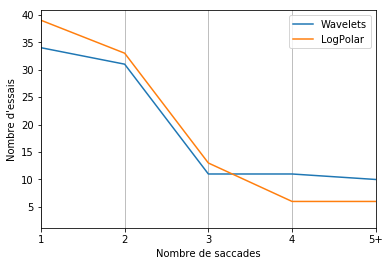

In [56]:
if Mode == 'Single':
    plt.plot(nb_sacc)
if Mode == 'Multiple':
    plt.plot(nb_sacc_wl)
    plt.plot(nb_sacc_lp)
    plt.legend(['Wavelets','LogPolar'], loc='upper right')
plt.grid(True, axis='x')

plt.xlim([1,5])
xticks_values = np.arange(1,6) ; xticks_names = [1,2,3,4,'5+']
plt.xticks(xticks_values, xticks_names)

plt.xlabel('Nombre de saccades')
plt.ylabel("Nombre d'essais")
if Mode == 'Single':
    if verbose: print('Mode:', Mode)
    if Filter == 'LogPolar':
        if verbose: print('Filter :', Filter)
        plt.savefig('logpolar_sacc_nombre.pdf')
    if Filter == 'Wavelets':
        if verbose: print('Filter :', Filter)
        plt.savefig('wavelets_sacc_nombre.pdf')
if Mode == 'Multiple':
    if verbose: print('Mode', Mode)
    plt.savefig('multiple_sacc_nombre.pdf')
plt.show()

Mode: Multiple


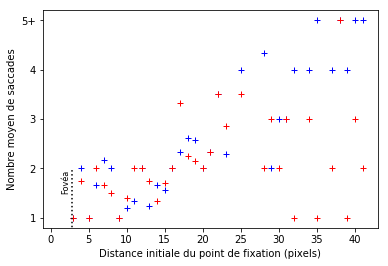

In [61]:
if Mode == 'Single':
    nb_totval = [[0,0] for _ in range(57)] # [nombre d'essais pour cette distance, somme du nombre de saccades)

    for example in range(test_size):
        distance = inital_dist_per_nb_sacc[example][0]                # récupération distance initiale de l'essai
        nb_totval[distance][0] += 1                                   # MàJ nombre d'essais pour cette distance
        nb_totval[distance][1] += inital_dist_per_nb_sacc[example][1] # MàJ somme du nombre de saccades pour cette distance

    distance = 0
    for value in nb_totval:        
        # Modifs pour obtenir nb_totval = [[distance, nombre moyen de saccades] for _ in range(57)]
        if value[0] != 0:                # Evite les divisions par zéro (distances jamais rencontrées)
            value[1] = value[1]/value[0] # Calcul nombre moyen de saccades
            value[0] = distance          # Remplacement nb d'essais par valeur de la distance
        else:
            value = (float('NaN'),float('NaN'))

        distance += 1    

        plt.plot(value[0], value[1], 'b+')
        
if Mode == 'Multiple':
    nb_totval_wl = [[0,0] for _ in range(57)] # [nombre d'essais pour cette distance, somme du nombre de saccades)
    nb_totval_lp = [[0,0] for _ in range(57)] # [nombre d'essais pour cette distance, somme du nombre de saccades)

    for example in range(test_size):
        distance = inital_dist_per_nb_sacc_wl[example][0]                # récupération distance initiale de l'essai
        nb_totval_wl[distance][0] += 1                                   # MàJ nombre d'essais pour cette distance
        nb_totval_lp[distance][0] += 1                                   # MàJ nombre d'essais pour cette distance
        nb_totval_wl[distance][1] += inital_dist_per_nb_sacc_wl[example][1] # MàJ somme du nombre de saccades pour cette distance
        nb_totval_lp[distance][1] += inital_dist_per_nb_sacc_lp[example][1] # MàJ somme du nombre de saccades pour cette distance

    distance = 0
    for value_wl in nb_totval_wl:        
        # Modifs pour obtenir nb_totval = [[distance, nombre moyen de saccades] for _ in range(57)]
        if value_wl[0] != 0:                # Evite les divisions par zéro (distances jamais rencontrées)
            value_wl[1] = value_wl[1]/value_wl[0] # Calcul nombre moyen de saccades
            value_wl[0] = distance          # Remplacement nb d'essais par valeur de la distance
        else:
            value_wl = (float('NaN'),float('NaN'))

        distance += 1  
    
        plt.plot(value_wl[0], value_wl[1], 'b+')
        
    distance = 0
    for value_lp in nb_totval_lp:        
        # Modifs pour obtenir nb_totval = [[distance, nombre moyen de saccades] for _ in range(57)]
        if value_lp[0] != 0:                # Evite les divisions par zéro (distances jamais rencontrées)
            value_lp[1] = value_lp[1]/value_lp[0] # Calcul nombre moyen de saccades
            value_lp[0] = distance          # Remplacement nb d'essais par valeur de la distance
        else:
            value_lp = (float('NaN'),float('NaN'))

        distance += 1 
        
        plt.plot(value_lp[0], value_lp[1], 'r+')
    
fovea_sqrd = np.square(fovea_size) + np.square(fovea_size)
taille_fovea = np.sqrt(fovea_sqrd)

plt.plot([taille_fovea/2,taille_fovea/2],[-1,2], ':', color='black')
plt.text(2, 1.85, 'Fovéa', ha='center', fontsize=8, rotation=90)
plt.ylim([0.8,5.2])
plt.xlim(-1)
yticks_values = np.arange(1,6) ; yticks_names = [1,2,3,4,'5+']
plt.yticks(yticks_values, yticks_names)
plt.xlabel('Distance initiale du point de fixation (pixels)')
plt.ylabel('Nombre moyen de saccades')
if verbose: print('Mode:', Mode)
if Mode == 'Single':
    if Filter == 'LogPolar':
        if verbose: print('Filter:', Filter)
        plt.savefig('logpolar_sacc_distance.pdf')
    if Filter == 'Wavelets':
        if verbose: print('Filter:', Filter)
        plt.savefig('wavelets_sacc_distance.pdf')
plt.show()

Filter : LogPolar


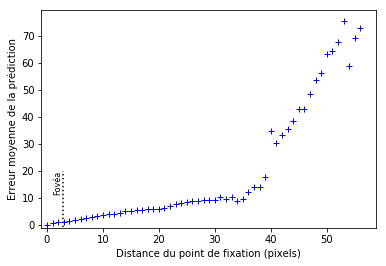

In [26]:
nb_totval = [[0,0] for _ in range(57)] # [nombre d'essais pour cette distance, somme des erreurs]

for example in err_per_dist:             # example = (err,dist)
    distance = example[1]                # récupération distance de l'essai
    nb_totval[distance][0] += 1          # MàJ nombre d'essais pour cette distance
    nb_totval[distance][1] += example[0] # MàJ somme des erreurs pour cette distance
    
distance = 0
for value in nb_totval:    
    # Modif pour obtenir  nb_totval = [[distance, erreur moyenne] for _ in range(57)]
    if value[0] != 0:                  # Evite les divisions par zéro (distance jamais rencontrées)
        value[1] = value[1]/value[0]   # Calcul erreur moyenne pour cette distance
        value[0] = distance            # Remplacement nb d'essais par valeur de la distance
    else :
        value = (float('NaN'), float('NaN'))
    
    distance += 1
    
    plt.plot(value[0],value[1], 'b+')     
 
fovea_sqrd = np.square(fovea_size) + np.square(fovea_size)
taille_fovea = np.sqrt(fovea_sqrd)

plt.ylim(-1) ; plt.xlim(-1)
plt.plot([taille_fovea/2,taille_fovea/2],[-5,20], ':', color='black')
plt.text(2, 17.7, 'Fovéa', ha='center', fontsize=8, rotation=90)
plt.xlabel('Distance du point de fixation (pixels)')
plt.ylabel("Erreur moyenne de la prédiction")
if Filter == 'LogPolar':
    if verbose: print('Filter :', Filter)
    plt.savefig('logpolar_err_distance.pdf')
if Filter == 'Wavelets':
    if verbose: print('Filter :', Filter)
    plt.savefig('wavelets_err_distance.pdf')
plt.show()

(-18, -20)
(-4, -2)


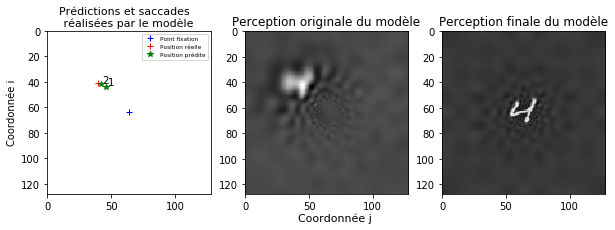

In [103]:
if Filter == 'LogPolar':
    phi_plus = np.linalg.pinv(phi_vectorial) # pseudo-inverse
    fig_size = 128
if Filter == 'Wavelets':
    
fix = fig_size/2 # Point de fixation
prev_val = (0,0)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
plt.subplot(131)
plt.plot(fix,fix, 'b+') # Point de fixation
plt.plot(fix + initial_coord[0], fix + initial_coord[1], 'r+')
it = 1
for value in sacc_chain:
    pos = (value[0] + prev_val[0],value[1] + prev_val[1])
    plt.plot(fix + pos[0],fix + pos[1], 'g*')
    plt.annotate(it,(1+fix+pos[0],-1+fix+pos[1]))    # annotation du numéro de la saccade
    prev_val = (pos[0],pos[1])
    it += 1
axes = plt.gca()                                          # permet de manipuler les axes
axes.set_xlim([0,fig_size]) ; axes.set_ylim([0,fig_size]) # defini les limites des axes
axes.invert_yaxis()                                       # inverse l'axe y (ou i) pour correspondre au format des donnees
fig.text(0.235, 0.9, 'Prédictions et saccades \n réalisées par le modèle', ha='center', fontsize=11)
plt.ylabel('Coordonnée i')
plt.legend(['Point fixation','Position réelle','Position prédite'], loc='upper right', fontsize='xx-small')

plt.subplot(132)
if Filter == 'LogPolar':
    image_hat = phi_plus @ v_ori # decoding z--> x
plt.imshow(image_hat.reshape((fig_size, fig_size)), cmap=plt.gray())
plt.title('Perception originale du modèle')

plt.subplot(133)
if Filter == 'LogPolar':
    image_hat = phi_plus @ v # decoding z--> x
plt.imshow(image_hat.reshape((fig_size, fig_size)), cmap=plt.gray())
plt.title('Perception finale du modèle')
fig.text(0.525, 0, 'Coordonnée j', ha='center', fontsize=11)
if Filter == 'LogPolar':
    if verbose: print('Filter :', Filter)
    #plt.savefig('logpolar_saccades_logpolar.pdf')
if Filter == 'Wavelets':
    if verbose: print('Filter :', Filter)
    #plt.savefig('wavelets_saccades_logpolar.pdf')
plt.show()